In [1]:
import gym
from gym import spaces
import numpy as np
import tensorflow as tf
from tensorflow import keras

from collections import deque
import numpy as np
from tqdm import tqdm

chain_mdp

In [2]:
class ChainMDP(gym.Env):
    """Chain MDP
    The environment consists of a chain of N states and the agent always starts in state s2,
    from where it can either move left or right.
    In state s1, the agent receives a small reward of r = 0.001 by moving left.
    A larger reward r = 1 is recived when moving right from state sN.
    This environment is described in
    Deep Exploration via Bootstrapped DQN(https://papers.nips.cc/paper/6501-deep-exploration-via-bootstrapped-dqn.pdf)
    """
    def __init__(self, n):
        self.n = n
        self.state = 1  # start at s2
        self.action_space = spaces.Discrete(2)  # {0, 1}
        self.observation_space = spaces.Discrete(self.n)  # {0, 1, ... n-1}
        self.max_nsteps = n + 8

    def step(self, action):
        assert self.action_space.contains(action)  # assert 뒤의 조건이 True가 아니면 AssertError 발생
        v = np.arange(self.n)  # [0, 1, ... n-1]
        reward = lambda s, a: 1.0 if (s == (self.n - 1) and a == 1) else (0.001 if (s == 0 and a == 0) else 0)
        is_done = lambda nsteps: nsteps >= self.max_nsteps  # True/False

        r = reward(self.state, action)
        if action:    # right
            if self.state != self.n - 1:
                self.state += 1
        else:   # left
            if self.state != 0:
                self.state -= 1
        self.nsteps += 1
        return (v <= self.state).astype('float32'), r, is_done(self.nsteps), None

    def reset(self):
        v = np.arange(self.n)
        self.state = 1
        self.nsteps = 0
        return (v <= self.state).astype('float32')

agent _chainMDP

In [3]:
class Qfunction(keras.Model):
    
    def __init__(self, obssize, actsize, hidden_dims):
        """
        obssize: dimension of state space
        actsize: dimension of action space
        hidden_dims: list containing output dimension of hidden layers 
        """
        super(Qfunction, self).__init__()

        # Layer weight initializer
        initializer = keras.initializers.RandomUniform(minval=-1e-2, maxval=1e-2)

        # Input Layer
        self.input_layer = keras.layers.InputLayer(input_shape=(obssize,))
        
        # Hidden Layer
        self.hidden_layers = []
        for hidden_dim in hidden_dims:
            # TODO: define each hidden layers
            layer = keras.layers.Dense(hidden_dim, activation='relu',
                                      kernel_initializer=initializer)
            self.hidden_layers.append(layer) 
        
        # Output Layer : 
        # TODO: Define the output layer.
        self.output_layer = keras.layers.Dense(actsize)

    @tf.function
    def call(self, states):
        ########################################################################
        # TODO: You SHOULD implement the model's forward pass
        x = self.input_layer(states)
        for hidden_layer in self.hidden_layers:
            x = hidden_layer(x)
        return self.output_layer(x)
        ########################################################################

# Wrapper class for training Qfunction and updating weights (target network) 

class DQN(object):
    
    def __init__(self, obssize, actsize, hidden_dims, optimizer):
        """
        obssize: dimension of state space
        actsize: dimension of action space
        optimizer: 
        """
        self.qfunction = Qfunction(obssize, actsize, hidden_dims)
        self.optimizer = optimizer
        self.obssize = obssize
        self.actsize = actsize

    def _predict_q(self, states, actions):
        """
        states represent s_t
        actions represent a_t
        """
        ########################################################################
        # TODO: Define the logic for calculate  Q_\theta(s,a)
        q = []
        for j in range(len(actions)):
            q.append(self.qfunction(states)[j][actions[j]])
        return tf.convert_to_tensor(q, dtype=tf.float32)
        ########################################################################
        

    def _loss(self, Qpreds, targets):
        """
        Qpreds represent Q_\theta(s,a)
        targets represent the terms E[r+gamma Q] in Bellman equations
        This function is OBJECTIVE function
        """
        l = tf.math.reduce_mean(tf.square(Qpreds - targets))
        return l

    
    def compute_Qvalues(self, states):
        """
        states: numpy array as input to the neural net, states should have
        size [numsamples, obssize], where numsamples is the number of samples
        output: Q values for these states. The output should have size 
        [numsamples, actsize] as numpy array
        """
        inputs = np.atleast_2d(states.astype('float32'))
        return self.qfunction(inputs)


    def train(self, states, actions, targets):
        """
        states: numpy array as input to compute loss (s)
        actions: numpy array as input to compute loss (a)
        targets: numpy array as input to compute loss (Q targets)
        """
        with tf.GradientTape() as tape:
            Qpreds = self._predict_q(states, actions)
            loss = self._loss(Qpreds, targets)
        variables = self.qfunction.trainable_variables
        gradients = tape.gradient(loss, variables)
        self.optimizer.apply_gradients(zip(gradients, variables))
        return loss

    def update_weights(self, from_network):
        """
        We need a subroutine to update target network 
        i.e. to copy from principal network to target network. 
        This function is for copying  theta -> theta target 
        """
        
        from_var = from_network.qfunction.trainable_variables
        to_var = self.qfunction.trainable_variables
        
        # soft assign
        for v1, v2 in zip(from_var, to_var):
            v2.assign(0.8*v1+0.2*v2)

# Implement replay buffer
class ReplayBuffer(object):
    
    def __init__(self, maxlength):
        """
        maxlength: max number of tuples to store in the buffer
        if there are more tuples than maxlength, pop out the oldest tuples
        """
        self.buffer = deque()
        self.number = 0
        self.maxlength = maxlength
    
    def append(self, experience):
        """
        this function implements appending new experience tuple
        experience: a tuple of the form (s,a,r,s^\prime)
        """
        self.buffer.append(experience)
        self.number += 1
        if(self.number > self.maxlength):
            self.pop()
        
    def pop(self):
        """
        pop out the oldest tuples if self.number > self.maxlength
        """
        while self.number > self.maxlength:
            self.buffer.popleft()
            self.number -= 1
    
    def sample(self, batchsize):
        """
        this function samples 'batchsize' experience tuples
        batchsize: size of the minibatch to be sampled
        return: a list of tuples of form (s,a,r,s^\prime)
        """
        inds = np.random.choice(len(self.buffer), batchsize, replace=False)
        return [self.buffer[idx] for idx in inds]

In [4]:
# class agent():
    
#     def __init__(self):
        
#         return
    
#     def action(self):
        
#         return 1

In [5]:
### DQN implementation ###

class agent():

    def __init__(self):
        self.hidden_dim = [8, 4]
        self.lr = 5e-3
        self.ensemble_num = 3
        print("chainMDP agent made.")


    def action(self, s):
        self.s = s
        voting_paper = np.zeros(2)

        if np.random.rand() < self.eps:
            return np.random.choice([0, 1])
        else:
            for n in range(self.ensemble_num):
                Q = self.Qs[n][0].compute_Qvalues(np.array(self.s))
                action = np.argmax(Q)  # always max action choose
                # voting_paper[action] += 1
                voting_paper[action] += (Q[0][action] - np.mean(Q[0])) / np.std(Q[0])
            return np.argmax(voting_paper)


    def load_weights(self):
        print("loading existing model..")
        self.Qs = []
        for i in range(self.ensemble_num):
            Qprin = DQN(10, 2, self.hidden_dim, optimizer = keras.optimizers.Adam(learning_rate=self.lr))
            Qtarg = DQN(10, 2, self.hidden_dim, optimizer = keras.optimizers.Adam(learning_rate=self.lr))
            Qprin.qfunction = keras.models.load_model(os.getcwd()+"/model/chainMDP"+'/Qprin_'+str(i))
            Qtarg.qfunction = keras.models.load_model(os.getcwd()+"/model/chainMDP"+'/Qtarg_'+str(i))

            self.Qs.append([Qprin, Qtarg])
        
        self.eps = 0


    def train(self, episodes, env, no_render):

        self.env = env
        self.state = self.env.reset()
        self.episode_length = episodes


        ### For Q value training ###
        self.eps = 1

        self.bernoulli_prob = 0.5

        self.Qprin = DQN(self.env.n, self.env.action_space.n, self.hidden_dim,
                         optimizer=keras.optimizers.Adam(learning_rate=self.lr))
        self.Qtarg = DQN(self.env.n, self.env.action_space.n, self.hidden_dim,
                         optimizer=keras.optimizers.Adam(learning_rate=self.lr))
        self.Qs = []
        for _ in range(self.ensemble_num):
            self.Qs.append([self.Qprin, self.Qtarg])
        totalstep = 0
        initialize = self.env.n * 30
        eps = 1
        eps_minus = 1e-2
        tau = self.env.n * 10
        gamma = 0.99
        batchsize = 64
        buff_max_size = 10000
        buffer = ReplayBuffer(buff_max_size)
        ############################

        self.r_record = []
        # === For additional rewards for less visited states === #
        state_visit_history = np.zeros(self.env.observation_space.n)
        # ====================================================== #
        for iter in range(self.episode_length):
            self.state = self.env.reset()
            done = False
            rsum = 0

            while not done:
                totalstep += 1

                #####################
                ### Epsilon Decay ###
                # #####################
                # if np.sum(np.array(self.r_record) >= 1) >= 1:
                if eps > 0.05 and totalstep > initialize:
                    eps -= eps_minus
                elif eps < 0.05 and totalstep > initialize:
                    eps = 0

                ##################
                ### Get Action ###
                ##################
                if np.random.rand() < eps or totalstep <= initialize:
                    action = np.random.choice([0, 1])
                else:
                    voting_paper = np.zeros(self.env.action_space.n)

                    for n in range(self.ensemble_num):
                        Q = self.Qs[n][0].compute_Qvalues(np.array(self.state))
                        action = np.argmax(Q)  # always max action choose
                        # voting_paper[action] += 1
                        voting_paper[action] += (Q[0][action] - np.mean(Q[0])) / np.std(Q[0])

                    action = np.argmax(voting_paper)
                ##################

                ##################
                ###  ONE STEP  ###
                ##################
                curr_state = self.state
                next_state, reward, done, _ = self.env.step(action)
                rsum += reward
                ##################
                # ===== additional reward for less visited states ===== #
                pos = np.count_nonzero(next_state)
                reward += np.exp(-(state_visit_history[pos-1]//self.env.n))
                state_visit_history[pos-1] += 1
                print(state_visit_history, eps, iter)
                # ===================================================== #

                # === ensemble DQN === #
                heads = np.random.binomial(1, self.bernoulli_prob, self.ensemble_num)
                if np.sum(heads) == 0:
                    heads[np.random.randint(0, self.ensemble_num)] = 1
                # ==================== #

                #####################
                ### Update Buffer ###
                #####################
                buffer.append((curr_state, action, reward, next_state, done, heads))
                #####################

                #############################
                ### N Samples from Buffer ###
                ###         and           ###
                ### Update theta of Qprin ###
                #############################
                if totalstep > initialize:

                    # sample
                    s = buffer.sample(batchsize)

                    d = []
                    for j in range(len(s)):  # for each s[j]s
                        ## if head 0 : append 0 at K, head 1 : append value of k to K
                        ## iterate for all samples
                        K = []
                        cS = s[j][0];
                        A = s[j][1];
                        R = s[j][2];
                        nS = s[j][3];
                        DONE = s[j][4];
                        heads = s[j][5];
                        if not DONE:
                            for n in range(len(heads)):
                                if heads[n] == 0:
                                    k = 0
                                else:
                                    k = R + gamma * np.max(self.Qs[n][1].compute_Qvalues(nS))  # Qtarg_n
                                K.append(k)
                        elif DONE:
                            for n in range(len(heads)):
                                if heads[n] == 0:
                                    k = 0
                                else:
                                    k = R
                                K.append(k)
                        d.append(K)

                    # update Qprins
                    for n in range(self.ensemble_num):
                        set_of_S = np.array([s[x][0] for x in range(len(s)) if s[x][5][n] == 1])
                        set_of_A = np.array([s[x][1] for x in range(len(s)) if s[x][5][n] == 1])
                        D = [d[x][n] for x in range(len(s)) if s[x][5][n] == 1]

                        self.Qs[n][0].train(set_of_S, set_of_A, tf.convert_to_tensor(D, dtype=tf.float32))  # Qprin
                #############################

                #############################
                ### Update theta of Qtarg ###
                #############################
                if totalstep % tau == 0:
                    for n in range(self.ensemble_num):
                        self.Qs[n][1].update_weights(self.Qs[n][0])
                #############################

                pass

            #########################
            ### Sample Efficiency ###
            #########################
            self.r_record.append(rsum)

        self.eps = eps

        # for i in range(len(self.Qs)):
        #     self.Qs[i][0].qfunction.save(os.getcwd()+"/model/chainMDP"+'/Qprin_'+str(i))
        #     self.Qs[i][1].qfunction.save(os.getcwd()+"/model/chainMDP"+'/Qtarg_'+str(i))

        return self.r_record

chain_test

In [6]:
import numpy as np

def calculate_performance(episodes, env, agent):

    episodic_returns = []
    
    for epi in range(episodes):
        
        s = env.reset()

        done = False
        cum_reward = 0.0

        while not done:    
            action = agent.action(s)
            ns, reward, done, _ = env.step(action)
            cum_reward += reward
            s = ns
        
        episodic_returns.append(cum_reward)
                    
    return np.sum(episodic_returns)

def calculate_sample_efficiency(episodes, env, agent):

    s = env.reset()
    episodic_returns = agent.train(episodes)          # train policy of the agent
                    
    return np.sum(episodic_returns)

single

In [7]:
import time

start = time.time()

In [8]:
# from chain_mdp import ChainMDP
# from agent_chainMDP import agent

# chain length
n = 10
#head_num = 3

# recieve 1 at rightmost stae and recieve small reward at leftmost state
env = ChainMDP(n)
s = env.reset()

""" Your agent"""
agents = agent()     # agent call
AUC = agents.train(1000, env, 0)          # train policy of the agent
print(AUC)
print("AUC: ", np.sum(AUC))

chainMDP agent made.
[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.] 1 0
[0. 1. 1. 0. 0. 0. 0. 0. 0. 0.] 1 0
[0. 1. 2. 0. 0. 0. 0. 0. 0. 0.] 1 0
[0. 2. 2. 0. 0. 0. 0. 0. 0. 0.] 1 0
[0. 2. 3. 0. 0. 0. 0. 0. 0. 0.] 1 0
[0. 2. 3. 1. 0. 0. 0. 0. 0. 0.] 1 0
[0. 2. 4. 1. 0. 0. 0. 0. 0. 0.] 1 0
[0. 3. 4. 1. 0. 0. 0. 0. 0. 0.] 1 0
[1. 3. 4. 1. 0. 0. 0. 0. 0. 0.] 1 0
[2. 3. 4. 1. 0. 0. 0. 0. 0. 0.] 1 0
[2. 4. 4. 1. 0. 0. 0. 0. 0. 0.] 1 0
[2. 4. 5. 1. 0. 0. 0. 0. 0. 0.] 1 0
[2. 4. 5. 2. 0. 0. 0. 0. 0. 0.] 1 0
[2. 4. 6. 2. 0. 0. 0. 0. 0. 0.] 1 0
[2. 5. 6. 2. 0. 0. 0. 0. 0. 0.] 1 0
[3. 5. 6. 2. 0. 0. 0. 0. 0. 0.] 1 0
[4. 5. 6. 2. 0. 0. 0. 0. 0. 0.] 1 0
[4. 6. 6. 2. 0. 0. 0. 0. 0. 0.] 1 0
[4. 6. 7. 2. 0. 0. 0. 0. 0. 0.] 1 1
[4. 6. 7. 3. 0. 0. 0. 0. 0. 0.] 1 1
[4. 6. 7. 3. 1. 0. 0. 0. 0. 0.] 1 1
[4. 6. 7. 3. 1. 1. 0. 0. 0. 0.] 1 1
[4. 6. 7. 3. 2. 1. 0. 0. 0. 0.] 1 1
[4. 6. 7. 4. 2. 1. 0. 0. 0. 0.] 1 1
[4. 6. 8. 4. 2. 1. 0. 0. 0. 0.] 1 1
[4. 7. 8. 4. 2. 1. 0. 0. 0. 0.] 1 1
[5. 7. 8. 4. 2. 1. 0. 0. 0. 0.] 1 1
[5. 8. 

[57. 61. 70. 51. 30. 16.  6.  7.  4.  0.] 0.98 16
[57. 61. 70. 51. 31. 16.  6.  7.  4.  0.] 0.97 16
[57. 61. 70. 51. 31. 17.  6.  7.  4.  0.] 0.96 16
[57. 61. 70. 51. 32. 17.  6.  7.  4.  0.] 0.95 16
[57. 61. 70. 51. 32. 18.  6.  7.  4.  0.] 0.94 16
[58. 61. 70. 51. 32. 18.  6.  7.  4.  0.] 0.9299999999999999 17
[59. 61. 70. 51. 32. 18.  6.  7.  4.  0.] 0.9199999999999999 17
[59. 62. 70. 51. 32. 18.  6.  7.  4.  0.] 0.9099999999999999 17
[59. 62. 71. 51. 32. 18.  6.  7.  4.  0.] 0.8999999999999999 17
[59. 62. 71. 52. 32. 18.  6.  7.  4.  0.] 0.8899999999999999 17
[59. 62. 72. 52. 32. 18.  6.  7.  4.  0.] 0.8799999999999999 17
[59. 62. 72. 53. 32. 18.  6.  7.  4.  0.] 0.8699999999999999 17
[59. 62. 73. 53. 32. 18.  6.  7.  4.  0.] 0.8599999999999999 17
[59. 63. 73. 53. 32. 18.  6.  7.  4.  0.] 0.8499999999999999 17
[60. 63. 73. 53. 32. 18.  6.  7.  4.  0.] 0.8399999999999999 17
[60. 64. 73. 53. 32. 18.  6.  7.  4.  0.] 0.8299999999999998 17
[60. 64. 74. 53. 32. 18.  6.  7.  4.  0.] 0.81

[61. 67. 86. 64. 41. 28. 15. 16. 14. 52.] 0 24
[61. 67. 86. 64. 41. 28. 15. 16. 14. 53.] 0 24
[61. 67. 86. 64. 41. 28. 15. 16. 14. 54.] 0 24
[61. 67. 86. 64. 41. 28. 15. 16. 14. 55.] 0 24
[61. 67. 86. 64. 41. 28. 15. 16. 14. 56.] 0 24
[61. 67. 86. 64. 41. 28. 15. 16. 14. 57.] 0 24
[61. 67. 86. 64. 41. 28. 15. 16. 14. 58.] 0 24
[61. 67. 87. 64. 41. 28. 15. 16. 14. 58.] 0 25
[61. 67. 87. 65. 41. 28. 15. 16. 14. 58.] 0 25
[61. 67. 87. 65. 42. 28. 15. 16. 14. 58.] 0 25
[61. 67. 87. 65. 42. 29. 15. 16. 14. 58.] 0 25
[61. 67. 87. 65. 42. 29. 16. 16. 14. 58.] 0 25
[61. 67. 87. 65. 42. 29. 16. 17. 14. 58.] 0 25
[61. 67. 87. 65. 42. 29. 16. 17. 15. 58.] 0 25
[61. 67. 87. 65. 42. 29. 16. 17. 15. 59.] 0 25
[61. 67. 87. 65. 42. 29. 16. 17. 15. 60.] 0 25
[61. 67. 87. 65. 42. 29. 16. 17. 15. 61.] 0 25
[61. 67. 87. 65. 42. 29. 16. 17. 15. 62.] 0 25
[61. 67. 87. 65. 42. 29. 16. 17. 15. 63.] 0 25
[61. 67. 87. 65. 42. 29. 16. 17. 15. 64.] 0 25
[61. 67. 87. 65. 42. 29. 16. 17. 15. 65.] 0 25
[61. 67. 87. 

[ 61.  67.  95.  73.  50.  37.  24.  25.  23. 147.] 0 33
[ 61.  67.  95.  73.  50.  37.  24.  25.  23. 148.] 0 33
[ 61.  67.  95.  73.  50.  37.  24.  25.  23. 149.] 0 33
[ 61.  67.  95.  73.  50.  37.  24.  25.  23. 150.] 0 33
[ 61.  67.  95.  73.  50.  37.  24.  25.  23. 151.] 0 33
[ 61.  67.  95.  73.  50.  37.  24.  25.  23. 152.] 0 33
[ 61.  67.  95.  73.  50.  37.  24.  25.  23. 153.] 0 33
[ 61.  67.  95.  73.  50.  37.  24.  25.  23. 154.] 0 33
[ 61.  67.  95.  73.  50.  37.  24.  25.  23. 155.] 0 33
[ 61.  67.  95.  73.  50.  37.  24.  25.  23. 156.] 0 33
[ 61.  67.  95.  73.  50.  37.  24.  25.  23. 157.] 0 33
[ 61.  67.  96.  73.  50.  37.  24.  25.  23. 157.] 0 34
[ 61.  67.  96.  74.  50.  37.  24.  25.  23. 157.] 0 34
[ 61.  67.  96.  74.  51.  37.  24.  25.  23. 157.] 0 34
[ 61.  67.  96.  74.  51.  38.  24.  25.  23. 157.] 0 34
[ 61.  67.  96.  74.  51.  38.  25.  25.  23. 157.] 0 34
[ 61.  67.  96.  74.  51.  38.  25.  26.  23. 157.] 0 34
[ 61.  67.  96.  74.  51.  38. 

[ 61.  67. 103.  81.  58.  45.  32.  33.  31. 235.] 0 41
[ 61.  67. 103.  81.  58.  45.  32.  33.  31. 236.] 0 41
[ 61.  67. 103.  81.  58.  45.  32.  33.  31. 237.] 0 41
[ 61.  67. 103.  81.  58.  45.  32.  33.  31. 238.] 0 41
[ 61.  67. 103.  81.  58.  45.  32.  33.  31. 239.] 0 41
[ 61.  67. 103.  81.  58.  45.  32.  33.  31. 240.] 0 41
[ 61.  67. 103.  81.  58.  45.  32.  33.  31. 241.] 0 41
[ 61.  67. 103.  81.  58.  45.  32.  33.  31. 242.] 0 41
[ 61.  67. 103.  81.  58.  45.  32.  33.  31. 243.] 0 41
[ 61.  67. 103.  81.  58.  45.  32.  33.  31. 244.] 0 41
[ 61.  67. 103.  81.  58.  45.  32.  33.  31. 245.] 0 41
[ 61.  67. 104.  81.  58.  45.  32.  33.  31. 245.] 0 42
[ 61.  67. 104.  82.  58.  45.  32.  33.  31. 245.] 0 42
[ 61.  67. 104.  82.  59.  45.  32.  33.  31. 245.] 0 42
[ 61.  67. 104.  82.  59.  46.  32.  33.  31. 245.] 0 42
[ 61.  67. 104.  82.  59.  46.  33.  33.  31. 245.] 0 42
[ 61.  67. 104.  82.  59.  46.  33.  34.  31. 245.] 0 42
[ 61.  67. 104.  82.  59.  46. 

[ 61.  67. 111.  89.  66.  53.  40.  41.  39. 323.] 0 49
[ 61.  67. 111.  89.  66.  53.  40.  41.  39. 324.] 0 49
[ 61.  67. 111.  89.  66.  53.  40.  41.  39. 325.] 0 49
[ 61.  67. 111.  89.  66.  53.  40.  41.  39. 326.] 0 49
[ 61.  67. 111.  89.  66.  53.  40.  41.  39. 327.] 0 49
[ 61.  67. 111.  89.  66.  53.  40.  41.  39. 328.] 0 49
[ 61.  67. 111.  89.  66.  53.  40.  41.  39. 329.] 0 49
[ 61.  67. 111.  89.  66.  53.  40.  41.  39. 330.] 0 49
[ 61.  67. 111.  89.  66.  53.  40.  41.  39. 331.] 0 49
[ 61.  67. 111.  89.  66.  53.  40.  41.  39. 332.] 0 49
[ 61.  67. 111.  89.  66.  53.  40.  41.  39. 333.] 0 49
[ 61.  67. 112.  89.  66.  53.  40.  41.  39. 333.] 0 50
[ 61.  67. 112.  90.  66.  53.  40.  41.  39. 333.] 0 50
[ 61.  67. 112.  90.  67.  53.  40.  41.  39. 333.] 0 50
[ 61.  67. 112.  90.  67.  54.  40.  41.  39. 333.] 0 50
[ 61.  67. 112.  90.  67.  54.  41.  41.  39. 333.] 0 50
[ 61.  67. 112.  90.  67.  54.  41.  42.  39. 333.] 0 50
[ 61.  67. 112.  90.  67.  54. 

[ 61.  67. 119.  97.  74.  61.  48.  49.  47. 411.] 0 57
[ 61.  67. 119.  97.  74.  61.  48.  49.  47. 412.] 0 57
[ 61.  67. 119.  97.  74.  61.  48.  49.  47. 413.] 0 57
[ 61.  67. 119.  97.  74.  61.  48.  49.  47. 414.] 0 57
[ 61.  67. 119.  97.  74.  61.  48.  49.  47. 415.] 0 57
[ 61.  67. 119.  97.  74.  61.  48.  49.  47. 416.] 0 57
[ 61.  67. 119.  97.  74.  61.  48.  49.  47. 417.] 0 57
[ 61.  67. 119.  97.  74.  61.  48.  49.  47. 418.] 0 57
[ 61.  67. 119.  97.  74.  61.  48.  49.  47. 419.] 0 57
[ 61.  67. 119.  97.  74.  61.  48.  49.  47. 420.] 0 57
[ 61.  67. 119.  97.  74.  61.  48.  49.  47. 421.] 0 57
[ 61.  67. 120.  97.  74.  61.  48.  49.  47. 421.] 0 58
[ 61.  67. 120.  98.  74.  61.  48.  49.  47. 421.] 0 58
[ 61.  67. 120.  98.  75.  61.  48.  49.  47. 421.] 0 58
[ 61.  67. 120.  98.  75.  62.  48.  49.  47. 421.] 0 58
[ 61.  67. 120.  98.  75.  62.  49.  49.  47. 421.] 0 58
[ 61.  67. 120.  98.  75.  62.  49.  50.  47. 421.] 0 58
[ 61.  67. 120.  98.  75.  62. 

[ 61.  67. 127. 105.  82.  69.  56.  57.  55. 499.] 0 65
[ 61.  67. 127. 105.  82.  69.  56.  57.  55. 500.] 0 65
[ 61.  67. 127. 105.  82.  69.  56.  57.  55. 501.] 0 65
[ 61.  67. 127. 105.  82.  69.  56.  57.  55. 502.] 0 65
[ 61.  67. 127. 105.  82.  69.  56.  57.  55. 503.] 0 65
[ 61.  67. 127. 105.  82.  69.  56.  57.  55. 504.] 0 65
[ 61.  67. 127. 105.  82.  69.  56.  57.  55. 505.] 0 65
[ 61.  67. 127. 105.  82.  69.  56.  57.  55. 506.] 0 65
[ 61.  67. 127. 105.  82.  69.  56.  57.  55. 507.] 0 65
[ 61.  67. 127. 105.  82.  69.  56.  57.  55. 508.] 0 65
[ 61.  67. 127. 105.  82.  69.  56.  57.  55. 509.] 0 65
[ 61.  67. 128. 105.  82.  69.  56.  57.  55. 509.] 0 66
[ 61.  67. 128. 106.  82.  69.  56.  57.  55. 509.] 0 66
[ 61.  67. 128. 106.  83.  69.  56.  57.  55. 509.] 0 66
[ 61.  67. 128. 106.  83.  70.  56.  57.  55. 509.] 0 66
[ 61.  67. 128. 106.  83.  70.  57.  57.  55. 509.] 0 66
[ 61.  67. 128. 106.  83.  70.  57.  58.  55. 509.] 0 66
[ 61.  67. 128. 106.  83.  70. 

[ 61.  67. 135. 113.  90.  77.  64.  65.  63. 587.] 0 73
[ 61.  67. 135. 113.  90.  77.  64.  65.  63. 588.] 0 73
[ 61.  67. 135. 113.  90.  77.  64.  65.  63. 589.] 0 73
[ 61.  67. 135. 113.  90.  77.  64.  65.  63. 590.] 0 73
[ 61.  67. 135. 113.  90.  77.  64.  65.  63. 591.] 0 73
[ 61.  67. 135. 113.  90.  77.  64.  65.  63. 592.] 0 73
[ 61.  67. 135. 113.  90.  77.  64.  65.  63. 593.] 0 73
[ 61.  67. 135. 113.  90.  77.  64.  65.  63. 594.] 0 73
[ 61.  67. 135. 113.  90.  77.  64.  65.  63. 595.] 0 73
[ 61.  67. 135. 113.  90.  77.  64.  65.  63. 596.] 0 73
[ 61.  67. 135. 113.  90.  77.  64.  65.  63. 597.] 0 73
[ 61.  67. 136. 113.  90.  77.  64.  65.  63. 597.] 0 74
[ 61.  67. 136. 114.  90.  77.  64.  65.  63. 597.] 0 74
[ 61.  67. 136. 114.  91.  77.  64.  65.  63. 597.] 0 74
[ 61.  67. 136. 114.  91.  78.  64.  65.  63. 597.] 0 74
[ 61.  67. 136. 114.  91.  78.  65.  65.  63. 597.] 0 74
[ 61.  67. 136. 114.  91.  78.  65.  66.  63. 597.] 0 74
[ 61.  67. 136. 114.  91.  78. 

[ 61.  67. 143. 121.  98.  85.  72.  73.  71. 675.] 0 81
[ 61.  67. 143. 121.  98.  85.  72.  73.  71. 676.] 0 81
[ 61.  67. 143. 121.  98.  85.  72.  73.  71. 677.] 0 81
[ 61.  67. 143. 121.  98.  85.  72.  73.  71. 678.] 0 81
[ 61.  67. 143. 121.  98.  85.  72.  73.  71. 679.] 0 81
[ 61.  67. 143. 121.  98.  85.  72.  73.  71. 680.] 0 81
[ 61.  67. 143. 121.  98.  85.  72.  73.  71. 681.] 0 81
[ 61.  67. 143. 121.  98.  85.  72.  73.  71. 682.] 0 81
[ 61.  67. 143. 121.  98.  85.  72.  73.  71. 683.] 0 81
[ 61.  67. 143. 121.  98.  85.  72.  73.  71. 684.] 0 81
[ 61.  67. 143. 121.  98.  85.  72.  73.  71. 685.] 0 81
[ 61.  67. 144. 121.  98.  85.  72.  73.  71. 685.] 0 82
[ 61.  67. 144. 122.  98.  85.  72.  73.  71. 685.] 0 82
[ 61.  67. 144. 122.  99.  85.  72.  73.  71. 685.] 0 82
[ 61.  67. 144. 122.  99.  86.  72.  73.  71. 685.] 0 82
[ 61.  67. 144. 122.  99.  86.  73.  73.  71. 685.] 0 82
[ 61.  67. 144. 122.  99.  86.  73.  74.  71. 685.] 0 82
[ 61.  67. 144. 122.  99.  86. 

[ 61.  67. 151. 129. 106.  93.  80.  81.  79. 763.] 0 89
[ 61.  67. 151. 129. 106.  93.  80.  81.  79. 764.] 0 89
[ 61.  67. 151. 129. 106.  93.  80.  81.  79. 765.] 0 89
[ 61.  67. 151. 129. 106.  93.  80.  81.  79. 766.] 0 89
[ 61.  67. 151. 129. 106.  93.  80.  81.  79. 767.] 0 89
[ 61.  67. 151. 129. 106.  93.  80.  81.  79. 768.] 0 89
[ 61.  67. 151. 129. 106.  93.  80.  81.  79. 769.] 0 89
[ 61.  67. 151. 129. 106.  93.  80.  81.  79. 770.] 0 89
[ 61.  67. 151. 129. 106.  93.  80.  81.  79. 771.] 0 89
[ 61.  67. 151. 129. 106.  93.  80.  81.  79. 772.] 0 89
[ 61.  67. 151. 129. 106.  93.  80.  81.  79. 773.] 0 89
[ 61.  67. 152. 129. 106.  93.  80.  81.  79. 773.] 0 90
[ 61.  67. 152. 130. 106.  93.  80.  81.  79. 773.] 0 90
[ 61.  67. 152. 130. 107.  93.  80.  81.  79. 773.] 0 90
[ 61.  67. 152. 130. 107.  94.  80.  81.  79. 773.] 0 90
[ 61.  67. 152. 130. 107.  94.  81.  81.  79. 773.] 0 90
[ 61.  67. 152. 130. 107.  94.  81.  82.  79. 773.] 0 90
[ 61.  67. 152. 130. 107.  94. 

[ 61.  67. 159. 137. 114. 101.  88.  89.  87. 851.] 0 97
[ 61.  67. 159. 137. 114. 101.  88.  89.  87. 852.] 0 97
[ 61.  67. 159. 137. 114. 101.  88.  89.  87. 853.] 0 97
[ 61.  67. 159. 137. 114. 101.  88.  89.  87. 854.] 0 97
[ 61.  67. 159. 137. 114. 101.  88.  89.  87. 855.] 0 97
[ 61.  67. 159. 137. 114. 101.  88.  89.  87. 856.] 0 97
[ 61.  67. 159. 137. 114. 101.  88.  89.  87. 857.] 0 97
[ 61.  67. 159. 137. 114. 101.  88.  89.  87. 858.] 0 97
[ 61.  67. 159. 137. 114. 101.  88.  89.  87. 859.] 0 97
[ 61.  67. 159. 137. 114. 101.  88.  89.  87. 860.] 0 97
[ 61.  67. 159. 137. 114. 101.  88.  89.  87. 861.] 0 97
[ 61.  67. 160. 137. 114. 101.  88.  89.  87. 861.] 0 98
[ 61.  67. 160. 138. 114. 101.  88.  89.  87. 861.] 0 98
[ 61.  67. 160. 138. 115. 101.  88.  89.  87. 861.] 0 98
[ 61.  67. 160. 138. 115. 102.  88.  89.  87. 861.] 0 98
[ 61.  67. 160. 138. 115. 102.  89.  89.  87. 861.] 0 98
[ 61.  67. 160. 138. 115. 102.  89.  90.  87. 861.] 0 98
[ 61.  67. 160. 138. 115. 102. 

[ 61.  67. 167. 145. 122. 109.  96.  97.  95. 938.] 0 105
[ 61.  67. 167. 145. 122. 109.  96.  97.  95. 939.] 0 105
[ 61.  67. 167. 145. 122. 109.  96.  97.  95. 940.] 0 105
[ 61.  67. 167. 145. 122. 109.  96.  97.  95. 941.] 0 105
[ 61.  67. 167. 145. 122. 109.  96.  97.  95. 942.] 0 105
[ 61.  67. 167. 145. 122. 109.  96.  97.  95. 943.] 0 105
[ 61.  67. 167. 145. 122. 109.  96.  97.  95. 944.] 0 105
[ 61.  67. 167. 145. 122. 109.  96.  97.  95. 945.] 0 105
[ 61.  67. 167. 145. 122. 109.  96.  97.  95. 946.] 0 105
[ 61.  67. 167. 145. 122. 109.  96.  97.  95. 947.] 0 105
[ 61.  67. 167. 145. 122. 109.  96.  97.  95. 948.] 0 105
[ 61.  67. 167. 145. 122. 109.  96.  97.  95. 949.] 0 105
[ 61.  67. 168. 145. 122. 109.  96.  97.  95. 949.] 0 106
[ 61.  67. 168. 146. 122. 109.  96.  97.  95. 949.] 0 106
[ 61.  67. 168. 146. 123. 109.  96.  97.  95. 949.] 0 106
[ 61.  67. 168. 146. 123. 110.  96.  97.  95. 949.] 0 106
[ 61.  67. 168. 146. 123. 110.  97.  97.  95. 949.] 0 106
[ 61.  67. 168

[  61.   67.  174.  152.  129.  116.  103.  104.  102. 1024.] 0 112
[  61.   67.  174.  152.  129.  116.  103.  104.  102. 1025.] 0 112
[  61.   67.  174.  152.  129.  116.  103.  104.  102. 1026.] 0 112
[  61.   67.  175.  152.  129.  116.  103.  104.  102. 1026.] 0 113
[  61.   67.  175.  153.  129.  116.  103.  104.  102. 1026.] 0 113
[  61.   67.  175.  153.  130.  116.  103.  104.  102. 1026.] 0 113
[  61.   67.  175.  153.  130.  117.  103.  104.  102. 1026.] 0 113
[  61.   67.  175.  153.  130.  117.  104.  104.  102. 1026.] 0 113
[  61.   67.  175.  153.  130.  117.  104.  105.  102. 1026.] 0 113
[  61.   67.  175.  153.  130.  117.  104.  105.  103. 1026.] 0 113
[  61.   67.  175.  153.  130.  117.  104.  105.  103. 1027.] 0 113
[  61.   67.  175.  153.  130.  117.  104.  105.  103. 1028.] 0 113
[  61.   67.  175.  153.  130.  117.  104.  105.  103. 1029.] 0 113
[  61.   67.  175.  153.  130.  117.  104.  105.  103. 1030.] 0 113
[  61.   67.  175.  153.  130.  117.  104.  105.

[  61.   67.  181.  159.  136.  123.  110.  111.  109. 1096.] 0 119
[  61.   67.  181.  159.  136.  123.  110.  111.  109. 1097.] 0 119
[  61.   67.  181.  159.  136.  123.  110.  111.  109. 1098.] 0 119
[  61.   67.  181.  159.  136.  123.  110.  111.  109. 1099.] 0 119
[  61.   67.  181.  159.  136.  123.  110.  111.  109. 1100.] 0 119
[  61.   67.  181.  159.  136.  123.  110.  111.  109. 1101.] 0 119
[  61.   67.  181.  159.  136.  123.  110.  111.  109. 1102.] 0 119
[  61.   67.  181.  159.  136.  123.  110.  111.  109. 1103.] 0 119
[  61.   67.  182.  159.  136.  123.  110.  111.  109. 1103.] 0 120
[  61.   67.  182.  160.  136.  123.  110.  111.  109. 1103.] 0 120
[  61.   67.  182.  160.  137.  123.  110.  111.  109. 1103.] 0 120
[  61.   67.  182.  160.  137.  124.  110.  111.  109. 1103.] 0 120
[  61.   67.  182.  160.  137.  124.  111.  111.  109. 1103.] 0 120
[  61.   67.  182.  160.  137.  124.  111.  112.  109. 1103.] 0 120
[  61.   67.  182.  160.  137.  124.  111.  112.

[  61.   67.  188.  166.  143.  130.  117.  118.  115. 1169.] 0 126
[  61.   67.  188.  166.  143.  130.  117.  118.  116. 1169.] 0 126
[  61.   67.  188.  166.  143.  130.  117.  118.  116. 1170.] 0 126
[  61.   67.  188.  166.  143.  130.  117.  118.  116. 1171.] 0 126
[  61.   67.  188.  166.  143.  130.  117.  118.  116. 1172.] 0 126
[  61.   67.  188.  166.  143.  130.  117.  118.  116. 1173.] 0 126
[  61.   67.  188.  166.  143.  130.  117.  118.  116. 1174.] 0 126
[  61.   67.  188.  166.  143.  130.  117.  118.  116. 1175.] 0 126
[  61.   67.  188.  166.  143.  130.  117.  118.  116. 1176.] 0 126
[  61.   67.  188.  166.  143.  130.  117.  118.  116. 1177.] 0 126
[  61.   67.  188.  166.  143.  130.  117.  118.  116. 1178.] 0 126
[  61.   67.  188.  166.  143.  130.  117.  118.  116. 1179.] 0 126
[  61.   67.  188.  166.  143.  130.  117.  118.  116. 1180.] 0 126
[  61.   67.  189.  166.  143.  130.  117.  118.  116. 1180.] 0 127
[  61.   67.  189.  167.  143.  130.  117.  118.

[  61.   67.  195.  172.  149.  136.  123.  124.  122. 1246.] 0 133
[  61.   67.  195.  173.  149.  136.  123.  124.  122. 1246.] 0 133
[  61.   67.  195.  173.  150.  136.  123.  124.  122. 1246.] 0 133
[  61.   67.  195.  173.  150.  137.  123.  124.  122. 1246.] 0 133
[  61.   67.  195.  173.  150.  137.  124.  124.  122. 1246.] 0 133
[  61.   67.  195.  173.  150.  137.  124.  125.  122. 1246.] 0 133
[  61.   67.  195.  173.  150.  137.  124.  125.  123. 1246.] 0 133
[  61.   67.  195.  173.  150.  137.  124.  125.  123. 1247.] 0 133
[  61.   67.  195.  173.  150.  137.  124.  125.  123. 1248.] 0 133
[  61.   67.  195.  173.  150.  137.  124.  125.  123. 1249.] 0 133
[  61.   67.  195.  173.  150.  137.  124.  125.  123. 1250.] 0 133
[  61.   67.  195.  173.  150.  137.  124.  125.  123. 1251.] 0 133
[  61.   67.  195.  173.  150.  137.  124.  125.  123. 1252.] 0 133
[  61.   67.  195.  173.  150.  137.  124.  125.  123. 1253.] 0 133
[  61.   67.  195.  173.  150.  137.  124.  125.

[  61.   67.  201.  179.  156.  143.  130.  131.  129. 1319.] 0 139
[  61.   67.  201.  179.  156.  143.  130.  131.  129. 1320.] 0 139
[  61.   67.  201.  179.  156.  143.  130.  131.  129. 1321.] 0 139
[  61.   67.  201.  179.  156.  143.  130.  131.  129. 1322.] 0 139
[  61.   67.  201.  179.  156.  143.  130.  131.  129. 1323.] 0 139
[  61.   67.  202.  179.  156.  143.  130.  131.  129. 1323.] 0 140
[  61.   67.  202.  180.  156.  143.  130.  131.  129. 1323.] 0 140
[  61.   67.  202.  180.  157.  143.  130.  131.  129. 1323.] 0 140
[  61.   67.  202.  180.  157.  144.  130.  131.  129. 1323.] 0 140
[  61.   67.  202.  180.  157.  144.  131.  131.  129. 1323.] 0 140
[  61.   67.  202.  180.  157.  144.  131.  132.  129. 1323.] 0 140
[  61.   67.  202.  180.  157.  144.  131.  132.  130. 1323.] 0 140
[  61.   67.  202.  180.  157.  144.  131.  132.  130. 1324.] 0 140
[  61.   67.  202.  180.  157.  144.  131.  132.  130. 1325.] 0 140
[  61.   67.  202.  180.  157.  144.  131.  132.

[  61.   67.  208.  186.  163.  150.  137.  138.  136. 1391.] 0 146
[  61.   67.  208.  186.  163.  150.  137.  138.  136. 1392.] 0 146
[  61.   67.  208.  186.  163.  150.  137.  138.  136. 1393.] 0 146
[  61.   67.  208.  186.  163.  150.  137.  138.  136. 1394.] 0 146
[  61.   67.  208.  186.  163.  150.  137.  138.  136. 1395.] 0 146
[  61.   67.  208.  186.  163.  150.  137.  138.  136. 1396.] 0 146
[  61.   67.  208.  186.  163.  150.  137.  138.  136. 1397.] 0 146
[  61.   67.  208.  186.  163.  150.  137.  138.  136. 1398.] 0 146
[  61.   67.  208.  186.  163.  150.  137.  138.  136. 1399.] 0 146
[  61.   67.  208.  186.  163.  150.  137.  138.  136. 1400.] 0 146
[  61.   67.  209.  186.  163.  150.  137.  138.  136. 1400.] 0 147
[  61.   67.  209.  187.  163.  150.  137.  138.  136. 1400.] 0 147
[  61.   67.  209.  187.  164.  150.  137.  138.  136. 1400.] 0 147
[  61.   67.  209.  187.  164.  151.  137.  138.  136. 1400.] 0 147
[  61.   67.  209.  187.  164.  151.  138.  138.

[  61.   67.  215.  193.  170.  157.  143.  144.  142. 1466.] 0 153
[  61.   67.  215.  193.  170.  157.  144.  144.  142. 1466.] 0 153
[  61.   67.  215.  193.  170.  157.  144.  145.  142. 1466.] 0 153
[  61.   67.  215.  193.  170.  157.  144.  145.  143. 1466.] 0 153
[  61.   67.  215.  193.  170.  157.  144.  145.  143. 1467.] 0 153
[  61.   67.  215.  193.  170.  157.  144.  145.  143. 1468.] 0 153
[  61.   67.  215.  193.  170.  157.  144.  145.  143. 1469.] 0 153
[  61.   67.  215.  193.  170.  157.  144.  145.  143. 1470.] 0 153
[  61.   67.  215.  193.  170.  157.  144.  145.  143. 1471.] 0 153
[  61.   67.  215.  193.  170.  157.  144.  145.  143. 1472.] 0 153
[  61.   67.  215.  193.  170.  157.  144.  145.  143. 1473.] 0 153
[  61.   67.  215.  193.  170.  157.  144.  145.  143. 1474.] 0 153
[  61.   67.  215.  193.  170.  157.  144.  145.  143. 1475.] 0 153
[  61.   67.  215.  193.  170.  157.  144.  145.  143. 1476.] 0 153
[  61.   67.  215.  193.  170.  157.  144.  145.

[  61.   67.  221.  199.  176.  163.  150.  151.  149. 1542.] 0 159
[  61.   67.  221.  199.  176.  163.  150.  151.  149. 1543.] 0 159
[  61.   67.  222.  199.  176.  163.  150.  151.  149. 1543.] 0 160
[  61.   67.  222.  200.  176.  163.  150.  151.  149. 1543.] 0 160
[  61.   67.  222.  200.  177.  163.  150.  151.  149. 1543.] 0 160
[  61.   67.  222.  200.  177.  164.  150.  151.  149. 1543.] 0 160
[  61.   67.  222.  200.  177.  164.  151.  151.  149. 1543.] 0 160
[  61.   67.  222.  200.  177.  164.  151.  152.  149. 1543.] 0 160
[  61.   67.  222.  200.  177.  164.  151.  152.  150. 1543.] 0 160
[  61.   67.  222.  200.  177.  164.  151.  152.  150. 1544.] 0 160
[  61.   67.  222.  200.  177.  164.  151.  152.  150. 1545.] 0 160
[  61.   67.  222.  200.  177.  164.  151.  152.  150. 1546.] 0 160
[  61.   67.  222.  200.  177.  164.  151.  152.  150. 1547.] 0 160
[  61.   67.  222.  200.  177.  164.  151.  152.  150. 1548.] 0 160
[  61.   67.  222.  200.  177.  164.  151.  152.

[  61.   67.  228.  206.  183.  170.  157.  158.  156. 1614.] 0 166
[  61.   67.  228.  206.  183.  170.  157.  158.  156. 1615.] 0 166
[  61.   67.  228.  206.  183.  170.  157.  158.  156. 1616.] 0 166
[  61.   67.  228.  206.  183.  170.  157.  158.  156. 1617.] 0 166
[  61.   67.  228.  206.  183.  170.  157.  158.  156. 1618.] 0 166
[  61.   67.  228.  206.  183.  170.  157.  158.  156. 1619.] 0 166
[  61.   67.  228.  206.  183.  170.  157.  158.  156. 1620.] 0 166
[  61.   67.  229.  206.  183.  170.  157.  158.  156. 1620.] 0 167
[  61.   67.  229.  207.  183.  170.  157.  158.  156. 1620.] 0 167
[  61.   67.  229.  207.  184.  170.  157.  158.  156. 1620.] 0 167
[  61.   67.  229.  207.  184.  171.  157.  158.  156. 1620.] 0 167
[  61.   67.  229.  207.  184.  171.  158.  158.  156. 1620.] 0 167
[  61.   67.  229.  207.  184.  171.  158.  159.  156. 1620.] 0 167
[  61.   67.  229.  207.  184.  171.  158.  159.  157. 1620.] 0 167
[  61.   67.  229.  207.  184.  171.  158.  159.

[  61.   67.  235.  213.  190.  177.  164.  165.  163. 1686.] 0 173
[  61.   67.  235.  213.  190.  177.  164.  165.  163. 1687.] 0 173
[  61.   67.  235.  213.  190.  177.  164.  165.  163. 1688.] 0 173
[  61.   67.  235.  213.  190.  177.  164.  165.  163. 1689.] 0 173
[  61.   67.  235.  213.  190.  177.  164.  165.  163. 1690.] 0 173
[  61.   67.  235.  213.  190.  177.  164.  165.  163. 1691.] 0 173
[  61.   67.  235.  213.  190.  177.  164.  165.  163. 1692.] 0 173
[  61.   67.  235.  213.  190.  177.  164.  165.  163. 1693.] 0 173
[  61.   67.  235.  213.  190.  177.  164.  165.  163. 1694.] 0 173
[  61.   67.  235.  213.  190.  177.  164.  165.  163. 1695.] 0 173
[  61.   67.  235.  213.  190.  177.  164.  165.  163. 1696.] 0 173
[  61.   67.  235.  213.  190.  177.  164.  165.  163. 1697.] 0 173
[  61.   67.  236.  213.  190.  177.  164.  165.  163. 1697.] 0 174
[  61.   67.  236.  214.  190.  177.  164.  165.  163. 1697.] 0 174
[  61.   67.  236.  214.  191.  177.  164.  165.

[  61.   67.  242.  220.  196.  183.  170.  171.  169. 1763.] 0 180
[  61.   67.  242.  220.  197.  183.  170.  171.  169. 1763.] 0 180
[  61.   67.  242.  220.  197.  184.  170.  171.  169. 1763.] 0 180
[  61.   67.  242.  220.  197.  184.  171.  171.  169. 1763.] 0 180
[  61.   67.  242.  220.  197.  184.  171.  172.  169. 1763.] 0 180
[  61.   67.  242.  220.  197.  184.  171.  172.  170. 1763.] 0 180
[  61.   67.  242.  220.  197.  184.  171.  172.  170. 1764.] 0 180
[  61.   67.  242.  220.  197.  184.  171.  172.  170. 1765.] 0 180
[  61.   67.  242.  220.  197.  184.  171.  172.  170. 1766.] 0 180
[  61.   67.  242.  220.  197.  184.  171.  172.  170. 1767.] 0 180
[  61.   67.  242.  220.  197.  184.  171.  172.  170. 1768.] 0 180
[  61.   67.  242.  220.  197.  184.  171.  172.  170. 1769.] 0 180
[  61.   67.  242.  220.  197.  184.  171.  172.  170. 1770.] 0 180
[  61.   67.  242.  220.  197.  184.  171.  172.  170. 1771.] 0 180
[  61.   67.  242.  220.  197.  184.  171.  172.

[  61.   67.  248.  226.  203.  190.  177.  178.  176. 1837.] 0 186
[  61.   67.  248.  226.  203.  190.  177.  178.  176. 1838.] 0 186
[  61.   67.  248.  226.  203.  190.  177.  178.  176. 1839.] 0 186
[  61.   67.  248.  226.  203.  190.  177.  178.  176. 1840.] 0 186
[  61.   67.  249.  226.  203.  190.  177.  178.  176. 1840.] 0 187
[  61.   67.  249.  227.  203.  190.  177.  178.  176. 1840.] 0 187
[  61.   67.  249.  227.  204.  190.  177.  178.  176. 1840.] 0 187
[  61.   67.  249.  227.  204.  191.  177.  178.  176. 1840.] 0 187
[  61.   67.  249.  227.  204.  191.  178.  178.  176. 1840.] 0 187
[  61.   67.  249.  227.  204.  191.  178.  179.  176. 1840.] 0 187
[  61.   67.  249.  227.  204.  191.  178.  179.  177. 1840.] 0 187
[  61.   67.  249.  227.  204.  191.  178.  179.  177. 1841.] 0 187
[  61.   67.  249.  227.  204.  191.  178.  179.  177. 1842.] 0 187
[  61.   67.  249.  227.  204.  191.  178.  179.  177. 1843.] 0 187
[  61.   67.  249.  227.  204.  191.  178.  179.

[  61.   67.  255.  233.  210.  197.  184.  185.  183. 1909.] 0 193
[  61.   67.  255.  233.  210.  197.  184.  185.  183. 1910.] 0 193
[  61.   67.  255.  233.  210.  197.  184.  185.  183. 1911.] 0 193
[  61.   67.  255.  233.  210.  197.  184.  185.  183. 1912.] 0 193
[  61.   67.  255.  233.  210.  197.  184.  185.  183. 1913.] 0 193
[  61.   67.  255.  233.  210.  197.  184.  185.  183. 1914.] 0 193
[  61.   67.  255.  233.  210.  197.  184.  185.  183. 1915.] 0 193
[  61.   67.  255.  233.  210.  197.  184.  185.  183. 1916.] 0 193
[  61.   67.  255.  233.  210.  197.  184.  185.  183. 1917.] 0 193
[  61.   67.  256.  233.  210.  197.  184.  185.  183. 1917.] 0 194
[  61.   67.  256.  234.  210.  197.  184.  185.  183. 1917.] 0 194
[  61.   67.  256.  234.  211.  197.  184.  185.  183. 1917.] 0 194
[  61.   67.  256.  234.  211.  198.  184.  185.  183. 1917.] 0 194
[  61.   67.  256.  234.  211.  198.  185.  185.  183. 1917.] 0 194
[  61.   67.  256.  234.  211.  198.  185.  186.

[  61.   67.  262.  240.  217.  204.  191.  191.  189. 1983.] 0 200
[  61.   67.  262.  240.  217.  204.  191.  192.  189. 1983.] 0 200
[  61.   67.  262.  240.  217.  204.  191.  192.  190. 1983.] 0 200
[  61.   67.  262.  240.  217.  204.  191.  192.  190. 1984.] 0 200
[  61.   67.  262.  240.  217.  204.  191.  192.  190. 1985.] 0 200
[  61.   67.  262.  240.  217.  204.  191.  192.  190. 1986.] 0 200
[  61.   67.  262.  240.  217.  204.  191.  192.  190. 1987.] 0 200
[  61.   67.  262.  240.  217.  204.  191.  192.  190. 1988.] 0 200
[  61.   67.  262.  240.  217.  204.  191.  192.  190. 1989.] 0 200
[  61.   67.  262.  240.  217.  204.  191.  192.  190. 1990.] 0 200
[  61.   67.  262.  240.  217.  204.  191.  192.  190. 1991.] 0 200
[  61.   67.  262.  240.  217.  204.  191.  192.  190. 1992.] 0 200
[  61.   67.  262.  240.  217.  204.  191.  192.  190. 1993.] 0 200
[  61.   67.  262.  240.  217.  204.  191.  192.  190. 1994.] 0 200
[  61.   67.  263.  240.  217.  204.  191.  192.

[  61.   67.  268.  246.  223.  210.  197.  198.  196. 2060.] 0 206
[  61.   67.  269.  246.  223.  210.  197.  198.  196. 2060.] 0 207
[  61.   67.  269.  247.  223.  210.  197.  198.  196. 2060.] 0 207
[  61.   67.  269.  247.  224.  210.  197.  198.  196. 2060.] 0 207
[  61.   67.  269.  247.  224.  211.  197.  198.  196. 2060.] 0 207
[  61.   67.  269.  247.  224.  211.  198.  198.  196. 2060.] 0 207
[  61.   67.  269.  247.  224.  211.  198.  199.  196. 2060.] 0 207
[  61.   67.  269.  247.  224.  211.  198.  199.  197. 2060.] 0 207
[  61.   67.  269.  247.  224.  211.  198.  199.  197. 2061.] 0 207
[  61.   67.  269.  247.  224.  211.  198.  199.  197. 2062.] 0 207
[  61.   67.  269.  247.  224.  211.  198.  199.  197. 2063.] 0 207
[  61.   67.  269.  247.  224.  211.  198.  199.  197. 2064.] 0 207
[  61.   67.  269.  247.  224.  211.  198.  199.  197. 2065.] 0 207
[  61.   67.  269.  247.  224.  211.  198.  199.  197. 2066.] 0 207
[  61.   67.  269.  247.  224.  211.  198.  199.

[  61.   67.  275.  253.  230.  217.  204.  205.  203. 2132.] 0 213
[  61.   67.  275.  253.  230.  217.  204.  205.  203. 2133.] 0 213
[  61.   67.  275.  253.  230.  217.  204.  205.  203. 2134.] 0 213
[  61.   67.  275.  253.  230.  217.  204.  205.  203. 2135.] 0 213
[  61.   67.  275.  253.  230.  217.  204.  205.  203. 2136.] 0 213
[  61.   67.  275.  253.  230.  217.  204.  205.  203. 2137.] 0 213
[  61.   67.  276.  253.  230.  217.  204.  205.  203. 2137.] 0 214
[  61.   67.  276.  254.  230.  217.  204.  205.  203. 2137.] 0 214
[  61.   67.  276.  254.  231.  217.  204.  205.  203. 2137.] 0 214
[  61.   67.  276.  254.  231.  218.  204.  205.  203. 2137.] 0 214
[  61.   67.  276.  254.  231.  218.  205.  205.  203. 2137.] 0 214
[  61.   67.  276.  254.  231.  218.  205.  206.  203. 2137.] 0 214
[  61.   67.  276.  254.  231.  218.  205.  206.  204. 2137.] 0 214
[  61.   67.  276.  254.  231.  218.  205.  206.  204. 2138.] 0 214
[  61.   67.  276.  254.  231.  218.  205.  206.

[  61.   67.  282.  260.  237.  224.  211.  212.  210. 2204.] 0 220
[  61.   67.  282.  260.  237.  224.  211.  212.  210. 2205.] 0 220
[  61.   67.  282.  260.  237.  224.  211.  212.  210. 2206.] 0 220
[  61.   67.  282.  260.  237.  224.  211.  212.  210. 2207.] 0 220
[  61.   67.  282.  260.  237.  224.  211.  212.  210. 2208.] 0 220
[  61.   67.  282.  260.  237.  224.  211.  212.  210. 2209.] 0 220
[  61.   67.  282.  260.  237.  224.  211.  212.  210. 2210.] 0 220
[  61.   67.  282.  260.  237.  224.  211.  212.  210. 2211.] 0 220
[  61.   67.  282.  260.  237.  224.  211.  212.  210. 2212.] 0 220
[  61.   67.  282.  260.  237.  224.  211.  212.  210. 2213.] 0 220
[  61.   67.  282.  260.  237.  224.  211.  212.  210. 2214.] 0 220
[  61.   67.  283.  260.  237.  224.  211.  212.  210. 2214.] 0 221
[  61.   67.  283.  261.  237.  224.  211.  212.  210. 2214.] 0 221
[  61.   67.  283.  261.  238.  224.  211.  212.  210. 2214.] 0 221
[  61.   67.  283.  261.  238.  225.  211.  212.

[  61.   67.  289.  267.  244.  230.  217.  218.  216. 2280.] 0 227
[  61.   67.  289.  267.  244.  231.  217.  218.  216. 2280.] 0 227
[  61.   67.  289.  267.  244.  231.  218.  218.  216. 2280.] 0 227
[  61.   67.  289.  267.  244.  231.  218.  219.  216. 2280.] 0 227
[  61.   67.  289.  267.  244.  231.  218.  219.  217. 2280.] 0 227
[  61.   67.  289.  267.  244.  231.  218.  219.  217. 2281.] 0 227
[  61.   67.  289.  267.  244.  231.  218.  219.  217. 2282.] 0 227
[  61.   67.  289.  267.  244.  231.  218.  219.  217. 2283.] 0 227
[  61.   67.  289.  267.  244.  231.  218.  219.  217. 2284.] 0 227
[  61.   67.  289.  267.  244.  231.  218.  219.  217. 2285.] 0 227
[  61.   67.  289.  267.  244.  231.  218.  219.  217. 2286.] 0 227
[  61.   67.  289.  267.  244.  231.  218.  219.  217. 2287.] 0 227
[  61.   67.  289.  267.  244.  231.  218.  219.  217. 2288.] 0 227
[  61.   67.  289.  267.  244.  231.  218.  219.  217. 2289.] 0 227
[  61.   67.  289.  267.  244.  231.  218.  219.

[  61.   67.  295.  273.  250.  237.  224.  225.  223. 2355.] 0 233
[  61.   67.  295.  273.  250.  237.  224.  225.  223. 2356.] 0 233
[  61.   67.  295.  273.  250.  237.  224.  225.  223. 2357.] 0 233
[  61.   67.  296.  273.  250.  237.  224.  225.  223. 2357.] 0 234
[  61.   67.  296.  274.  250.  237.  224.  225.  223. 2357.] 0 234
[  61.   67.  296.  274.  251.  237.  224.  225.  223. 2357.] 0 234
[  61.   67.  296.  274.  251.  238.  224.  225.  223. 2357.] 0 234
[  61.   67.  296.  274.  251.  238.  225.  225.  223. 2357.] 0 234
[  61.   67.  296.  274.  251.  238.  225.  226.  223. 2357.] 0 234
[  61.   67.  296.  274.  251.  238.  225.  226.  224. 2357.] 0 234
[  61.   67.  296.  274.  251.  238.  225.  226.  224. 2358.] 0 234
[  61.   67.  296.  274.  251.  238.  225.  226.  224. 2359.] 0 234
[  61.   67.  296.  274.  251.  238.  225.  226.  224. 2360.] 0 234
[  61.   67.  296.  274.  251.  238.  225.  226.  224. 2361.] 0 234
[  61.   67.  296.  274.  251.  238.  225.  226.

[  61.   67.  302.  280.  257.  244.  231.  232.  230. 2427.] 0 240
[  61.   67.  302.  280.  257.  244.  231.  232.  230. 2428.] 0 240
[  61.   67.  302.  280.  257.  244.  231.  232.  230. 2429.] 0 240
[  61.   67.  302.  280.  257.  244.  231.  232.  230. 2430.] 0 240
[  61.   67.  302.  280.  257.  244.  231.  232.  230. 2431.] 0 240
[  61.   67.  302.  280.  257.  244.  231.  232.  230. 2432.] 0 240
[  61.   67.  302.  280.  257.  244.  231.  232.  230. 2433.] 0 240
[  61.   67.  302.  280.  257.  244.  231.  232.  230. 2434.] 0 240
[  61.   67.  303.  280.  257.  244.  231.  232.  230. 2434.] 0 241
[  61.   67.  303.  281.  257.  244.  231.  232.  230. 2434.] 0 241
[  61.   67.  303.  281.  258.  244.  231.  232.  230. 2434.] 0 241
[  61.   67.  303.  281.  258.  245.  231.  232.  230. 2434.] 0 241
[  61.   67.  303.  281.  258.  245.  232.  232.  230. 2434.] 0 241
[  61.   67.  303.  281.  258.  245.  232.  233.  230. 2434.] 0 241
[  61.   67.  303.  281.  258.  245.  232.  233.

[  61.   67.  309.  287.  264.  251.  238.  239.  236. 2500.] 0 247
[  61.   67.  309.  287.  264.  251.  238.  239.  237. 2500.] 0 247
[  61.   67.  309.  287.  264.  251.  238.  239.  237. 2501.] 0 247
[  61.   67.  309.  287.  264.  251.  238.  239.  237. 2502.] 0 247
[  61.   67.  309.  287.  264.  251.  238.  239.  237. 2503.] 0 247
[  61.   67.  309.  287.  264.  251.  238.  239.  237. 2504.] 0 247
[  61.   67.  309.  287.  264.  251.  238.  239.  237. 2505.] 0 247
[  61.   67.  309.  287.  264.  251.  238.  239.  237. 2506.] 0 247
[  61.   67.  309.  287.  264.  251.  238.  239.  237. 2507.] 0 247
[  61.   67.  309.  287.  264.  251.  238.  239.  237. 2508.] 0 247
[  61.   67.  309.  287.  264.  251.  238.  239.  237. 2509.] 0 247
[  61.   67.  309.  287.  264.  251.  238.  239.  237. 2510.] 0 247
[  61.   67.  309.  287.  264.  251.  238.  239.  237. 2511.] 0 247
[  61.   67.  310.  287.  264.  251.  238.  239.  237. 2511.] 0 248
[  61.   67.  310.  288.  264.  251.  238.  239.

[  61.   67.  316.  293.  270.  257.  244.  245.  243. 2577.] 0 254
[  61.   67.  316.  294.  270.  257.  244.  245.  243. 2577.] 0 254
[  61.   67.  316.  294.  271.  257.  244.  245.  243. 2577.] 0 254
[  61.   67.  316.  294.  271.  258.  244.  245.  243. 2577.] 0 254
[  61.   67.  316.  294.  271.  258.  245.  245.  243. 2577.] 0 254
[  61.   67.  316.  294.  271.  258.  245.  246.  243. 2577.] 0 254
[  61.   67.  316.  294.  271.  258.  245.  246.  244. 2577.] 0 254
[  61.   67.  316.  294.  271.  258.  245.  246.  244. 2578.] 0 254
[  61.   67.  316.  294.  271.  258.  245.  246.  244. 2579.] 0 254
[  61.   67.  316.  294.  271.  258.  245.  246.  244. 2580.] 0 254
[  61.   67.  316.  294.  271.  258.  245.  246.  244. 2581.] 0 254
[  61.   67.  316.  294.  271.  258.  245.  246.  244. 2582.] 0 254
[  61.   67.  316.  294.  271.  258.  245.  246.  244. 2583.] 0 254
[  61.   67.  316.  294.  271.  258.  245.  246.  244. 2584.] 0 254
[  61.   67.  316.  294.  271.  258.  245.  246.

[  61.   67.  322.  300.  277.  264.  251.  252.  250. 2650.] 0 260
[  61.   67.  322.  300.  277.  264.  251.  252.  250. 2651.] 0 260
[  61.   67.  322.  300.  277.  264.  251.  252.  250. 2652.] 0 260
[  61.   67.  322.  300.  277.  264.  251.  252.  250. 2653.] 0 260
[  61.   67.  322.  300.  277.  264.  251.  252.  250. 2654.] 0 260
[  61.   67.  323.  300.  277.  264.  251.  252.  250. 2654.] 0 261
[  61.   67.  323.  301.  277.  264.  251.  252.  250. 2654.] 0 261
[  61.   67.  323.  301.  278.  264.  251.  252.  250. 2654.] 0 261
[  61.   67.  323.  301.  278.  265.  251.  252.  250. 2654.] 0 261
[  61.   67.  323.  301.  278.  265.  252.  252.  250. 2654.] 0 261
[  61.   67.  323.  301.  278.  265.  252.  253.  250. 2654.] 0 261
[  61.   67.  323.  301.  278.  265.  252.  253.  251. 2654.] 0 261
[  61.   67.  323.  301.  278.  265.  252.  253.  251. 2655.] 0 261
[  61.   67.  323.  301.  278.  265.  252.  253.  251. 2656.] 0 261
[  61.   67.  323.  301.  278.  265.  252.  253.

[  61.   67.  329.  307.  284.  271.  258.  259.  257. 2722.] 0 267
[  61.   67.  329.  307.  284.  271.  258.  259.  257. 2723.] 0 267
[  61.   67.  329.  307.  284.  271.  258.  259.  257. 2724.] 0 267
[  61.   67.  329.  307.  284.  271.  258.  259.  257. 2725.] 0 267
[  61.   67.  329.  307.  284.  271.  258.  259.  257. 2726.] 0 267
[  61.   67.  329.  307.  284.  271.  258.  259.  257. 2727.] 0 267
[  61.   67.  329.  307.  284.  271.  258.  259.  257. 2728.] 0 267
[  61.   67.  329.  307.  284.  271.  258.  259.  257. 2729.] 0 267
[  61.   67.  329.  307.  284.  271.  258.  259.  257. 2730.] 0 267
[  61.   67.  329.  307.  284.  271.  258.  259.  257. 2731.] 0 267
[  61.   67.  330.  307.  284.  271.  258.  259.  257. 2731.] 0 268
[  61.   67.  330.  308.  284.  271.  258.  259.  257. 2731.] 0 268
[  61.   67.  330.  308.  285.  271.  258.  259.  257. 2731.] 0 268
[  61.   67.  330.  308.  285.  272.  258.  259.  257. 2731.] 0 268
[  61.   67.  330.  308.  285.  272.  259.  259.

[  61.   67.  336.  314.  291.  278.  264.  265.  263. 2797.] 0 274
[  61.   67.  336.  314.  291.  278.  265.  265.  263. 2797.] 0 274
[  61.   67.  336.  314.  291.  278.  265.  266.  263. 2797.] 0 274
[  61.   67.  336.  314.  291.  278.  265.  266.  264. 2797.] 0 274
[  61.   67.  336.  314.  291.  278.  265.  266.  264. 2798.] 0 274
[  61.   67.  336.  314.  291.  278.  265.  266.  264. 2799.] 0 274
[  61.   67.  336.  314.  291.  278.  265.  266.  264. 2800.] 0 274
[  61.   67.  336.  314.  291.  278.  265.  266.  264. 2801.] 0 274
[  61.   67.  336.  314.  291.  278.  265.  266.  264. 2802.] 0 274
[  61.   67.  336.  314.  291.  278.  265.  266.  264. 2803.] 0 274
[  61.   67.  336.  314.  291.  278.  265.  266.  264. 2804.] 0 274
[  61.   67.  336.  314.  291.  278.  265.  266.  264. 2805.] 0 274
[  61.   67.  336.  314.  291.  278.  265.  266.  264. 2806.] 0 274
[  61.   67.  336.  314.  291.  278.  265.  266.  264. 2807.] 0 274
[  61.   67.  336.  314.  291.  278.  265.  266.

[  61.   67.  342.  320.  297.  284.  271.  272.  270. 2873.] 0 280
[  61.   67.  342.  320.  297.  284.  271.  272.  270. 2874.] 0 280
[  61.   67.  343.  320.  297.  284.  271.  272.  270. 2874.] 0 281
[  61.   67.  343.  321.  297.  284.  271.  272.  270. 2874.] 0 281
[  61.   67.  343.  321.  298.  284.  271.  272.  270. 2874.] 0 281
[  61.   67.  343.  321.  298.  285.  271.  272.  270. 2874.] 0 281
[  61.   67.  343.  321.  298.  285.  272.  272.  270. 2874.] 0 281
[  61.   67.  343.  321.  298.  285.  272.  273.  270. 2874.] 0 281
[  61.   67.  343.  321.  298.  285.  272.  273.  271. 2874.] 0 281
[  61.   67.  343.  321.  298.  285.  272.  273.  271. 2875.] 0 281
[  61.   67.  343.  321.  298.  285.  272.  273.  271. 2876.] 0 281
[  61.   67.  343.  321.  298.  285.  272.  273.  271. 2877.] 0 281
[  61.   67.  343.  321.  298.  285.  272.  273.  271. 2878.] 0 281
[  61.   67.  343.  321.  298.  285.  272.  273.  271. 2879.] 0 281
[  61.   67.  343.  321.  298.  285.  272.  273.

[  61.   67.  349.  327.  304.  291.  278.  279.  277. 2945.] 0 287
[  61.   67.  349.  327.  304.  291.  278.  279.  277. 2946.] 0 287
[  61.   67.  349.  327.  304.  291.  278.  279.  277. 2947.] 0 287
[  61.   67.  349.  327.  304.  291.  278.  279.  277. 2948.] 0 287
[  61.   67.  349.  327.  304.  291.  278.  279.  277. 2949.] 0 287
[  61.   67.  349.  327.  304.  291.  278.  279.  277. 2950.] 0 287
[  61.   67.  349.  327.  304.  291.  278.  279.  277. 2951.] 0 287
[  61.   67.  350.  327.  304.  291.  278.  279.  277. 2951.] 0 288
[  61.   67.  350.  328.  304.  291.  278.  279.  277. 2951.] 0 288
[  61.   67.  350.  328.  305.  291.  278.  279.  277. 2951.] 0 288
[  61.   67.  350.  328.  305.  292.  278.  279.  277. 2951.] 0 288
[  61.   67.  350.  328.  305.  292.  279.  279.  277. 2951.] 0 288
[  61.   67.  350.  328.  305.  292.  279.  280.  277. 2951.] 0 288
[  61.   67.  350.  328.  305.  292.  279.  280.  278. 2951.] 0 288
[  61.   67.  350.  328.  305.  292.  279.  280.

[  61.   67.  356.  334.  311.  298.  285.  286.  284. 3017.] 0 294
[  61.   67.  356.  334.  311.  298.  285.  286.  284. 3018.] 0 294
[  61.   67.  356.  334.  311.  298.  285.  286.  284. 3019.] 0 294
[  61.   67.  356.  334.  311.  298.  285.  286.  284. 3020.] 0 294
[  61.   67.  356.  334.  311.  298.  285.  286.  284. 3021.] 0 294
[  61.   67.  356.  334.  311.  298.  285.  286.  284. 3022.] 0 294
[  61.   67.  356.  334.  311.  298.  285.  286.  284. 3023.] 0 294
[  61.   67.  356.  334.  311.  298.  285.  286.  284. 3024.] 0 294
[  61.   67.  356.  334.  311.  298.  285.  286.  284. 3025.] 0 294
[  61.   67.  356.  334.  311.  298.  285.  286.  284. 3026.] 0 294
[  61.   67.  356.  334.  311.  298.  285.  286.  284. 3027.] 0 294
[  61.   67.  356.  334.  311.  298.  285.  286.  284. 3028.] 0 294
[  61.   67.  357.  334.  311.  298.  285.  286.  284. 3028.] 0 295
[  61.   67.  357.  335.  311.  298.  285.  286.  284. 3028.] 0 295
[  61.   67.  357.  335.  312.  298.  285.  286.

[  61.   67.  363.  341.  317.  304.  291.  292.  290. 3094.] 0 301
[  61.   67.  363.  341.  318.  304.  291.  292.  290. 3094.] 0 301
[  61.   67.  363.  341.  318.  305.  291.  292.  290. 3094.] 0 301
[  61.   67.  363.  341.  318.  305.  292.  292.  290. 3094.] 0 301
[  61.   67.  363.  341.  318.  305.  292.  293.  290. 3094.] 0 301
[  61.   67.  363.  341.  318.  305.  292.  293.  291. 3094.] 0 301
[  61.   67.  363.  341.  318.  305.  292.  293.  291. 3095.] 0 301
[  61.   67.  363.  341.  318.  305.  292.  293.  291. 3096.] 0 301
[  61.   67.  363.  341.  318.  305.  292.  293.  291. 3097.] 0 301
[  61.   67.  363.  341.  318.  305.  292.  293.  291. 3098.] 0 301
[  61.   67.  363.  341.  318.  305.  292.  293.  291. 3099.] 0 301
[  61.   67.  363.  341.  318.  305.  292.  293.  291. 3100.] 0 301
[  61.   67.  363.  341.  318.  305.  292.  293.  291. 3101.] 0 301
[  61.   67.  363.  341.  318.  305.  292.  293.  291. 3102.] 0 301
[  61.   67.  363.  341.  318.  305.  292.  293.

[  61.   67.  369.  347.  324.  311.  298.  299.  297. 3168.] 0 307
[  61.   67.  369.  347.  324.  311.  298.  299.  297. 3169.] 0 307
[  61.   67.  369.  347.  324.  311.  298.  299.  297. 3170.] 0 307
[  61.   67.  369.  347.  324.  311.  298.  299.  297. 3171.] 0 307
[  61.   67.  370.  347.  324.  311.  298.  299.  297. 3171.] 0 308
[  61.   67.  370.  348.  324.  311.  298.  299.  297. 3171.] 0 308
[  61.   67.  370.  348.  325.  311.  298.  299.  297. 3171.] 0 308
[  61.   67.  370.  348.  325.  312.  298.  299.  297. 3171.] 0 308
[  61.   67.  370.  348.  325.  312.  299.  299.  297. 3171.] 0 308
[  61.   67.  370.  348.  325.  312.  299.  300.  297. 3171.] 0 308
[  61.   67.  370.  348.  325.  312.  299.  300.  298. 3171.] 0 308
[  61.   67.  370.  348.  325.  312.  299.  300.  298. 3172.] 0 308
[  61.   67.  370.  348.  325.  312.  299.  300.  298. 3173.] 0 308
[  61.   67.  370.  348.  325.  312.  299.  300.  298. 3174.] 0 308
[  61.   67.  370.  348.  325.  312.  299.  300.

[  61.   67.  376.  354.  331.  318.  305.  306.  304. 3240.] 0 314
[  61.   67.  376.  354.  331.  318.  305.  306.  304. 3241.] 0 314
[  61.   67.  376.  354.  331.  318.  305.  306.  304. 3242.] 0 314
[  61.   67.  376.  354.  331.  318.  305.  306.  304. 3243.] 0 314
[  61.   67.  376.  354.  331.  318.  305.  306.  304. 3244.] 0 314
[  61.   67.  376.  354.  331.  318.  305.  306.  304. 3245.] 0 314
[  61.   67.  376.  354.  331.  318.  305.  306.  304. 3246.] 0 314
[  61.   67.  376.  354.  331.  318.  305.  306.  304. 3247.] 0 314
[  61.   67.  376.  354.  331.  318.  305.  306.  304. 3248.] 0 314
[  61.   67.  377.  354.  331.  318.  305.  306.  304. 3248.] 0 315
[  61.   67.  377.  355.  331.  318.  305.  306.  304. 3248.] 0 315
[  61.   67.  377.  355.  332.  318.  305.  306.  304. 3248.] 0 315
[  61.   67.  377.  355.  332.  319.  305.  306.  304. 3248.] 0 315
[  61.   67.  377.  355.  332.  319.  306.  306.  304. 3248.] 0 315
[  61.   67.  377.  355.  332.  319.  306.  307.

[  61.   67.  383.  361.  338.  325.  311.  312.  310. 3314.] 0 321
[  61.   67.  383.  361.  338.  325.  312.  312.  310. 3314.] 0 321
[  61.   67.  383.  361.  338.  325.  312.  313.  310. 3314.] 0 321
[  61.   67.  383.  361.  338.  325.  312.  313.  311. 3314.] 0 321
[  61.   67.  383.  361.  338.  325.  312.  313.  311. 3315.] 0 321
[  61.   67.  383.  361.  338.  325.  312.  313.  311. 3316.] 0 321
[  61.   67.  383.  361.  338.  325.  312.  313.  311. 3317.] 0 321
[  61.   67.  383.  361.  338.  325.  312.  313.  311. 3318.] 0 321
[  61.   67.  383.  361.  338.  325.  312.  313.  311. 3319.] 0 321
[  61.   67.  383.  361.  338.  325.  312.  313.  311. 3320.] 0 321
[  61.   67.  383.  361.  338.  325.  312.  313.  311. 3321.] 0 321
[  61.   67.  383.  361.  338.  325.  312.  313.  311. 3322.] 0 321
[  61.   67.  383.  361.  338.  325.  312.  313.  311. 3323.] 0 321
[  61.   67.  383.  361.  338.  325.  312.  313.  311. 3324.] 0 321
[  61.   67.  383.  361.  338.  325.  312.  313.

[  61.   67.  389.  367.  344.  331.  318.  319.  317. 3390.] 0 327
[  61.   67.  389.  367.  344.  331.  318.  319.  317. 3391.] 0 327
[  61.   67.  390.  367.  344.  331.  318.  319.  317. 3391.] 0 328
[  61.   67.  390.  368.  344.  331.  318.  319.  317. 3391.] 0 328
[  61.   67.  390.  368.  345.  331.  318.  319.  317. 3391.] 0 328
[  61.   67.  390.  368.  345.  332.  318.  319.  317. 3391.] 0 328
[  61.   67.  390.  368.  345.  332.  319.  319.  317. 3391.] 0 328
[  61.   67.  390.  368.  345.  332.  319.  320.  317. 3391.] 0 328
[  61.   67.  390.  368.  345.  332.  319.  320.  318. 3391.] 0 328
[  61.   67.  390.  368.  345.  332.  319.  320.  318. 3392.] 0 328
[  61.   67.  390.  368.  345.  332.  319.  320.  318. 3393.] 0 328
[  61.   67.  390.  368.  345.  332.  319.  320.  318. 3394.] 0 328
[  61.   67.  390.  368.  345.  332.  319.  320.  318. 3395.] 0 328
[  61.   67.  390.  368.  345.  332.  319.  320.  318. 3396.] 0 328
[  61.   67.  390.  368.  345.  332.  319.  320.

[  61.   67.  396.  374.  351.  338.  325.  326.  324. 3462.] 0 334
[  61.   67.  396.  374.  351.  338.  325.  326.  324. 3463.] 0 334
[  61.   67.  396.  374.  351.  338.  325.  326.  324. 3464.] 0 334
[  61.   67.  396.  374.  351.  338.  325.  326.  324. 3465.] 0 334
[  61.   67.  396.  374.  351.  338.  325.  326.  324. 3466.] 0 334
[  61.   67.  396.  374.  351.  338.  325.  326.  324. 3467.] 0 334
[  61.   67.  396.  374.  351.  338.  325.  326.  324. 3468.] 0 334
[  61.   67.  397.  374.  351.  338.  325.  326.  324. 3468.] 0 335
[  61.   67.  397.  375.  351.  338.  325.  326.  324. 3468.] 0 335
[  61.   67.  397.  375.  352.  338.  325.  326.  324. 3468.] 0 335
[  61.   67.  397.  375.  352.  339.  325.  326.  324. 3468.] 0 335
[  61.   67.  397.  375.  352.  339.  326.  326.  324. 3468.] 0 335
[  61.   67.  397.  375.  352.  339.  326.  327.  324. 3468.] 0 335
[  61.   67.  397.  375.  352.  339.  326.  327.  325. 3468.] 0 335
[  61.   67.  397.  375.  352.  339.  326.  327.

[  61.   67.  403.  381.  358.  345.  332.  333.  331. 3534.] 0 341
[  61.   67.  403.  381.  358.  345.  332.  333.  331. 3535.] 0 341
[  61.   67.  403.  381.  358.  345.  332.  333.  331. 3536.] 0 341
[  61.   67.  403.  381.  358.  345.  332.  333.  331. 3537.] 0 341
[  61.   67.  403.  381.  358.  345.  332.  333.  331. 3538.] 0 341
[  61.   67.  403.  381.  358.  345.  332.  333.  331. 3539.] 0 341
[  61.   67.  403.  381.  358.  345.  332.  333.  331. 3540.] 0 341
[  61.   67.  403.  381.  358.  345.  332.  333.  331. 3541.] 0 341
[  61.   67.  403.  381.  358.  345.  332.  333.  331. 3542.] 0 341
[  61.   67.  403.  381.  358.  345.  332.  333.  331. 3543.] 0 341
[  61.   67.  403.  381.  358.  345.  332.  333.  331. 3544.] 0 341
[  61.   67.  403.  381.  358.  345.  332.  333.  331. 3545.] 0 341
[  61.   67.  404.  381.  358.  345.  332.  333.  331. 3545.] 0 342
[  61.   67.  404.  382.  358.  345.  332.  333.  331. 3545.] 0 342
[  61.   67.  404.  382.  359.  345.  332.  333.

[  61.   67.  410.  388.  364.  351.  338.  339.  337. 3611.] 0 348
[  61.   67.  410.  388.  365.  351.  338.  339.  337. 3611.] 0 348
[  61.   67.  410.  388.  365.  352.  338.  339.  337. 3611.] 0 348
[  61.   67.  410.  388.  365.  352.  339.  339.  337. 3611.] 0 348
[  61.   67.  410.  388.  365.  352.  339.  340.  337. 3611.] 0 348
[  61.   67.  410.  388.  365.  352.  339.  340.  338. 3611.] 0 348
[  61.   67.  410.  388.  365.  352.  339.  340.  338. 3612.] 0 348
[  61.   67.  410.  388.  365.  352.  339.  340.  338. 3613.] 0 348
[  61.   67.  410.  388.  365.  352.  339.  340.  338. 3614.] 0 348
[  61.   67.  410.  388.  365.  352.  339.  340.  338. 3615.] 0 348
[  61.   67.  410.  388.  365.  352.  339.  340.  338. 3616.] 0 348
[  61.   67.  410.  388.  365.  352.  339.  340.  338. 3617.] 0 348
[  61.   67.  410.  388.  365.  352.  339.  340.  338. 3618.] 0 348
[  61.   67.  410.  388.  365.  352.  339.  340.  338. 3619.] 0 348
[  61.   67.  410.  388.  365.  352.  339.  340.

[  61.   67.  416.  394.  371.  358.  345.  346.  344. 3685.] 0 354
[  61.   67.  416.  394.  371.  358.  345.  346.  344. 3686.] 0 354
[  61.   67.  416.  394.  371.  358.  345.  346.  344. 3687.] 0 354
[  61.   67.  416.  394.  371.  358.  345.  346.  344. 3688.] 0 354
[  61.   67.  417.  394.  371.  358.  345.  346.  344. 3688.] 0 355
[  61.   67.  417.  395.  371.  358.  345.  346.  344. 3688.] 0 355
[  61.   67.  417.  395.  372.  358.  345.  346.  344. 3688.] 0 355
[  61.   67.  417.  395.  372.  359.  345.  346.  344. 3688.] 0 355
[  61.   67.  417.  395.  372.  359.  346.  346.  344. 3688.] 0 355
[  61.   67.  417.  395.  372.  359.  346.  347.  344. 3688.] 0 355
[  61.   67.  417.  395.  372.  359.  346.  347.  345. 3688.] 0 355
[  61.   67.  417.  395.  372.  359.  346.  347.  345. 3689.] 0 355
[  61.   67.  417.  395.  372.  359.  346.  347.  345. 3690.] 0 355
[  61.   67.  417.  395.  372.  359.  346.  347.  345. 3691.] 0 355
[  61.   67.  417.  395.  372.  359.  346.  347.

[  61.   67.  423.  401.  378.  365.  352.  353.  351. 3757.] 0 361
[  61.   67.  423.  401.  378.  365.  352.  353.  351. 3758.] 0 361
[  61.   67.  423.  401.  378.  365.  352.  353.  351. 3759.] 0 361
[  61.   67.  423.  401.  378.  365.  352.  353.  351. 3760.] 0 361
[  61.   67.  423.  401.  378.  365.  352.  353.  351. 3761.] 0 361
[  61.   67.  423.  401.  378.  365.  352.  353.  351. 3762.] 0 361
[  61.   67.  423.  401.  378.  365.  352.  353.  351. 3763.] 0 361
[  61.   67.  423.  401.  378.  365.  352.  353.  351. 3764.] 0 361
[  61.   67.  423.  401.  378.  365.  352.  353.  351. 3765.] 0 361
[  61.   67.  424.  401.  378.  365.  352.  353.  351. 3765.] 0 362
[  61.   67.  424.  402.  378.  365.  352.  353.  351. 3765.] 0 362
[  61.   67.  424.  402.  379.  365.  352.  353.  351. 3765.] 0 362
[  61.   67.  424.  402.  379.  366.  352.  353.  351. 3765.] 0 362
[  61.   67.  424.  402.  379.  366.  353.  353.  351. 3765.] 0 362
[  61.   67.  424.  402.  379.  366.  353.  354.

[  61.   67.  430.  408.  385.  372.  359.  359.  357. 3831.] 0 368
[  61.   67.  430.  408.  385.  372.  359.  360.  357. 3831.] 0 368
[  61.   67.  430.  408.  385.  372.  359.  360.  358. 3831.] 0 368
[  61.   67.  430.  408.  385.  372.  359.  360.  358. 3832.] 0 368
[  61.   67.  430.  408.  385.  372.  359.  360.  358. 3833.] 0 368
[  61.   67.  430.  408.  385.  372.  359.  360.  358. 3834.] 0 368
[  61.   67.  430.  408.  385.  372.  359.  360.  358. 3835.] 0 368
[  61.   67.  430.  408.  385.  372.  359.  360.  358. 3836.] 0 368
[  61.   67.  430.  408.  385.  372.  359.  360.  358. 3837.] 0 368
[  61.   67.  430.  408.  385.  372.  359.  360.  358. 3838.] 0 368
[  61.   67.  430.  408.  385.  372.  359.  360.  358. 3839.] 0 368
[  61.   67.  430.  408.  385.  372.  359.  360.  358. 3840.] 0 368
[  61.   67.  430.  408.  385.  372.  359.  360.  358. 3841.] 0 368
[  61.   67.  430.  408.  385.  372.  359.  360.  358. 3842.] 0 368
[  61.   67.  431.  408.  385.  372.  359.  360.

[  61.   67.  436.  414.  391.  378.  365.  366.  364. 3908.] 0 374
[  61.   67.  437.  414.  391.  378.  365.  366.  364. 3908.] 0 375
[  61.   67.  437.  415.  391.  378.  365.  366.  364. 3908.] 0 375
[  61.   67.  437.  415.  392.  378.  365.  366.  364. 3908.] 0 375
[  61.   67.  437.  415.  392.  379.  365.  366.  364. 3908.] 0 375
[  61.   67.  437.  415.  392.  379.  366.  366.  364. 3908.] 0 375
[  61.   67.  437.  415.  392.  379.  366.  367.  364. 3908.] 0 375
[  61.   67.  437.  415.  392.  379.  366.  367.  365. 3908.] 0 375
[  61.   67.  437.  415.  392.  379.  366.  367.  365. 3909.] 0 375
[  61.   67.  437.  415.  392.  379.  366.  367.  365. 3910.] 0 375
[  61.   67.  437.  415.  392.  379.  366.  367.  365. 3911.] 0 375
[  61.   67.  437.  415.  392.  379.  366.  367.  365. 3912.] 0 375
[  61.   67.  437.  415.  392.  379.  366.  367.  365. 3913.] 0 375
[  61.   67.  437.  415.  392.  379.  366.  367.  365. 3914.] 0 375
[  61.   67.  437.  415.  392.  379.  366.  367.

[  61.   67.  443.  421.  398.  385.  372.  373.  371. 3980.] 0 381
[  61.   67.  443.  421.  398.  385.  372.  373.  371. 3981.] 0 381
[  61.   67.  443.  421.  398.  385.  372.  373.  371. 3982.] 0 381
[  61.   67.  443.  421.  398.  385.  372.  373.  371. 3983.] 0 381
[  61.   67.  443.  421.  398.  385.  372.  373.  371. 3984.] 0 381
[  61.   67.  443.  421.  398.  385.  372.  373.  371. 3985.] 0 381
[  61.   67.  444.  421.  398.  385.  372.  373.  371. 3985.] 0 382
[  61.   67.  444.  422.  398.  385.  372.  373.  371. 3985.] 0 382
[  61.   67.  444.  422.  399.  385.  372.  373.  371. 3985.] 0 382
[  61.   67.  444.  422.  399.  386.  372.  373.  371. 3985.] 0 382
[  61.   67.  444.  422.  399.  386.  373.  373.  371. 3985.] 0 382
[  61.   67.  444.  422.  399.  386.  373.  374.  371. 3985.] 0 382
[  61.   67.  444.  422.  399.  386.  373.  374.  372. 3985.] 0 382
[  61.   67.  444.  422.  399.  386.  373.  374.  372. 3986.] 0 382
[  61.   67.  444.  422.  399.  386.  373.  374.

[  61.   67.  450.  428.  405.  392.  379.  380.  378. 4052.] 0 388
[  61.   67.  450.  428.  405.  392.  379.  380.  378. 4053.] 0 388
[  61.   67.  450.  428.  405.  392.  379.  380.  378. 4054.] 0 388
[  61.   67.  450.  428.  405.  392.  379.  380.  378. 4055.] 0 388
[  61.   67.  450.  428.  405.  392.  379.  380.  378. 4056.] 0 388
[  61.   67.  450.  428.  405.  392.  379.  380.  378. 4057.] 0 388
[  61.   67.  450.  428.  405.  392.  379.  380.  378. 4058.] 0 388
[  61.   67.  450.  428.  405.  392.  379.  380.  378. 4059.] 0 388
[  61.   67.  450.  428.  405.  392.  379.  380.  378. 4060.] 0 388
[  61.   67.  450.  428.  405.  392.  379.  380.  378. 4061.] 0 388
[  61.   67.  450.  428.  405.  392.  379.  380.  378. 4062.] 0 388
[  61.   67.  451.  428.  405.  392.  379.  380.  378. 4062.] 0 389
[  61.   67.  451.  429.  405.  392.  379.  380.  378. 4062.] 0 389
[  61.   67.  451.  429.  406.  392.  379.  380.  378. 4062.] 0 389
[  61.   67.  451.  429.  406.  393.  379.  380.

[  61.   67.  457.  435.  412.  398.  385.  386.  384. 4128.] 0 395
[  61.   67.  457.  435.  412.  399.  385.  386.  384. 4128.] 0 395
[  61.   67.  457.  435.  412.  399.  386.  386.  384. 4128.] 0 395
[  61.   67.  457.  435.  412.  399.  386.  387.  384. 4128.] 0 395
[  61.   67.  457.  435.  412.  399.  386.  387.  385. 4128.] 0 395
[  61.   67.  457.  435.  412.  399.  386.  387.  385. 4129.] 0 395
[  61.   67.  457.  435.  412.  399.  386.  387.  385. 4130.] 0 395
[  61.   67.  457.  435.  412.  399.  386.  387.  385. 4131.] 0 395
[  61.   67.  457.  435.  412.  399.  386.  387.  385. 4132.] 0 395
[  61.   67.  457.  435.  412.  399.  386.  387.  385. 4133.] 0 395
[  61.   67.  457.  435.  412.  399.  386.  387.  385. 4134.] 0 395
[  61.   67.  457.  435.  412.  399.  386.  387.  385. 4135.] 0 395
[  61.   67.  457.  435.  412.  399.  386.  387.  385. 4136.] 0 395
[  61.   67.  457.  435.  412.  399.  386.  387.  385. 4137.] 0 395
[  61.   67.  457.  435.  412.  399.  386.  387.

[  61.   67.  463.  441.  418.  405.  392.  393.  391. 4203.] 0 401
[  61.   67.  463.  441.  418.  405.  392.  393.  391. 4204.] 0 401
[  61.   67.  463.  441.  418.  405.  392.  393.  391. 4205.] 0 401
[  61.   67.  464.  441.  418.  405.  392.  393.  391. 4205.] 0 402
[  61.   67.  464.  442.  418.  405.  392.  393.  391. 4205.] 0 402
[  61.   67.  464.  442.  419.  405.  392.  393.  391. 4205.] 0 402
[  61.   67.  464.  442.  419.  406.  392.  393.  391. 4205.] 0 402
[  61.   67.  464.  442.  419.  406.  393.  393.  391. 4205.] 0 402
[  61.   67.  464.  442.  419.  406.  393.  394.  391. 4205.] 0 402
[  61.   67.  464.  442.  419.  406.  393.  394.  392. 4205.] 0 402
[  61.   67.  464.  442.  419.  406.  393.  394.  392. 4206.] 0 402
[  61.   67.  464.  442.  419.  406.  393.  394.  392. 4207.] 0 402
[  61.   67.  464.  442.  419.  406.  393.  394.  392. 4208.] 0 402
[  61.   67.  464.  442.  419.  406.  393.  394.  392. 4209.] 0 402
[  61.   67.  464.  442.  419.  406.  393.  394.

[  61.   67.  470.  448.  425.  412.  399.  400.  398. 4275.] 0 408
[  61.   67.  470.  448.  425.  412.  399.  400.  398. 4276.] 0 408
[  61.   67.  470.  448.  425.  412.  399.  400.  398. 4277.] 0 408
[  61.   67.  470.  448.  425.  412.  399.  400.  398. 4278.] 0 408
[  61.   67.  470.  448.  425.  412.  399.  400.  398. 4279.] 0 408
[  61.   67.  470.  448.  425.  412.  399.  400.  398. 4280.] 0 408
[  61.   67.  470.  448.  425.  412.  399.  400.  398. 4281.] 0 408
[  61.   67.  470.  448.  425.  412.  399.  400.  398. 4282.] 0 408
[  61.   67.  471.  448.  425.  412.  399.  400.  398. 4282.] 0 409
[  61.   67.  471.  449.  425.  412.  399.  400.  398. 4282.] 0 409
[  61.   67.  471.  449.  426.  412.  399.  400.  398. 4282.] 0 409
[  61.   67.  471.  449.  426.  413.  399.  400.  398. 4282.] 0 409
[  61.   67.  471.  449.  426.  413.  400.  400.  398. 4282.] 0 409
[  61.   67.  471.  449.  426.  413.  400.  401.  398. 4282.] 0 409
[  61.   67.  471.  449.  426.  413.  400.  401.

[  61.   67.  477.  455.  432.  419.  406.  407.  404. 4348.] 0 415
[  61.   67.  477.  455.  432.  419.  406.  407.  405. 4348.] 0 415
[  61.   67.  477.  455.  432.  419.  406.  407.  405. 4349.] 0 415
[  61.   67.  477.  455.  432.  419.  406.  407.  405. 4350.] 0 415
[  61.   67.  477.  455.  432.  419.  406.  407.  405. 4351.] 0 415
[  61.   67.  477.  455.  432.  419.  406.  407.  405. 4352.] 0 415
[  61.   67.  477.  455.  432.  419.  406.  407.  405. 4353.] 0 415
[  61.   67.  477.  455.  432.  419.  406.  407.  405. 4354.] 0 415
[  61.   67.  477.  455.  432.  419.  406.  407.  405. 4355.] 0 415
[  61.   67.  477.  455.  432.  419.  406.  407.  405. 4356.] 0 415
[  61.   67.  477.  455.  432.  419.  406.  407.  405. 4357.] 0 415
[  61.   67.  477.  455.  432.  419.  406.  407.  405. 4358.] 0 415
[  61.   67.  477.  455.  432.  419.  406.  407.  405. 4359.] 0 415
[  61.   67.  478.  455.  432.  419.  406.  407.  405. 4359.] 0 416
[  61.   67.  478.  456.  432.  419.  406.  407.

[  61.   67.  483.  461.  438.  425.  412.  413.  411. 4425.] 0 421
[  61.   67.  484.  461.  438.  425.  412.  413.  411. 4425.] 0 422
[  61.   67.  484.  462.  438.  425.  412.  413.  411. 4425.] 0 422
[  61.   67.  484.  462.  439.  425.  412.  413.  411. 4425.] 0 422
[  61.   67.  484.  462.  439.  426.  412.  413.  411. 4425.] 0 422
[  61.   67.  484.  462.  439.  426.  413.  413.  411. 4425.] 0 422
[  61.   67.  484.  462.  439.  426.  413.  414.  411. 4425.] 0 422
[  61.   67.  484.  462.  439.  426.  413.  414.  412. 4425.] 0 422
[  61.   67.  484.  462.  439.  426.  413.  414.  412. 4426.] 0 422
[  61.   67.  484.  462.  439.  426.  413.  414.  412. 4427.] 0 422
[  61.   67.  484.  462.  439.  426.  413.  414.  412. 4428.] 0 422
[  61.   67.  484.  462.  439.  426.  413.  414.  412. 4429.] 0 422
[  61.   67.  484.  462.  439.  426.  413.  414.  412. 4430.] 0 422
[  61.   67.  484.  462.  439.  426.  413.  414.  412. 4431.] 0 422
[  61.   67.  484.  462.  439.  426.  413.  414.

[  61.   67.  490.  468.  445.  432.  419.  420.  418. 4497.] 0 428
[  61.   67.  490.  468.  445.  432.  419.  420.  418. 4498.] 0 428
[  61.   67.  490.  468.  445.  432.  419.  420.  418. 4499.] 0 428
[  61.   67.  490.  468.  445.  432.  419.  420.  418. 4500.] 0 428
[  61.   67.  490.  468.  445.  432.  419.  420.  418. 4501.] 0 428
[  61.   67.  490.  468.  445.  432.  419.  420.  418. 4502.] 0 428
[  61.   67.  491.  468.  445.  432.  419.  420.  418. 4502.] 0 429
[  61.   67.  491.  469.  445.  432.  419.  420.  418. 4502.] 0 429
[  61.   67.  491.  469.  446.  432.  419.  420.  418. 4502.] 0 429
[  61.   67.  491.  469.  446.  433.  419.  420.  418. 4502.] 0 429
[  61.   67.  491.  469.  446.  433.  420.  420.  418. 4502.] 0 429
[  61.   67.  491.  469.  446.  433.  420.  421.  418. 4502.] 0 429
[  61.   67.  491.  469.  446.  433.  420.  421.  419. 4502.] 0 429
[  61.   67.  491.  469.  446.  433.  420.  421.  419. 4503.] 0 429
[  61.   67.  491.  469.  446.  433.  420.  421.

[  61.   67.  497.  475.  452.  439.  426.  427.  425. 4569.] 0 435
[  61.   67.  497.  475.  452.  439.  426.  427.  425. 4570.] 0 435
[  61.   67.  497.  475.  452.  439.  426.  427.  425. 4571.] 0 435
[  61.   67.  497.  475.  452.  439.  426.  427.  425. 4572.] 0 435
[  61.   67.  497.  475.  452.  439.  426.  427.  425. 4573.] 0 435
[  61.   67.  497.  475.  452.  439.  426.  427.  425. 4574.] 0 435
[  61.   67.  497.  475.  452.  439.  426.  427.  425. 4575.] 0 435
[  61.   67.  497.  475.  452.  439.  426.  427.  425. 4576.] 0 435
[  61.   67.  497.  475.  452.  439.  426.  427.  425. 4577.] 0 435
[  61.   67.  497.  475.  452.  439.  426.  427.  425. 4578.] 0 435
[  61.   67.  497.  475.  452.  439.  426.  427.  425. 4579.] 0 435
[  61.   67.  498.  475.  452.  439.  426.  427.  425. 4579.] 0 436
[  61.   67.  498.  476.  452.  439.  426.  427.  425. 4579.] 0 436
[  61.   67.  498.  476.  453.  439.  426.  427.  425. 4579.] 0 436
[  61.   67.  498.  476.  453.  440.  426.  427.

[  61.   67.  504.  482.  459.  445.  432.  433.  431. 4645.] 0 442
[  61.   67.  504.  482.  459.  446.  432.  433.  431. 4645.] 0 442
[  61.   67.  504.  482.  459.  446.  433.  433.  431. 4645.] 0 442
[  61.   67.  504.  482.  459.  446.  433.  434.  431. 4645.] 0 442
[  61.   67.  504.  482.  459.  446.  433.  434.  432. 4645.] 0 442
[  61.   67.  504.  482.  459.  446.  433.  434.  432. 4646.] 0 442
[  61.   67.  504.  482.  459.  446.  433.  434.  432. 4647.] 0 442
[  61.   67.  504.  482.  459.  446.  433.  434.  432. 4648.] 0 442
[  61.   67.  504.  482.  459.  446.  433.  434.  432. 4649.] 0 442
[  61.   67.  504.  482.  459.  446.  433.  434.  432. 4650.] 0 442
[  61.   67.  504.  482.  459.  446.  433.  434.  432. 4651.] 0 442
[  61.   67.  504.  482.  459.  446.  433.  434.  432. 4652.] 0 442
[  61.   67.  504.  482.  459.  446.  433.  434.  432. 4653.] 0 442
[  61.   67.  504.  482.  459.  446.  433.  434.  432. 4654.] 0 442
[  61.   67.  504.  482.  459.  446.  433.  434.

[  61.   67.  510.  488.  465.  452.  439.  440.  438. 4720.] 0 448
[  61.   67.  510.  488.  465.  452.  439.  440.  438. 4721.] 0 448
[  61.   67.  510.  488.  465.  452.  439.  440.  438. 4722.] 0 448
[  61.   67.  511.  488.  465.  452.  439.  440.  438. 4722.] 0 449
[  61.   67.  511.  489.  465.  452.  439.  440.  438. 4722.] 0 449
[  61.   67.  511.  489.  466.  452.  439.  440.  438. 4722.] 0 449
[  61.   67.  511.  489.  466.  453.  439.  440.  438. 4722.] 0 449
[  61.   67.  511.  489.  466.  453.  440.  440.  438. 4722.] 0 449
[  61.   67.  511.  489.  466.  453.  440.  441.  438. 4722.] 0 449
[  61.   67.  511.  489.  466.  453.  440.  441.  439. 4722.] 0 449
[  61.   67.  511.  489.  466.  453.  440.  441.  439. 4723.] 0 449
[  61.   67.  511.  489.  466.  453.  440.  441.  439. 4724.] 0 449
[  61.   67.  511.  489.  466.  453.  440.  441.  439. 4725.] 0 449
[  61.   67.  511.  489.  466.  453.  440.  441.  439. 4726.] 0 449
[  61.   67.  511.  489.  466.  453.  440.  441.

[  61.   67.  517.  495.  472.  459.  446.  447.  445. 4792.] 0 455
[  61.   67.  517.  495.  472.  459.  446.  447.  445. 4793.] 0 455
[  61.   67.  517.  495.  472.  459.  446.  447.  445. 4794.] 0 455
[  61.   67.  517.  495.  472.  459.  446.  447.  445. 4795.] 0 455
[  61.   67.  517.  495.  472.  459.  446.  447.  445. 4796.] 0 455
[  61.   67.  517.  495.  472.  459.  446.  447.  445. 4797.] 0 455
[  61.   67.  517.  495.  472.  459.  446.  447.  445. 4798.] 0 455
[  61.   67.  517.  495.  472.  459.  446.  447.  445. 4799.] 0 455
[  61.   67.  518.  495.  472.  459.  446.  447.  445. 4799.] 0 456
[  61.   67.  518.  496.  472.  459.  446.  447.  445. 4799.] 0 456
[  61.   67.  518.  496.  473.  459.  446.  447.  445. 4799.] 0 456
[  61.   67.  518.  496.  473.  460.  446.  447.  445. 4799.] 0 456
[  61.   67.  518.  496.  473.  460.  447.  447.  445. 4799.] 0 456
[  61.   67.  518.  496.  473.  460.  447.  448.  445. 4799.] 0 456
[  61.   67.  518.  496.  473.  460.  447.  448.

[  61.   67.  524.  502.  479.  466.  453.  454.  451. 4865.] 0 462
[  61.   67.  524.  502.  479.  466.  453.  454.  452. 4865.] 0 462
[  61.   67.  524.  502.  479.  466.  453.  454.  452. 4866.] 0 462
[  61.   67.  524.  502.  479.  466.  453.  454.  452. 4867.] 0 462
[  61.   67.  524.  502.  479.  466.  453.  454.  452. 4868.] 0 462
[  61.   67.  524.  502.  479.  466.  453.  454.  452. 4869.] 0 462
[  61.   67.  524.  502.  479.  466.  453.  454.  452. 4870.] 0 462
[  61.   67.  524.  502.  479.  466.  453.  454.  452. 4871.] 0 462
[  61.   67.  524.  502.  479.  466.  453.  454.  452. 4872.] 0 462
[  61.   67.  524.  502.  479.  466.  453.  454.  452. 4873.] 0 462
[  61.   67.  524.  502.  479.  466.  453.  454.  452. 4874.] 0 462
[  61.   67.  524.  502.  479.  466.  453.  454.  452. 4875.] 0 462
[  61.   67.  524.  502.  479.  466.  453.  454.  452. 4876.] 0 462
[  61.   67.  525.  502.  479.  466.  453.  454.  452. 4876.] 0 463
[  61.   67.  525.  503.  479.  466.  453.  454.

[  61.   67.  531.  508.  485.  472.  459.  460.  458. 4942.] 0 469
[  61.   67.  531.  509.  485.  472.  459.  460.  458. 4942.] 0 469
[  61.   67.  531.  509.  486.  472.  459.  460.  458. 4942.] 0 469
[  61.   67.  531.  509.  486.  473.  459.  460.  458. 4942.] 0 469
[  61.   67.  531.  509.  486.  473.  460.  460.  458. 4942.] 0 469
[  61.   67.  531.  509.  486.  473.  460.  461.  458. 4942.] 0 469
[  61.   67.  531.  509.  486.  473.  460.  461.  459. 4942.] 0 469
[  61.   67.  531.  509.  486.  473.  460.  461.  459. 4943.] 0 469
[  61.   67.  531.  509.  486.  473.  460.  461.  459. 4944.] 0 469
[  61.   67.  531.  509.  486.  473.  460.  461.  459. 4945.] 0 469
[  61.   67.  531.  509.  486.  473.  460.  461.  459. 4946.] 0 469
[  61.   67.  531.  509.  486.  473.  460.  461.  459. 4947.] 0 469
[  61.   67.  531.  509.  486.  473.  460.  461.  459. 4948.] 0 469
[  61.   67.  531.  509.  486.  473.  460.  461.  459. 4949.] 0 469
[  61.   67.  531.  509.  486.  473.  460.  461.

[  61.   67.  537.  515.  492.  479.  466.  467.  465. 5015.] 0 475
[  61.   67.  537.  515.  492.  479.  466.  467.  465. 5016.] 0 475
[  61.   67.  537.  515.  492.  479.  466.  467.  465. 5017.] 0 475
[  61.   67.  537.  515.  492.  479.  466.  467.  465. 5018.] 0 475
[  61.   67.  537.  515.  492.  479.  466.  467.  465. 5019.] 0 475
[  61.   67.  538.  515.  492.  479.  466.  467.  465. 5019.] 0 476
[  61.   67.  538.  516.  492.  479.  466.  467.  465. 5019.] 0 476
[  61.   67.  538.  516.  493.  479.  466.  467.  465. 5019.] 0 476
[  61.   67.  538.  516.  493.  480.  466.  467.  465. 5019.] 0 476
[  61.   67.  538.  516.  493.  480.  467.  467.  465. 5019.] 0 476
[  61.   67.  538.  516.  493.  480.  467.  468.  465. 5019.] 0 476
[  61.   67.  538.  516.  493.  480.  467.  468.  466. 5019.] 0 476
[  61.   67.  538.  516.  493.  480.  467.  468.  466. 5020.] 0 476
[  61.   67.  538.  516.  493.  480.  467.  468.  466. 5021.] 0 476
[  61.   67.  538.  516.  493.  480.  467.  468.

[  61.   67.  544.  522.  499.  486.  473.  474.  472. 5087.] 0 482
[  61.   67.  544.  522.  499.  486.  473.  474.  472. 5088.] 0 482
[  61.   67.  544.  522.  499.  486.  473.  474.  472. 5089.] 0 482
[  61.   67.  544.  522.  499.  486.  473.  474.  472. 5090.] 0 482
[  61.   67.  544.  522.  499.  486.  473.  474.  472. 5091.] 0 482
[  61.   67.  544.  522.  499.  486.  473.  474.  472. 5092.] 0 482
[  61.   67.  544.  522.  499.  486.  473.  474.  472. 5093.] 0 482
[  61.   67.  544.  522.  499.  486.  473.  474.  472. 5094.] 0 482
[  61.   67.  544.  522.  499.  486.  473.  474.  472. 5095.] 0 482
[  61.   67.  544.  522.  499.  486.  473.  474.  472. 5096.] 0 482
[  61.   67.  545.  522.  499.  486.  473.  474.  472. 5096.] 0 483
[  61.   67.  545.  523.  499.  486.  473.  474.  472. 5096.] 0 483
[  61.   67.  545.  523.  500.  486.  473.  474.  472. 5096.] 0 483
[  61.   67.  545.  523.  500.  487.  473.  474.  472. 5096.] 0 483
[  61.   67.  545.  523.  500.  487.  474.  474.

[  61.   67.  551.  529.  506.  493.  479.  480.  478. 5162.] 0 489
[  61.   67.  551.  529.  506.  493.  480.  480.  478. 5162.] 0 489
[  61.   67.  551.  529.  506.  493.  480.  481.  478. 5162.] 0 489
[  61.   67.  551.  529.  506.  493.  480.  481.  479. 5162.] 0 489
[  61.   67.  551.  529.  506.  493.  480.  481.  479. 5163.] 0 489
[  61.   67.  551.  529.  506.  493.  480.  481.  479. 5164.] 0 489
[  61.   67.  551.  529.  506.  493.  480.  481.  479. 5165.] 0 489
[  61.   67.  551.  529.  506.  493.  480.  481.  479. 5166.] 0 489
[  61.   67.  551.  529.  506.  493.  480.  481.  479. 5167.] 0 489
[  61.   67.  551.  529.  506.  493.  480.  481.  479. 5168.] 0 489
[  61.   67.  551.  529.  506.  493.  480.  481.  479. 5169.] 0 489
[  61.   67.  551.  529.  506.  493.  480.  481.  479. 5170.] 0 489
[  61.   67.  551.  529.  506.  493.  480.  481.  479. 5171.] 0 489
[  61.   67.  551.  529.  506.  493.  480.  481.  479. 5172.] 0 489
[  61.   67.  551.  529.  506.  493.  480.  481.

[  61.   67.  557.  535.  512.  499.  486.  487.  485. 5238.] 0 495
[  61.   67.  557.  535.  512.  499.  486.  487.  485. 5239.] 0 495
[  61.   67.  558.  535.  512.  499.  486.  487.  485. 5239.] 0 496
[  61.   67.  558.  536.  512.  499.  486.  487.  485. 5239.] 0 496
[  61.   67.  558.  536.  513.  499.  486.  487.  485. 5239.] 0 496
[  61.   67.  558.  536.  513.  500.  486.  487.  485. 5239.] 0 496
[  61.   67.  558.  536.  513.  500.  487.  487.  485. 5239.] 0 496
[  61.   67.  558.  536.  513.  500.  487.  488.  485. 5239.] 0 496
[  61.   67.  558.  536.  513.  500.  487.  488.  486. 5239.] 0 496
[  61.   67.  558.  536.  513.  500.  487.  488.  486. 5240.] 0 496
[  61.   67.  558.  536.  513.  500.  487.  488.  486. 5241.] 0 496
[  61.   67.  558.  536.  513.  500.  487.  488.  486. 5242.] 0 496
[  61.   67.  558.  536.  513.  500.  487.  488.  486. 5243.] 0 496
[  61.   67.  558.  536.  513.  500.  487.  488.  486. 5244.] 0 496
[  61.   67.  558.  536.  513.  500.  487.  488.

[  61.   67.  564.  542.  519.  506.  493.  494.  492. 5310.] 0 502
[  61.   67.  564.  542.  519.  506.  493.  494.  492. 5311.] 0 502
[  61.   67.  564.  542.  519.  506.  493.  494.  492. 5312.] 0 502
[  61.   67.  564.  542.  519.  506.  493.  494.  492. 5313.] 0 502
[  61.   67.  564.  542.  519.  506.  493.  494.  492. 5314.] 0 502
[  61.   67.  564.  542.  519.  506.  493.  494.  492. 5315.] 0 502
[  61.   67.  564.  542.  519.  506.  493.  494.  492. 5316.] 0 502
[  61.   67.  565.  542.  519.  506.  493.  494.  492. 5316.] 0 503
[  61.   67.  565.  543.  519.  506.  493.  494.  492. 5316.] 0 503
[  61.   67.  565.  543.  520.  506.  493.  494.  492. 5316.] 0 503
[  61.   67.  565.  543.  520.  507.  493.  494.  492. 5316.] 0 503
[  61.   67.  565.  543.  520.  507.  494.  494.  492. 5316.] 0 503
[  61.   67.  565.  543.  520.  507.  494.  495.  492. 5316.] 0 503
[  61.   67.  565.  543.  520.  507.  494.  495.  493. 5316.] 0 503
[  61.   67.  565.  543.  520.  507.  494.  495.

[  61.   67.  571.  549.  526.  513.  500.  501.  499. 5382.] 0 509
[  61.   67.  571.  549.  526.  513.  500.  501.  499. 5383.] 0 509
[  61.   67.  571.  549.  526.  513.  500.  501.  499. 5384.] 0 509
[  61.   67.  571.  549.  526.  513.  500.  501.  499. 5385.] 0 509
[  61.   67.  571.  549.  526.  513.  500.  501.  499. 5386.] 0 509
[  61.   67.  571.  549.  526.  513.  500.  501.  499. 5387.] 0 509
[  61.   67.  571.  549.  526.  513.  500.  501.  499. 5388.] 0 509
[  61.   67.  571.  549.  526.  513.  500.  501.  499. 5389.] 0 509
[  61.   67.  571.  549.  526.  513.  500.  501.  499. 5390.] 0 509
[  61.   67.  571.  549.  526.  513.  500.  501.  499. 5391.] 0 509
[  61.   67.  571.  549.  526.  513.  500.  501.  499. 5392.] 0 509
[  61.   67.  571.  549.  526.  513.  500.  501.  499. 5393.] 0 509
[  61.   67.  572.  549.  526.  513.  500.  501.  499. 5393.] 0 510
[  61.   67.  572.  550.  526.  513.  500.  501.  499. 5393.] 0 510
[  61.   67.  572.  550.  527.  513.  500.  501.

[  61.   67.  578.  556.  532.  519.  506.  507.  505. 5459.] 0 516
[  61.   67.  578.  556.  533.  519.  506.  507.  505. 5459.] 0 516
[  61.   67.  578.  556.  533.  520.  506.  507.  505. 5459.] 0 516
[  61.   67.  578.  556.  533.  520.  507.  507.  505. 5459.] 0 516
[  61.   67.  578.  556.  533.  520.  507.  508.  505. 5459.] 0 516
[  61.   67.  578.  556.  533.  520.  507.  508.  506. 5459.] 0 516
[  61.   67.  578.  556.  533.  520.  507.  508.  506. 5460.] 0 516
[  61.   67.  578.  556.  533.  520.  507.  508.  506. 5461.] 0 516
[  61.   67.  578.  556.  533.  520.  507.  508.  506. 5462.] 0 516
[  61.   67.  578.  556.  533.  520.  507.  508.  506. 5463.] 0 516
[  61.   67.  578.  556.  533.  520.  507.  508.  506. 5464.] 0 516
[  61.   67.  578.  556.  533.  520.  507.  508.  506. 5465.] 0 516
[  61.   67.  578.  556.  533.  520.  507.  508.  506. 5466.] 0 516
[  61.   67.  578.  556.  533.  520.  507.  508.  506. 5467.] 0 516
[  61.   67.  578.  556.  533.  520.  507.  508.

[  61.   67.  584.  562.  539.  526.  513.  514.  512. 5532.] 0 522
[  61.   67.  584.  562.  539.  526.  513.  514.  512. 5533.] 0 522
[  61.   67.  584.  562.  539.  526.  513.  514.  512. 5534.] 0 522
[  61.   67.  584.  562.  539.  526.  513.  514.  512. 5535.] 0 522
[  61.   67.  584.  562.  539.  526.  513.  514.  512. 5536.] 0 522
[  61.   67.  585.  562.  539.  526.  513.  514.  512. 5536.] 0 523
[  61.   67.  585.  563.  539.  526.  513.  514.  512. 5536.] 0 523
[  61.   67.  585.  563.  540.  526.  513.  514.  512. 5536.] 0 523
[  61.   67.  585.  563.  540.  527.  513.  514.  512. 5536.] 0 523
[  61.   67.  585.  563.  540.  527.  514.  514.  512. 5536.] 0 523
[  61.   67.  585.  563.  540.  527.  514.  515.  512. 5536.] 0 523
[  61.   67.  585.  563.  540.  527.  514.  515.  513. 5536.] 0 523
[  61.   67.  585.  563.  540.  527.  514.  515.  513. 5537.] 0 523
[  61.   67.  585.  563.  540.  527.  514.  515.  513. 5538.] 0 523
[  61.   67.  585.  563.  540.  527.  514.  515.

[  61.   67.  591.  569.  546.  533.  520.  521.  519. 5604.] 0 529
[  61.   67.  591.  569.  546.  533.  520.  521.  519. 5605.] 0 529
[  61.   67.  591.  569.  546.  533.  520.  521.  519. 5606.] 0 529
[  61.   67.  591.  569.  546.  533.  520.  521.  519. 5607.] 0 529
[  61.   67.  591.  569.  546.  533.  520.  521.  519. 5608.] 0 529
[  61.   67.  591.  569.  546.  533.  520.  521.  519. 5609.] 0 529
[  61.   67.  591.  569.  546.  533.  520.  521.  519. 5610.] 0 529
[  61.   67.  591.  569.  546.  533.  520.  521.  519. 5611.] 0 529
[  61.   67.  591.  569.  546.  533.  520.  521.  519. 5612.] 0 529
[  61.   67.  591.  569.  546.  533.  520.  521.  519. 5613.] 0 529
[  61.   67.  592.  569.  546.  533.  520.  521.  519. 5613.] 0 530
[  61.   67.  592.  570.  546.  533.  520.  521.  519. 5613.] 0 530
[  61.   67.  592.  570.  547.  533.  520.  521.  519. 5613.] 0 530
[  61.   67.  592.  570.  547.  534.  520.  521.  519. 5613.] 0 530
[  61.   67.  592.  570.  547.  534.  521.  521.

[  61.   67.  598.  576.  553.  540.  526.  527.  525. 5679.] 0 536
[  61.   67.  598.  576.  553.  540.  527.  527.  525. 5679.] 0 536
[  61.   67.  598.  576.  553.  540.  527.  528.  525. 5679.] 0 536
[  61.   67.  598.  576.  553.  540.  527.  528.  526. 5679.] 0 536
[  61.   67.  598.  576.  553.  540.  527.  528.  526. 5680.] 0 536
[  61.   67.  598.  576.  553.  540.  527.  528.  526. 5681.] 0 536
[  61.   67.  598.  576.  553.  540.  527.  528.  526. 5682.] 0 536
[  61.   67.  598.  576.  553.  540.  527.  528.  526. 5683.] 0 536
[  61.   67.  598.  576.  553.  540.  527.  528.  526. 5684.] 0 536
[  61.   67.  598.  576.  553.  540.  527.  528.  526. 5685.] 0 536
[  61.   67.  598.  576.  553.  540.  527.  528.  526. 5686.] 0 536
[  61.   67.  598.  576.  553.  540.  527.  528.  526. 5687.] 0 536
[  61.   67.  598.  576.  553.  540.  527.  528.  526. 5688.] 0 536
[  61.   67.  598.  576.  553.  540.  527.  528.  526. 5689.] 0 536
[  61.   67.  598.  576.  553.  540.  527.  528.

[  61.   67.  604.  582.  559.  546.  533.  534.  532. 5755.] 0 542
[  61.   67.  604.  582.  559.  546.  533.  534.  532. 5756.] 0 542
[  61.   67.  605.  582.  559.  546.  533.  534.  532. 5756.] 0 543
[  61.   67.  605.  583.  559.  546.  533.  534.  532. 5756.] 0 543
[  61.   67.  605.  583.  560.  546.  533.  534.  532. 5756.] 0 543
[  61.   67.  605.  583.  560.  547.  533.  534.  532. 5756.] 0 543
[  61.   67.  605.  583.  560.  547.  534.  534.  532. 5756.] 0 543
[  61.   67.  605.  583.  560.  547.  534.  535.  532. 5756.] 0 543
[  61.   67.  605.  583.  560.  547.  534.  535.  533. 5756.] 0 543
[  61.   67.  605.  583.  560.  547.  534.  535.  533. 5757.] 0 543
[  61.   67.  605.  583.  560.  547.  534.  535.  533. 5758.] 0 543
[  61.   67.  605.  583.  560.  547.  534.  535.  533. 5759.] 0 543
[  61.   67.  605.  583.  560.  547.  534.  535.  533. 5760.] 0 543
[  61.   67.  605.  583.  560.  547.  534.  535.  533. 5761.] 0 543
[  61.   67.  605.  583.  560.  547.  534.  535.

[  61.   67.  611.  589.  566.  553.  540.  541.  539. 5827.] 0 549
[  61.   67.  611.  589.  566.  553.  540.  541.  539. 5828.] 0 549
[  61.   67.  611.  589.  566.  553.  540.  541.  539. 5829.] 0 549
[  61.   67.  611.  589.  566.  553.  540.  541.  539. 5830.] 0 549
[  61.   67.  611.  589.  566.  553.  540.  541.  539. 5831.] 0 549
[  61.   67.  611.  589.  566.  553.  540.  541.  539. 5832.] 0 549
[  61.   67.  611.  589.  566.  553.  540.  541.  539. 5833.] 0 549
[  61.   67.  612.  589.  566.  553.  540.  541.  539. 5833.] 0 550
[  61.   67.  612.  590.  566.  553.  540.  541.  539. 5833.] 0 550
[  61.   67.  612.  590.  567.  553.  540.  541.  539. 5833.] 0 550
[  61.   67.  612.  590.  567.  554.  540.  541.  539. 5833.] 0 550
[  61.   67.  612.  590.  567.  554.  541.  541.  539. 5833.] 0 550
[  61.   67.  612.  590.  567.  554.  541.  542.  539. 5833.] 0 550
[  61.   67.  612.  590.  567.  554.  541.  542.  540. 5833.] 0 550
[  61.   67.  612.  590.  567.  554.  541.  542.

[  61.   67.  618.  596.  573.  560.  547.  548.  546. 5899.] 0 556
[  61.   67.  618.  596.  573.  560.  547.  548.  546. 5900.] 0 556
[  61.   67.  618.  596.  573.  560.  547.  548.  546. 5901.] 0 556
[  61.   67.  618.  596.  573.  560.  547.  548.  546. 5902.] 0 556
[  61.   67.  618.  596.  573.  560.  547.  548.  546. 5903.] 0 556
[  61.   67.  618.  596.  573.  560.  547.  548.  546. 5904.] 0 556
[  61.   67.  618.  596.  573.  560.  547.  548.  546. 5905.] 0 556
[  61.   67.  618.  596.  573.  560.  547.  548.  546. 5906.] 0 556
[  61.   67.  618.  596.  573.  560.  547.  548.  546. 5907.] 0 556
[  61.   67.  618.  596.  573.  560.  547.  548.  546. 5908.] 0 556
[  61.   67.  618.  596.  573.  560.  547.  548.  546. 5909.] 0 556
[  61.   67.  618.  596.  573.  560.  547.  548.  546. 5910.] 0 556
[  61.   67.  619.  596.  573.  560.  547.  548.  546. 5910.] 0 557
[  61.   67.  619.  597.  573.  560.  547.  548.  546. 5910.] 0 557
[  61.   67.  619.  597.  574.  560.  547.  548.

[  61.   67.  625.  603.  579.  566.  553.  554.  552. 5976.] 0 563
[  61.   67.  625.  603.  580.  566.  553.  554.  552. 5976.] 0 563
[  61.   67.  625.  603.  580.  567.  553.  554.  552. 5976.] 0 563
[  61.   67.  625.  603.  580.  567.  554.  554.  552. 5976.] 0 563
[  61.   67.  625.  603.  580.  567.  554.  555.  552. 5976.] 0 563
[  61.   67.  625.  603.  580.  567.  554.  555.  553. 5976.] 0 563
[  61.   67.  625.  603.  580.  567.  554.  555.  553. 5977.] 0 563
[  61.   67.  625.  603.  580.  567.  554.  555.  553. 5978.] 0 563
[  61.   67.  625.  603.  580.  567.  554.  555.  553. 5979.] 0 563
[  61.   67.  625.  603.  580.  567.  554.  555.  553. 5980.] 0 563
[  61.   67.  625.  603.  580.  567.  554.  555.  553. 5981.] 0 563
[  61.   67.  625.  603.  580.  567.  554.  555.  553. 5982.] 0 563
[  61.   67.  625.  603.  580.  567.  554.  555.  553. 5983.] 0 563
[  61.   67.  625.  603.  580.  567.  554.  555.  553. 5984.] 0 563
[  61.   67.  625.  603.  580.  567.  554.  555.

[  61.   67.  631.  609.  586.  573.  560.  561.  559. 6050.] 0 569
[  61.   67.  631.  609.  586.  573.  560.  561.  559. 6051.] 0 569
[  61.   67.  631.  609.  586.  573.  560.  561.  559. 6052.] 0 569
[  61.   67.  631.  609.  586.  573.  560.  561.  559. 6053.] 0 569
[  61.   67.  632.  609.  586.  573.  560.  561.  559. 6053.] 0 570
[  61.   67.  632.  610.  586.  573.  560.  561.  559. 6053.] 0 570
[  61.   67.  632.  610.  587.  573.  560.  561.  559. 6053.] 0 570
[  61.   67.  632.  610.  587.  574.  560.  561.  559. 6053.] 0 570
[  61.   67.  632.  610.  587.  574.  561.  561.  559. 6053.] 0 570
[  61.   67.  632.  610.  587.  574.  561.  562.  559. 6053.] 0 570
[  61.   67.  632.  610.  587.  574.  561.  562.  560. 6053.] 0 570
[  61.   67.  632.  610.  587.  574.  561.  562.  560. 6054.] 0 570
[  61.   67.  632.  610.  587.  574.  561.  562.  560. 6055.] 0 570
[  61.   67.  632.  610.  587.  574.  561.  562.  560. 6056.] 0 570
[  61.   67.  632.  610.  587.  574.  561.  562.

[  61.   67.  638.  616.  593.  580.  567.  568.  566. 6122.] 0 576
[  61.   67.  638.  616.  593.  580.  567.  568.  566. 6123.] 0 576
[  61.   67.  638.  616.  593.  580.  567.  568.  566. 6124.] 0 576
[  61.   67.  638.  616.  593.  580.  567.  568.  566. 6125.] 0 576
[  61.   67.  638.  616.  593.  580.  567.  568.  566. 6126.] 0 576
[  61.   67.  638.  616.  593.  580.  567.  568.  566. 6127.] 0 576
[  61.   67.  638.  616.  593.  580.  567.  568.  566. 6128.] 0 576
[  61.   67.  638.  616.  593.  580.  567.  568.  566. 6129.] 0 576
[  61.   67.  638.  616.  593.  580.  567.  568.  566. 6130.] 0 576
[  61.   67.  639.  616.  593.  580.  567.  568.  566. 6130.] 0 577
[  61.   67.  639.  617.  593.  580.  567.  568.  566. 6130.] 0 577
[  61.   67.  639.  617.  594.  580.  567.  568.  566. 6130.] 0 577
[  61.   67.  639.  617.  594.  581.  567.  568.  566. 6130.] 0 577
[  61.   67.  639.  617.  594.  581.  568.  568.  566. 6130.] 0 577
[  61.   67.  639.  617.  594.  581.  568.  569.

[  61.   67.  645.  623.  600.  587.  574.  574.  572. 6196.] 0 583
[  61.   67.  645.  623.  600.  587.  574.  575.  572. 6196.] 0 583
[  61.   67.  645.  623.  600.  587.  574.  575.  573. 6196.] 0 583
[  61.   67.  645.  623.  600.  587.  574.  575.  573. 6197.] 0 583
[  61.   67.  645.  623.  600.  587.  574.  575.  573. 6198.] 0 583
[  61.   67.  645.  623.  600.  587.  574.  575.  573. 6199.] 0 583
[  61.   67.  645.  623.  600.  587.  574.  575.  573. 6200.] 0 583
[  61.   67.  645.  623.  600.  587.  574.  575.  573. 6201.] 0 583
[  61.   67.  645.  623.  600.  587.  574.  575.  573. 6202.] 0 583
[  61.   67.  645.  623.  600.  587.  574.  575.  573. 6203.] 0 583
[  61.   67.  645.  623.  600.  587.  574.  575.  573. 6204.] 0 583
[  61.   67.  645.  623.  600.  587.  574.  575.  573. 6205.] 0 583
[  61.   67.  645.  623.  600.  587.  574.  575.  573. 6206.] 0 583
[  61.   67.  645.  623.  600.  587.  574.  575.  573. 6207.] 0 583
[  61.   67.  646.  623.  600.  587.  574.  575.

[  61.   67.  651.  629.  606.  593.  580.  581.  579. 6273.] 0 589
[  61.   67.  652.  629.  606.  593.  580.  581.  579. 6273.] 0 590
[  61.   67.  652.  630.  606.  593.  580.  581.  579. 6273.] 0 590
[  61.   67.  652.  630.  607.  593.  580.  581.  579. 6273.] 0 590
[  61.   67.  652.  630.  607.  594.  580.  581.  579. 6273.] 0 590
[  61.   67.  652.  630.  607.  594.  581.  581.  579. 6273.] 0 590
[  61.   67.  652.  630.  607.  594.  581.  582.  579. 6273.] 0 590
[  61.   67.  652.  630.  607.  594.  581.  582.  580. 6273.] 0 590
[  61.   67.  652.  630.  607.  594.  581.  582.  580. 6274.] 0 590
[  61.   67.  652.  630.  607.  594.  581.  582.  580. 6275.] 0 590
[  61.   67.  652.  630.  607.  594.  581.  582.  580. 6276.] 0 590
[  61.   67.  652.  630.  607.  594.  581.  582.  580. 6277.] 0 590
[  61.   67.  652.  630.  607.  594.  581.  582.  580. 6278.] 0 590
[  61.   67.  652.  630.  607.  594.  581.  582.  580. 6279.] 0 590
[  61.   67.  652.  630.  607.  594.  581.  582.

[  61.   67.  658.  636.  613.  600.  587.  588.  586. 6345.] 0 596
[  61.   67.  658.  636.  613.  600.  587.  588.  586. 6346.] 0 596
[  61.   67.  658.  636.  613.  600.  587.  588.  586. 6347.] 0 596
[  61.   67.  658.  636.  613.  600.  587.  588.  586. 6348.] 0 596
[  61.   67.  658.  636.  613.  600.  587.  588.  586. 6349.] 0 596
[  61.   67.  658.  636.  613.  600.  587.  588.  586. 6350.] 0 596
[  61.   67.  659.  636.  613.  600.  587.  588.  586. 6350.] 0 597
[  61.   67.  659.  637.  613.  600.  587.  588.  586. 6350.] 0 597
[  61.   67.  659.  637.  614.  600.  587.  588.  586. 6350.] 0 597
[  61.   67.  659.  637.  614.  601.  587.  588.  586. 6350.] 0 597
[  61.   67.  659.  637.  614.  601.  588.  588.  586. 6350.] 0 597
[  61.   67.  659.  637.  614.  601.  588.  589.  586. 6350.] 0 597
[  61.   67.  659.  637.  614.  601.  588.  589.  587. 6350.] 0 597
[  61.   67.  659.  637.  614.  601.  588.  589.  587. 6351.] 0 597
[  61.   67.  659.  637.  614.  601.  588.  589.

[  61.   67.  665.  643.  620.  607.  594.  595.  593. 6417.] 0 603
[  61.   67.  665.  643.  620.  607.  594.  595.  593. 6418.] 0 603
[  61.   67.  665.  643.  620.  607.  594.  595.  593. 6419.] 0 603
[  61.   67.  665.  643.  620.  607.  594.  595.  593. 6420.] 0 603
[  61.   67.  665.  643.  620.  607.  594.  595.  593. 6421.] 0 603
[  61.   67.  665.  643.  620.  607.  594.  595.  593. 6422.] 0 603
[  61.   67.  665.  643.  620.  607.  594.  595.  593. 6423.] 0 603
[  61.   67.  665.  643.  620.  607.  594.  595.  593. 6424.] 0 603
[  61.   67.  665.  643.  620.  607.  594.  595.  593. 6425.] 0 603
[  61.   67.  665.  643.  620.  607.  594.  595.  593. 6426.] 0 603
[  61.   67.  665.  643.  620.  607.  594.  595.  593. 6427.] 0 603
[  61.   67.  666.  643.  620.  607.  594.  595.  593. 6427.] 0 604
[  61.   67.  666.  644.  620.  607.  594.  595.  593. 6427.] 0 604
[  61.   67.  666.  644.  621.  607.  594.  595.  593. 6427.] 0 604
[  61.   67.  666.  644.  621.  608.  594.  595.

[  61.   67.  672.  650.  627.  613.  600.  601.  599. 6493.] 0 610
[  61.   67.  672.  650.  627.  614.  600.  601.  599. 6493.] 0 610
[  61.   67.  672.  650.  627.  614.  601.  601.  599. 6493.] 0 610
[  61.   67.  672.  650.  627.  614.  601.  602.  599. 6493.] 0 610
[  61.   67.  672.  650.  627.  614.  601.  602.  600. 6493.] 0 610
[  61.   67.  672.  650.  627.  614.  601.  602.  600. 6494.] 0 610
[  61.   67.  672.  650.  627.  614.  601.  602.  600. 6495.] 0 610
[  61.   67.  672.  650.  627.  614.  601.  602.  600. 6496.] 0 610
[  61.   67.  672.  650.  627.  614.  601.  602.  600. 6497.] 0 610
[  61.   67.  672.  650.  627.  614.  601.  602.  600. 6498.] 0 610
[  61.   67.  672.  650.  627.  614.  601.  602.  600. 6499.] 0 610
[  61.   67.  672.  650.  627.  614.  601.  602.  600. 6500.] 0 610
[  61.   67.  672.  650.  627.  614.  601.  602.  600. 6501.] 0 610
[  61.   67.  672.  650.  627.  614.  601.  602.  600. 6502.] 0 610
[  61.   67.  672.  650.  627.  614.  601.  602.

[  61.   67.  678.  656.  633.  620.  607.  608.  606. 6568.] 0 616
[  61.   67.  678.  656.  633.  620.  607.  608.  606. 6569.] 0 616
[  61.   67.  678.  656.  633.  620.  607.  608.  606. 6570.] 0 616
[  61.   67.  679.  656.  633.  620.  607.  608.  606. 6570.] 0 617
[  61.   67.  679.  657.  633.  620.  607.  608.  606. 6570.] 0 617
[  61.   67.  679.  657.  634.  620.  607.  608.  606. 6570.] 0 617
[  61.   67.  679.  657.  634.  621.  607.  608.  606. 6570.] 0 617
[  61.   67.  679.  657.  634.  621.  608.  608.  606. 6570.] 0 617
[  61.   67.  679.  657.  634.  621.  608.  609.  606. 6570.] 0 617
[  61.   67.  679.  657.  634.  621.  608.  609.  607. 6570.] 0 617
[  61.   67.  679.  657.  634.  621.  608.  609.  607. 6571.] 0 617
[  61.   67.  679.  657.  634.  621.  608.  609.  607. 6572.] 0 617
[  61.   67.  679.  657.  634.  621.  608.  609.  607. 6573.] 0 617
[  61.   67.  679.  657.  634.  621.  608.  609.  607. 6574.] 0 617
[  61.   67.  679.  657.  634.  621.  608.  609.

[  61.   67.  685.  663.  640.  627.  614.  615.  613. 6639.] 0 623
[  61.   67.  685.  663.  640.  627.  614.  615.  613. 6640.] 0 623
[  61.   67.  685.  663.  640.  627.  614.  615.  613. 6641.] 0 623
[  61.   67.  685.  663.  640.  627.  614.  615.  613. 6642.] 0 623
[  61.   67.  685.  663.  640.  627.  614.  615.  613. 6643.] 0 623
[  61.   67.  685.  663.  640.  627.  614.  615.  613. 6644.] 0 623
[  61.   67.  685.  663.  640.  627.  614.  615.  613. 6645.] 0 623
[  61.   67.  685.  663.  640.  627.  614.  615.  613. 6646.] 0 623
[  61.   67.  685.  663.  640.  627.  614.  615.  613. 6647.] 0 623
[  61.   67.  686.  663.  640.  627.  614.  615.  613. 6647.] 0 624
[  61.   67.  686.  664.  640.  627.  614.  615.  613. 6647.] 0 624
[  61.   67.  686.  664.  641.  627.  614.  615.  613. 6647.] 0 624
[  61.   67.  686.  664.  641.  628.  614.  615.  613. 6647.] 0 624
[  61.   67.  686.  664.  641.  628.  615.  615.  613. 6647.] 0 624
[  61.   67.  686.  664.  641.  628.  615.  616.

[  61.   67.  692.  670.  647.  634.  621.  621.  619. 6713.] 0 630
[  61.   67.  692.  670.  647.  634.  621.  622.  619. 6713.] 0 630
[  61.   67.  692.  670.  647.  634.  621.  622.  620. 6713.] 0 630
[  61.   67.  692.  670.  647.  634.  621.  622.  620. 6714.] 0 630
[  61.   67.  692.  670.  647.  634.  621.  622.  620. 6715.] 0 630
[  61.   67.  692.  670.  647.  634.  621.  622.  620. 6716.] 0 630
[  61.   67.  692.  670.  647.  634.  621.  622.  620. 6717.] 0 630
[  61.   67.  692.  670.  647.  634.  621.  622.  620. 6718.] 0 630
[  61.   67.  692.  670.  647.  634.  621.  622.  620. 6719.] 0 630
[  61.   67.  692.  670.  647.  634.  621.  622.  620. 6720.] 0 630
[  61.   67.  692.  670.  647.  634.  621.  622.  620. 6721.] 0 630
[  61.   67.  692.  670.  647.  634.  621.  622.  620. 6722.] 0 630
[  61.   67.  692.  670.  647.  634.  621.  622.  620. 6723.] 0 630
[  61.   67.  692.  670.  647.  634.  621.  622.  620. 6724.] 0 630
[  61.   67.  693.  670.  647.  634.  621.  622.

[  61.   67.  698.  676.  653.  640.  627.  628.  626. 6790.] 0 636
[  61.   67.  699.  676.  653.  640.  627.  628.  626. 6790.] 0 637
[  61.   67.  699.  677.  653.  640.  627.  628.  626. 6790.] 0 637
[  61.   67.  699.  677.  654.  640.  627.  628.  626. 6790.] 0 637
[  61.   67.  699.  677.  654.  641.  627.  628.  626. 6790.] 0 637
[  61.   67.  699.  677.  654.  641.  628.  628.  626. 6790.] 0 637
[  61.   67.  699.  677.  654.  641.  628.  629.  626. 6790.] 0 637
[  61.   67.  699.  677.  654.  641.  628.  629.  627. 6790.] 0 637
[  61.   67.  699.  677.  654.  641.  628.  629.  627. 6791.] 0 637
[  61.   67.  699.  677.  654.  641.  628.  629.  627. 6792.] 0 637
[  61.   67.  699.  677.  654.  641.  628.  629.  627. 6793.] 0 637
[  61.   67.  699.  677.  654.  641.  628.  629.  627. 6794.] 0 637
[  61.   67.  699.  677.  654.  641.  628.  629.  627. 6795.] 0 637
[  61.   67.  699.  677.  654.  641.  628.  629.  627. 6796.] 0 637
[  61.   67.  699.  677.  654.  641.  628.  629.

[  61.   67.  705.  683.  660.  647.  634.  635.  633. 6862.] 0 643
[  61.   67.  705.  683.  660.  647.  634.  635.  633. 6863.] 0 643
[  61.   67.  705.  683.  660.  647.  634.  635.  633. 6864.] 0 643
[  61.   67.  705.  683.  660.  647.  634.  635.  633. 6865.] 0 643
[  61.   67.  705.  683.  660.  647.  634.  635.  633. 6866.] 0 643
[  61.   67.  705.  683.  660.  647.  634.  635.  633. 6867.] 0 643
[  61.   67.  706.  683.  660.  647.  634.  635.  633. 6867.] 0 644
[  61.   67.  706.  684.  660.  647.  634.  635.  633. 6867.] 0 644
[  61.   67.  706.  684.  661.  647.  634.  635.  633. 6867.] 0 644
[  61.   67.  706.  684.  661.  648.  634.  635.  633. 6867.] 0 644
[  61.   67.  706.  684.  661.  648.  635.  635.  633. 6867.] 0 644
[  61.   67.  706.  684.  661.  648.  635.  636.  633. 6867.] 0 644
[  61.   67.  706.  684.  661.  648.  635.  636.  634. 6867.] 0 644
[  61.   67.  706.  684.  661.  648.  635.  636.  634. 6868.] 0 644
[  61.   67.  706.  684.  661.  648.  635.  636.

[  61.   67.  712.  690.  667.  654.  641.  642.  640. 6934.] 0 650
[  61.   67.  712.  690.  667.  654.  641.  642.  640. 6935.] 0 650
[  61.   67.  712.  690.  667.  654.  641.  642.  640. 6936.] 0 650
[  61.   67.  712.  690.  667.  654.  641.  642.  640. 6937.] 0 650
[  61.   67.  712.  690.  667.  654.  641.  642.  640. 6938.] 0 650
[  61.   67.  712.  690.  667.  654.  641.  642.  640. 6939.] 0 650
[  61.   67.  712.  690.  667.  654.  641.  642.  640. 6940.] 0 650
[  61.   67.  712.  690.  667.  654.  641.  642.  640. 6941.] 0 650
[  61.   67.  712.  690.  667.  654.  641.  642.  640. 6942.] 0 650
[  61.   67.  712.  690.  667.  654.  641.  642.  640. 6943.] 0 650
[  61.   67.  712.  690.  667.  654.  641.  642.  640. 6944.] 0 650
[  61.   67.  713.  690.  667.  654.  641.  642.  640. 6944.] 0 651
[  61.   67.  713.  691.  667.  654.  641.  642.  640. 6944.] 0 651
[  61.   67.  713.  691.  668.  654.  641.  642.  640. 6944.] 0 651
[  61.   67.  713.  691.  668.  655.  641.  642.

[  61.   67.  719.  697.  674.  660.  647.  648.  646. 7010.] 0 657
[  61.   67.  719.  697.  674.  661.  647.  648.  646. 7010.] 0 657
[  61.   67.  719.  697.  674.  661.  648.  648.  646. 7010.] 0 657
[  61.   67.  719.  697.  674.  661.  648.  649.  646. 7010.] 0 657
[  61.   67.  719.  697.  674.  661.  648.  649.  647. 7010.] 0 657
[  61.   67.  719.  697.  674.  661.  648.  649.  647. 7011.] 0 657
[  61.   67.  719.  697.  674.  661.  648.  649.  647. 7012.] 0 657
[  61.   67.  719.  697.  674.  661.  648.  649.  647. 7013.] 0 657
[  61.   67.  719.  697.  674.  661.  648.  649.  647. 7014.] 0 657
[  61.   67.  719.  697.  674.  661.  648.  649.  647. 7015.] 0 657
[  61.   67.  719.  697.  674.  661.  648.  649.  647. 7016.] 0 657
[  61.   67.  719.  697.  674.  661.  648.  649.  647. 7017.] 0 657
[  61.   67.  719.  697.  674.  661.  648.  649.  647. 7018.] 0 657
[  61.   67.  719.  697.  674.  661.  648.  649.  647. 7019.] 0 657
[  61.   67.  719.  697.  674.  661.  648.  649.

[  61.   67.  725.  703.  680.  667.  654.  655.  653. 7085.] 0 663
[  61.   67.  725.  703.  680.  667.  654.  655.  653. 7086.] 0 663
[  61.   67.  725.  703.  680.  667.  654.  655.  653. 7087.] 0 663
[  61.   67.  726.  703.  680.  667.  654.  655.  653. 7087.] 0 664
[  61.   67.  726.  704.  680.  667.  654.  655.  653. 7087.] 0 664
[  61.   67.  726.  704.  681.  667.  654.  655.  653. 7087.] 0 664
[  61.   67.  726.  704.  681.  668.  654.  655.  653. 7087.] 0 664
[  61.   67.  726.  704.  681.  668.  655.  655.  653. 7087.] 0 664
[  61.   67.  726.  704.  681.  668.  655.  656.  653. 7087.] 0 664
[  61.   67.  726.  704.  681.  668.  655.  656.  654. 7087.] 0 664
[  61.   67.  726.  704.  681.  668.  655.  656.  654. 7088.] 0 664
[  61.   67.  726.  704.  681.  668.  655.  656.  654. 7089.] 0 664
[  61.   67.  726.  704.  681.  668.  655.  656.  654. 7090.] 0 664
[  61.   67.  726.  704.  681.  668.  655.  656.  654. 7091.] 0 664
[  61.   67.  726.  704.  681.  668.  655.  656.

[  61.   67.  732.  710.  687.  674.  661.  662.  660. 7157.] 0 670
[  61.   67.  732.  710.  687.  674.  661.  662.  660. 7158.] 0 670
[  61.   67.  732.  710.  687.  674.  661.  662.  660. 7159.] 0 670
[  61.   67.  732.  710.  687.  674.  661.  662.  660. 7160.] 0 670
[  61.   67.  732.  710.  687.  674.  661.  662.  660. 7161.] 0 670
[  61.   67.  732.  710.  687.  674.  661.  662.  660. 7162.] 0 670
[  61.   67.  732.  710.  687.  674.  661.  662.  660. 7163.] 0 670
[  61.   67.  732.  710.  687.  674.  661.  662.  660. 7164.] 0 670
[  61.   67.  733.  710.  687.  674.  661.  662.  660. 7164.] 0 671
[  61.   67.  733.  711.  687.  674.  661.  662.  660. 7164.] 0 671
[  61.   67.  733.  711.  688.  674.  661.  662.  660. 7164.] 0 671
[  61.   67.  733.  711.  688.  675.  661.  662.  660. 7164.] 0 671
[  61.   67.  733.  711.  688.  675.  662.  662.  660. 7164.] 0 671
[  61.   67.  733.  711.  688.  675.  662.  663.  660. 7164.] 0 671
[  61.   67.  733.  711.  688.  675.  662.  663.

[  61.   67.  739.  717.  694.  681.  668.  669.  666. 7230.] 0 677
[  61.   67.  739.  717.  694.  681.  668.  669.  667. 7230.] 0 677
[  61.   67.  739.  717.  694.  681.  668.  669.  667. 7231.] 0 677
[  61.   67.  739.  717.  694.  681.  668.  669.  667. 7232.] 0 677
[  61.   67.  739.  717.  694.  681.  668.  669.  667. 7233.] 0 677
[  61.   67.  739.  717.  694.  681.  668.  669.  667. 7234.] 0 677
[  61.   67.  739.  717.  694.  681.  668.  669.  667. 7235.] 0 677
[  61.   67.  739.  717.  694.  681.  668.  669.  667. 7236.] 0 677
[  61.   67.  739.  717.  694.  681.  668.  669.  667. 7237.] 0 677
[  61.   67.  739.  717.  694.  681.  668.  669.  667. 7238.] 0 677
[  61.   67.  739.  717.  694.  681.  668.  669.  667. 7239.] 0 677
[  61.   67.  739.  717.  694.  681.  668.  669.  667. 7240.] 0 677
[  61.   67.  739.  717.  694.  681.  668.  669.  667. 7241.] 0 677
[  61.   67.  740.  717.  694.  681.  668.  669.  667. 7241.] 0 678
[  61.   67.  740.  718.  694.  681.  668.  669.

[  61.   67.  745.  723.  700.  687.  674.  675.  673. 7307.] 0 683
[  61.   67.  746.  723.  700.  687.  674.  675.  673. 7307.] 0 684
[  61.   67.  746.  724.  700.  687.  674.  675.  673. 7307.] 0 684
[  61.   67.  746.  724.  701.  687.  674.  675.  673. 7307.] 0 684
[  61.   67.  746.  724.  701.  688.  674.  675.  673. 7307.] 0 684
[  61.   67.  746.  724.  701.  688.  675.  675.  673. 7307.] 0 684
[  61.   67.  746.  724.  701.  688.  675.  676.  673. 7307.] 0 684
[  61.   67.  746.  724.  701.  688.  675.  676.  674. 7307.] 0 684
[  61.   67.  746.  724.  701.  688.  675.  676.  674. 7308.] 0 684
[  61.   67.  746.  724.  701.  688.  675.  676.  674. 7309.] 0 684
[  61.   67.  746.  724.  701.  688.  675.  676.  674. 7310.] 0 684
[  61.   67.  746.  724.  701.  688.  675.  676.  674. 7311.] 0 684
[  61.   67.  746.  724.  701.  688.  675.  676.  674. 7312.] 0 684
[  61.   67.  746.  724.  701.  688.  675.  676.  674. 7313.] 0 684
[  61.   67.  746.  724.  701.  688.  675.  676.

[  61.   67.  752.  730.  707.  694.  681.  682.  680. 7379.] 0 690
[  61.   67.  752.  730.  707.  694.  681.  682.  680. 7380.] 0 690
[  61.   67.  752.  730.  707.  694.  681.  682.  680. 7381.] 0 690
[  61.   67.  752.  730.  707.  694.  681.  682.  680. 7382.] 0 690
[  61.   67.  752.  730.  707.  694.  681.  682.  680. 7383.] 0 690
[  61.   67.  752.  730.  707.  694.  681.  682.  680. 7384.] 0 690
[  61.   67.  753.  730.  707.  694.  681.  682.  680. 7384.] 0 691
[  61.   67.  753.  731.  707.  694.  681.  682.  680. 7384.] 0 691
[  61.   67.  753.  731.  708.  694.  681.  682.  680. 7384.] 0 691
[  61.   67.  753.  731.  708.  695.  681.  682.  680. 7384.] 0 691
[  61.   67.  753.  731.  708.  695.  682.  682.  680. 7384.] 0 691
[  61.   67.  753.  731.  708.  695.  682.  683.  680. 7384.] 0 691
[  61.   67.  753.  731.  708.  695.  682.  683.  681. 7384.] 0 691
[  61.   67.  753.  731.  708.  695.  682.  683.  681. 7385.] 0 691
[  61.   67.  753.  731.  708.  695.  682.  683.

[  61.   67.  759.  737.  714.  701.  688.  689.  687. 7451.] 0 697
[  61.   67.  759.  737.  714.  701.  688.  689.  687. 7452.] 0 697
[  61.   67.  759.  737.  714.  701.  688.  689.  687. 7453.] 0 697
[  61.   67.  759.  737.  714.  701.  688.  689.  687. 7454.] 0 697
[  61.   67.  759.  737.  714.  701.  688.  689.  687. 7455.] 0 697
[  61.   67.  759.  737.  714.  701.  688.  689.  687. 7456.] 0 697
[  61.   67.  759.  737.  714.  701.  688.  689.  687. 7457.] 0 697
[  61.   67.  759.  737.  714.  701.  688.  689.  687. 7458.] 0 697
[  61.   67.  759.  737.  714.  701.  688.  689.  687. 7459.] 0 697
[  61.   67.  759.  737.  714.  701.  688.  689.  687. 7460.] 0 697
[  61.   67.  759.  737.  714.  701.  688.  689.  687. 7461.] 0 697
[  61.   67.  760.  737.  714.  701.  688.  689.  687. 7461.] 0 698
[  61.   67.  760.  738.  714.  701.  688.  689.  687. 7461.] 0 698
[  61.   67.  760.  738.  715.  701.  688.  689.  687. 7461.] 0 698
[  61.   67.  760.  738.  715.  702.  688.  689.

[  61.   67.  766.  744.  721.  707.  694.  695.  693. 7527.] 0 704
[  61.   67.  766.  744.  721.  708.  694.  695.  693. 7527.] 0 704
[  61.   67.  766.  744.  721.  708.  695.  695.  693. 7527.] 0 704
[  61.   67.  766.  744.  721.  708.  695.  696.  693. 7527.] 0 704
[  61.   67.  766.  744.  721.  708.  695.  696.  694. 7527.] 0 704
[  61.   67.  766.  744.  721.  708.  695.  696.  694. 7528.] 0 704
[  61.   67.  766.  744.  721.  708.  695.  696.  694. 7529.] 0 704
[  61.   67.  766.  744.  721.  708.  695.  696.  694. 7530.] 0 704
[  61.   67.  766.  744.  721.  708.  695.  696.  694. 7531.] 0 704
[  61.   67.  766.  744.  721.  708.  695.  696.  694. 7532.] 0 704
[  61.   67.  766.  744.  721.  708.  695.  696.  694. 7533.] 0 704
[  61.   67.  766.  744.  721.  708.  695.  696.  694. 7534.] 0 704
[  61.   67.  766.  744.  721.  708.  695.  696.  694. 7535.] 0 704
[  61.   67.  766.  744.  721.  708.  695.  696.  694. 7536.] 0 704
[  61.   67.  766.  744.  721.  708.  695.  696.

[  61.   67.  772.  750.  727.  714.  701.  702.  700. 7602.] 0 710
[  61.   67.  772.  750.  727.  714.  701.  702.  700. 7603.] 0 710
[  61.   67.  772.  750.  727.  714.  701.  702.  700. 7604.] 0 710
[  61.   67.  773.  750.  727.  714.  701.  702.  700. 7604.] 0 711
[  61.   67.  773.  751.  727.  714.  701.  702.  700. 7604.] 0 711
[  61.   67.  773.  751.  728.  714.  701.  702.  700. 7604.] 0 711
[  61.   67.  773.  751.  728.  715.  701.  702.  700. 7604.] 0 711
[  61.   67.  773.  751.  728.  715.  702.  702.  700. 7604.] 0 711
[  61.   67.  773.  751.  728.  715.  702.  703.  700. 7604.] 0 711
[  61.   67.  773.  751.  728.  715.  702.  703.  701. 7604.] 0 711
[  61.   67.  773.  751.  728.  715.  702.  703.  701. 7605.] 0 711
[  61.   67.  773.  751.  728.  715.  702.  703.  701. 7606.] 0 711
[  61.   67.  773.  751.  728.  715.  702.  703.  701. 7607.] 0 711
[  61.   67.  773.  751.  728.  715.  702.  703.  701. 7608.] 0 711
[  61.   67.  773.  751.  728.  715.  702.  703.

[  61.   67.  779.  757.  734.  721.  708.  709.  707. 7674.] 0 717
[  61.   67.  779.  757.  734.  721.  708.  709.  707. 7675.] 0 717
[  61.   67.  779.  757.  734.  721.  708.  709.  707. 7676.] 0 717
[  61.   67.  779.  757.  734.  721.  708.  709.  707. 7677.] 0 717
[  61.   67.  779.  757.  734.  721.  708.  709.  707. 7678.] 0 717
[  61.   67.  779.  757.  734.  721.  708.  709.  707. 7679.] 0 717
[  61.   67.  779.  757.  734.  721.  708.  709.  707. 7680.] 0 717
[  61.   67.  779.  757.  734.  721.  708.  709.  707. 7681.] 0 717
[  61.   67.  780.  757.  734.  721.  708.  709.  707. 7681.] 0 718
[  61.   67.  780.  758.  734.  721.  708.  709.  707. 7681.] 0 718
[  61.   67.  780.  758.  735.  721.  708.  709.  707. 7681.] 0 718
[  61.   67.  780.  758.  735.  722.  708.  709.  707. 7681.] 0 718
[  61.   67.  780.  758.  735.  722.  709.  709.  707. 7681.] 0 718
[  61.   67.  780.  758.  735.  722.  709.  710.  707. 7681.] 0 718
[  61.   67.  780.  758.  735.  722.  709.  710.

[  61.   67.  786.  764.  741.  728.  715.  716.  713. 7747.] 0 724
[  61.   67.  786.  764.  741.  728.  715.  716.  714. 7747.] 0 724
[  61.   67.  786.  764.  741.  728.  715.  716.  714. 7748.] 0 724
[  61.   67.  786.  764.  741.  728.  715.  716.  714. 7749.] 0 724
[  61.   67.  786.  764.  741.  728.  715.  716.  714. 7750.] 0 724
[  61.   67.  786.  764.  741.  728.  715.  716.  714. 7751.] 0 724
[  61.   67.  786.  764.  741.  728.  715.  716.  714. 7752.] 0 724
[  61.   67.  786.  764.  741.  728.  715.  716.  714. 7753.] 0 724
[  61.   67.  786.  764.  741.  728.  715.  716.  714. 7754.] 0 724
[  61.   67.  786.  764.  741.  728.  715.  716.  714. 7755.] 0 724
[  61.   67.  786.  764.  741.  728.  715.  716.  714. 7756.] 0 724
[  61.   67.  786.  764.  741.  728.  715.  716.  714. 7757.] 0 724
[  61.   67.  786.  764.  741.  728.  715.  716.  714. 7758.] 0 724
[  61.   67.  787.  764.  741.  728.  715.  716.  714. 7758.] 0 725
[  61.   67.  787.  765.  741.  728.  715.  716.

[  61.   67.  793.  770.  747.  734.  721.  722.  720. 7824.] 0 731
[  61.   67.  793.  771.  747.  734.  721.  722.  720. 7824.] 0 731
[  61.   67.  793.  771.  748.  734.  721.  722.  720. 7824.] 0 731
[  61.   67.  793.  771.  748.  735.  721.  722.  720. 7824.] 0 731
[  61.   67.  793.  771.  748.  735.  722.  722.  720. 7824.] 0 731
[  61.   67.  793.  771.  748.  735.  722.  723.  720. 7824.] 0 731
[  61.   67.  793.  771.  748.  735.  722.  723.  721. 7824.] 0 731
[  61.   67.  793.  771.  748.  735.  722.  723.  721. 7825.] 0 731
[  61.   67.  793.  771.  748.  735.  722.  723.  721. 7826.] 0 731
[  61.   67.  793.  771.  748.  735.  722.  723.  721. 7827.] 0 731
[  61.   67.  793.  771.  748.  735.  722.  723.  721. 7828.] 0 731
[  61.   67.  793.  771.  748.  735.  722.  723.  721. 7829.] 0 731
[  61.   67.  793.  771.  748.  735.  722.  723.  721. 7830.] 0 731
[  61.   67.  793.  771.  748.  735.  722.  723.  721. 7831.] 0 731
[  61.   67.  793.  771.  748.  735.  722.  723.

[  61.   67.  799.  777.  754.  741.  728.  729.  727. 7896.] 0 737
[  61.   67.  799.  777.  754.  741.  728.  729.  727. 7897.] 0 737
[  61.   67.  799.  777.  754.  741.  728.  729.  727. 7898.] 0 737
[  61.   67.  799.  777.  754.  741.  728.  729.  727. 7899.] 0 737
[  61.   67.  799.  777.  754.  741.  728.  729.  727. 7900.] 0 737
[  61.   67.  799.  777.  754.  741.  728.  729.  727. 7901.] 0 737
[  61.   67.  800.  777.  754.  741.  728.  729.  727. 7901.] 0 738
[  61.   67.  800.  778.  754.  741.  728.  729.  727. 7901.] 0 738
[  61.   67.  800.  778.  755.  741.  728.  729.  727. 7901.] 0 738
[  61.   67.  800.  778.  755.  742.  728.  729.  727. 7901.] 0 738
[  61.   67.  800.  778.  755.  742.  729.  729.  727. 7901.] 0 738
[  61.   67.  800.  778.  755.  742.  729.  730.  727. 7901.] 0 738
[  61.   67.  800.  778.  755.  742.  729.  730.  728. 7901.] 0 738
[  61.   67.  800.  778.  755.  742.  729.  730.  728. 7902.] 0 738
[  61.   67.  800.  778.  755.  742.  729.  730.

[  61.   67.  806.  784.  761.  748.  735.  736.  734. 7968.] 0 744
[  61.   67.  806.  784.  761.  748.  735.  736.  734. 7969.] 0 744
[  61.   67.  806.  784.  761.  748.  735.  736.  734. 7970.] 0 744
[  61.   67.  806.  784.  761.  748.  735.  736.  734. 7971.] 0 744
[  61.   67.  806.  784.  761.  748.  735.  736.  734. 7972.] 0 744
[  61.   67.  806.  784.  761.  748.  735.  736.  734. 7973.] 0 744
[  61.   67.  806.  784.  761.  748.  735.  736.  734. 7974.] 0 744
[  61.   67.  806.  784.  761.  748.  735.  736.  734. 7975.] 0 744
[  61.   67.  806.  784.  761.  748.  735.  736.  734. 7976.] 0 744
[  61.   67.  806.  784.  761.  748.  735.  736.  734. 7977.] 0 744
[  61.   67.  806.  784.  761.  748.  735.  736.  734. 7978.] 0 744
[  61.   67.  807.  784.  761.  748.  735.  736.  734. 7978.] 0 745
[  61.   67.  807.  785.  761.  748.  735.  736.  734. 7978.] 0 745
[  61.   67.  807.  785.  762.  748.  735.  736.  734. 7978.] 0 745
[  61.   67.  807.  785.  762.  749.  735.  736.

[  61.   67.  813.  791.  768.  754.  741.  742.  740. 8044.] 0 751
[  61.   67.  813.  791.  768.  755.  741.  742.  740. 8044.] 0 751
[  61.   67.  813.  791.  768.  755.  742.  742.  740. 8044.] 0 751
[  61.   67.  813.  791.  768.  755.  742.  743.  740. 8044.] 0 751
[  61.   67.  813.  791.  768.  755.  742.  743.  741. 8044.] 0 751
[  61.   67.  813.  791.  768.  755.  742.  743.  741. 8045.] 0 751
[  61.   67.  813.  791.  768.  755.  742.  743.  741. 8046.] 0 751
[  61.   67.  813.  791.  768.  755.  742.  743.  741. 8047.] 0 751
[  61.   67.  813.  791.  768.  755.  742.  743.  741. 8048.] 0 751
[  61.   67.  813.  791.  768.  755.  742.  743.  741. 8049.] 0 751
[  61.   67.  813.  791.  768.  755.  742.  743.  741. 8050.] 0 751
[  61.   67.  813.  791.  768.  755.  742.  743.  741. 8051.] 0 751
[  61.   67.  813.  791.  768.  755.  742.  743.  741. 8052.] 0 751
[  61.   67.  813.  791.  768.  755.  742.  743.  741. 8053.] 0 751
[  61.   67.  813.  791.  768.  755.  742.  743.

[  61.   67.  819.  797.  774.  761.  748.  749.  747. 8119.] 0 757
[  61.   67.  819.  797.  774.  761.  748.  749.  747. 8120.] 0 757
[  61.   67.  819.  797.  774.  761.  748.  749.  747. 8121.] 0 757
[  61.   67.  820.  797.  774.  761.  748.  749.  747. 8121.] 0 758
[  61.   67.  820.  798.  774.  761.  748.  749.  747. 8121.] 0 758
[  61.   67.  820.  798.  775.  761.  748.  749.  747. 8121.] 0 758
[  61.   67.  820.  798.  775.  762.  748.  749.  747. 8121.] 0 758
[  61.   67.  820.  798.  775.  762.  749.  749.  747. 8121.] 0 758
[  61.   67.  820.  798.  775.  762.  749.  750.  747. 8121.] 0 758
[  61.   67.  820.  798.  775.  762.  749.  750.  748. 8121.] 0 758
[  61.   67.  820.  798.  775.  762.  749.  750.  748. 8122.] 0 758
[  61.   67.  820.  798.  775.  762.  749.  750.  748. 8123.] 0 758
[  61.   67.  820.  798.  775.  762.  749.  750.  748. 8124.] 0 758
[  61.   67.  820.  798.  775.  762.  749.  750.  748. 8125.] 0 758
[  61.   67.  820.  798.  775.  762.  749.  750.

[  61.   67.  826.  804.  781.  768.  755.  756.  754. 8191.] 0 764
[  61.   67.  826.  804.  781.  768.  755.  756.  754. 8192.] 0 764
[  61.   67.  826.  804.  781.  768.  755.  756.  754. 8193.] 0 764
[  61.   67.  826.  804.  781.  768.  755.  756.  754. 8194.] 0 764
[  61.   67.  826.  804.  781.  768.  755.  756.  754. 8195.] 0 764
[  61.   67.  826.  804.  781.  768.  755.  756.  754. 8196.] 0 764
[  61.   67.  826.  804.  781.  768.  755.  756.  754. 8197.] 0 764
[  61.   67.  826.  804.  781.  768.  755.  756.  754. 8198.] 0 764
[  61.   67.  827.  804.  781.  768.  755.  756.  754. 8198.] 0 765
[  61.   67.  827.  805.  781.  768.  755.  756.  754. 8198.] 0 765
[  61.   67.  827.  805.  782.  768.  755.  756.  754. 8198.] 0 765
[  61.   67.  827.  805.  782.  769.  755.  756.  754. 8198.] 0 765
[  61.   67.  827.  805.  782.  769.  756.  756.  754. 8198.] 0 765
[  61.   67.  827.  805.  782.  769.  756.  757.  754. 8198.] 0 765
[  61.   67.  827.  805.  782.  769.  756.  757.

[  61.   67.  833.  811.  788.  775.  762.  763.  760. 8264.] 0 771
[  61.   67.  833.  811.  788.  775.  762.  763.  761. 8264.] 0 771
[  61.   67.  833.  811.  788.  775.  762.  763.  761. 8265.] 0 771
[  61.   67.  833.  811.  788.  775.  762.  763.  761. 8266.] 0 771
[  61.   67.  833.  811.  788.  775.  762.  763.  761. 8267.] 0 771
[  61.   67.  833.  811.  788.  775.  762.  763.  761. 8268.] 0 771
[  61.   67.  833.  811.  788.  775.  762.  763.  761. 8269.] 0 771
[  61.   67.  833.  811.  788.  775.  762.  763.  761. 8270.] 0 771
[  61.   67.  833.  811.  788.  775.  762.  763.  761. 8271.] 0 771
[  61.   67.  833.  811.  788.  775.  762.  763.  761. 8272.] 0 771
[  61.   67.  833.  811.  788.  775.  762.  763.  761. 8273.] 0 771
[  61.   67.  833.  811.  788.  775.  762.  763.  761. 8274.] 0 771
[  61.   67.  833.  811.  788.  775.  762.  763.  761. 8275.] 0 771
[  61.   67.  834.  811.  788.  775.  762.  763.  761. 8275.] 0 772
[  61.   67.  834.  812.  788.  775.  762.  763.

[  61.   67.  840.  817.  794.  781.  768.  769.  767. 8341.] 0 778
[  61.   67.  840.  818.  794.  781.  768.  769.  767. 8341.] 0 778
[  61.   67.  840.  818.  795.  781.  768.  769.  767. 8341.] 0 778
[  61.   67.  840.  818.  795.  782.  768.  769.  767. 8341.] 0 778
[  61.   67.  840.  818.  795.  782.  769.  769.  767. 8341.] 0 778
[  61.   67.  840.  818.  795.  782.  769.  770.  767. 8341.] 0 778
[  61.   67.  840.  818.  795.  782.  769.  770.  768. 8341.] 0 778
[  61.   67.  840.  818.  795.  782.  769.  770.  768. 8342.] 0 778
[  61.   67.  840.  818.  795.  782.  769.  770.  768. 8343.] 0 778
[  61.   67.  840.  818.  795.  782.  769.  770.  768. 8344.] 0 778
[  61.   67.  840.  818.  795.  782.  769.  770.  768. 8345.] 0 778
[  61.   67.  840.  818.  795.  782.  769.  770.  768. 8346.] 0 778
[  61.   67.  840.  818.  795.  782.  769.  770.  768. 8347.] 0 778
[  61.   67.  840.  818.  795.  782.  769.  770.  768. 8348.] 0 778
[  61.   67.  840.  818.  795.  782.  769.  770.

[  61.   67.  846.  824.  801.  788.  775.  776.  774. 8414.] 0 784
[  61.   67.  846.  824.  801.  788.  775.  776.  774. 8415.] 0 784
[  61.   67.  846.  824.  801.  788.  775.  776.  774. 8416.] 0 784
[  61.   67.  846.  824.  801.  788.  775.  776.  774. 8417.] 0 784
[  61.   67.  846.  824.  801.  788.  775.  776.  774. 8418.] 0 784
[  61.   67.  847.  824.  801.  788.  775.  776.  774. 8418.] 0 785
[  61.   67.  847.  825.  801.  788.  775.  776.  774. 8418.] 0 785
[  61.   67.  847.  825.  802.  788.  775.  776.  774. 8418.] 0 785
[  61.   67.  847.  825.  802.  789.  775.  776.  774. 8418.] 0 785
[  61.   67.  847.  825.  802.  789.  776.  776.  774. 8418.] 0 785
[  61.   67.  847.  825.  802.  789.  776.  777.  774. 8418.] 0 785
[  61.   67.  847.  825.  802.  789.  776.  777.  775. 8418.] 0 785
[  61.   67.  847.  825.  802.  789.  776.  777.  775. 8419.] 0 785
[  61.   67.  847.  825.  802.  789.  776.  777.  775. 8420.] 0 785
[  61.   67.  847.  825.  802.  789.  776.  777.

[  61.   67.  853.  831.  808.  795.  782.  783.  781. 8486.] 0 791
[  61.   67.  853.  831.  808.  795.  782.  783.  781. 8487.] 0 791
[  61.   67.  853.  831.  808.  795.  782.  783.  781. 8488.] 0 791
[  61.   67.  853.  831.  808.  795.  782.  783.  781. 8489.] 0 791
[  61.   67.  853.  831.  808.  795.  782.  783.  781. 8490.] 0 791
[  61.   67.  853.  831.  808.  795.  782.  783.  781. 8491.] 0 791
[  61.   67.  853.  831.  808.  795.  782.  783.  781. 8492.] 0 791
[  61.   67.  853.  831.  808.  795.  782.  783.  781. 8493.] 0 791
[  61.   67.  853.  831.  808.  795.  782.  783.  781. 8494.] 0 791
[  61.   67.  853.  831.  808.  795.  782.  783.  781. 8495.] 0 791
[  61.   67.  854.  831.  808.  795.  782.  783.  781. 8495.] 0 792
[  61.   67.  854.  832.  808.  795.  782.  783.  781. 8495.] 0 792
[  61.   67.  854.  832.  809.  795.  782.  783.  781. 8495.] 0 792
[  61.   67.  854.  832.  809.  796.  782.  783.  781. 8495.] 0 792
[  61.   67.  854.  832.  809.  796.  783.  783.

[  61.   67.  860.  838.  815.  802.  788.  789.  787. 8561.] 0 798
[  61.   67.  860.  838.  815.  802.  789.  789.  787. 8561.] 0 798
[  61.   67.  860.  838.  815.  802.  789.  790.  787. 8561.] 0 798
[  61.   67.  860.  838.  815.  802.  789.  790.  788. 8561.] 0 798
[  61.   67.  860.  838.  815.  802.  789.  790.  788. 8562.] 0 798
[  61.   67.  860.  838.  815.  802.  789.  790.  788. 8563.] 0 798
[  61.   67.  860.  838.  815.  802.  789.  790.  788. 8564.] 0 798
[  61.   67.  860.  838.  815.  802.  789.  790.  788. 8565.] 0 798
[  61.   67.  860.  838.  815.  802.  789.  790.  788. 8566.] 0 798
[  61.   67.  860.  838.  815.  802.  789.  790.  788. 8567.] 0 798
[  61.   67.  860.  838.  815.  802.  789.  790.  788. 8568.] 0 798
[  61.   67.  860.  838.  815.  802.  789.  790.  788. 8569.] 0 798
[  61.   67.  860.  838.  815.  802.  789.  790.  788. 8570.] 0 798
[  61.   67.  860.  838.  815.  802.  789.  790.  788. 8571.] 0 798
[  61.   67.  860.  838.  815.  802.  789.  790.

[  61.   67.  866.  844.  821.  808.  795.  796.  794. 8637.] 0 804
[  61.   67.  866.  844.  821.  808.  795.  796.  794. 8638.] 0 804
[  61.   67.  867.  844.  821.  808.  795.  796.  794. 8638.] 0 805
[  61.   67.  867.  845.  821.  808.  795.  796.  794. 8638.] 0 805
[  61.   67.  867.  845.  822.  808.  795.  796.  794. 8638.] 0 805
[  61.   67.  867.  845.  822.  809.  795.  796.  794. 8638.] 0 805
[  61.   67.  867.  845.  822.  809.  796.  796.  794. 8638.] 0 805
[  61.   67.  867.  845.  822.  809.  796.  797.  794. 8638.] 0 805
[  61.   67.  867.  845.  822.  809.  796.  797.  795. 8638.] 0 805
[  61.   67.  867.  845.  822.  809.  796.  797.  795. 8639.] 0 805
[  61.   67.  867.  845.  822.  809.  796.  797.  795. 8640.] 0 805
[  61.   67.  867.  845.  822.  809.  796.  797.  795. 8641.] 0 805
[  61.   67.  867.  845.  822.  809.  796.  797.  795. 8642.] 0 805
[  61.   67.  867.  845.  822.  809.  796.  797.  795. 8643.] 0 805
[  61.   67.  867.  845.  822.  809.  796.  797.

[  61.   67.  873.  851.  828.  815.  802.  803.  801. 8709.] 0 811
[  61.   67.  873.  851.  828.  815.  802.  803.  801. 8710.] 0 811
[  61.   67.  873.  851.  828.  815.  802.  803.  801. 8711.] 0 811
[  61.   67.  873.  851.  828.  815.  802.  803.  801. 8712.] 0 811
[  61.   67.  873.  851.  828.  815.  802.  803.  801. 8713.] 0 811
[  61.   67.  873.  851.  828.  815.  802.  803.  801. 8714.] 0 811
[  61.   67.  873.  851.  828.  815.  802.  803.  801. 8715.] 0 811
[  61.   67.  874.  851.  828.  815.  802.  803.  801. 8715.] 0 812
[  61.   67.  874.  852.  828.  815.  802.  803.  801. 8715.] 0 812
[  61.   67.  874.  852.  829.  815.  802.  803.  801. 8715.] 0 812
[  61.   67.  874.  852.  829.  816.  802.  803.  801. 8715.] 0 812
[  61.   67.  874.  852.  829.  816.  803.  803.  801. 8715.] 0 812
[  61.   67.  874.  852.  829.  816.  803.  804.  801. 8715.] 0 812
[  61.   67.  874.  852.  829.  816.  803.  804.  802. 8715.] 0 812
[  61.   67.  874.  852.  829.  816.  803.  804.

[  61.   67.  880.  858.  835.  822.  809.  810.  808. 8781.] 0 818
[  61.   67.  880.  858.  835.  822.  809.  810.  808. 8782.] 0 818
[  61.   67.  880.  858.  835.  822.  809.  810.  808. 8783.] 0 818
[  61.   67.  880.  858.  835.  822.  809.  810.  808. 8784.] 0 818
[  61.   67.  880.  858.  835.  822.  809.  810.  808. 8785.] 0 818
[  61.   67.  880.  858.  835.  822.  809.  810.  808. 8786.] 0 818
[  61.   67.  880.  858.  835.  822.  809.  810.  808. 8787.] 0 818
[  61.   67.  880.  858.  835.  822.  809.  810.  808. 8788.] 0 818
[  61.   67.  880.  858.  835.  822.  809.  810.  808. 8789.] 0 818
[  61.   67.  880.  858.  835.  822.  809.  810.  808. 8790.] 0 818
[  61.   67.  880.  858.  835.  822.  809.  810.  808. 8791.] 0 818
[  61.   67.  880.  858.  835.  822.  809.  810.  808. 8792.] 0 818
[  61.   67.  881.  858.  835.  822.  809.  810.  808. 8792.] 0 819
[  61.   67.  881.  859.  835.  822.  809.  810.  808. 8792.] 0 819
[  61.   67.  881.  859.  836.  822.  809.  810.

[  61.   67.  887.  865.  841.  828.  815.  816.  814. 8858.] 0 825
[  61.   67.  887.  865.  842.  828.  815.  816.  814. 8858.] 0 825
[  61.   67.  887.  865.  842.  829.  815.  816.  814. 8858.] 0 825
[  61.   67.  887.  865.  842.  829.  816.  816.  814. 8858.] 0 825
[  61.   67.  887.  865.  842.  829.  816.  817.  814. 8858.] 0 825
[  61.   67.  887.  865.  842.  829.  816.  817.  815. 8858.] 0 825
[  61.   67.  887.  865.  842.  829.  816.  817.  815. 8859.] 0 825
[  61.   67.  887.  865.  842.  829.  816.  817.  815. 8860.] 0 825
[  61.   67.  887.  865.  842.  829.  816.  817.  815. 8861.] 0 825
[  61.   67.  887.  865.  842.  829.  816.  817.  815. 8862.] 0 825
[  61.   67.  887.  865.  842.  829.  816.  817.  815. 8863.] 0 825
[  61.   67.  887.  865.  842.  829.  816.  817.  815. 8864.] 0 825
[  61.   67.  887.  865.  842.  829.  816.  817.  815. 8865.] 0 825
[  61.   67.  887.  865.  842.  829.  816.  817.  815. 8866.] 0 825
[  61.   67.  887.  865.  842.  829.  816.  817.

[  61.   67.  893.  871.  848.  835.  822.  823.  821. 8932.] 0 831
[  61.   67.  893.  871.  848.  835.  822.  823.  821. 8933.] 0 831
[  61.   67.  893.  871.  848.  835.  822.  823.  821. 8934.] 0 831
[  61.   67.  893.  871.  848.  835.  822.  823.  821. 8935.] 0 831
[  61.   67.  894.  871.  848.  835.  822.  823.  821. 8935.] 0 832
[  61.   67.  894.  872.  848.  835.  822.  823.  821. 8935.] 0 832
[  61.   67.  894.  872.  849.  835.  822.  823.  821. 8935.] 0 832
[  61.   67.  894.  872.  849.  836.  822.  823.  821. 8935.] 0 832
[  61.   67.  894.  872.  849.  836.  823.  823.  821. 8935.] 0 832
[  61.   67.  894.  872.  849.  836.  823.  824.  821. 8935.] 0 832
[  61.   67.  894.  872.  849.  836.  823.  824.  822. 8935.] 0 832
[  61.   67.  894.  872.  849.  836.  823.  824.  822. 8936.] 0 832
[  61.   67.  894.  872.  849.  836.  823.  824.  822. 8937.] 0 832
[  61.   67.  894.  872.  849.  836.  823.  824.  822. 8938.] 0 832
[  61.   67.  894.  872.  849.  836.  823.  824.

[  61.   67.  900.  878.  855.  842.  829.  830.  828. 9004.] 0 838
[  61.   67.  900.  878.  855.  842.  829.  830.  828. 9005.] 0 838
[  61.   67.  900.  878.  855.  842.  829.  830.  828. 9006.] 0 838
[  61.   67.  900.  878.  855.  842.  829.  830.  828. 9007.] 0 838
[  61.   67.  900.  878.  855.  842.  829.  830.  828. 9008.] 0 838
[  61.   67.  900.  878.  855.  842.  829.  830.  828. 9009.] 0 838
[  61.   67.  900.  878.  855.  842.  829.  830.  828. 9010.] 0 838
[  61.   67.  900.  878.  855.  842.  829.  830.  828. 9011.] 0 838
[  61.   67.  900.  878.  855.  842.  829.  830.  828. 9012.] 0 838
[  61.   67.  901.  878.  855.  842.  829.  830.  828. 9012.] 0 839
[  61.   67.  901.  879.  855.  842.  829.  830.  828. 9012.] 0 839
[  61.   67.  901.  879.  856.  842.  829.  830.  828. 9012.] 0 839
[  61.   67.  901.  879.  856.  843.  829.  830.  828. 9012.] 0 839
[  61.   67.  901.  879.  856.  843.  830.  830.  828. 9012.] 0 839
[  61.   67.  901.  879.  856.  843.  830.  831.

[  61.   67.  907.  885.  862.  849.  836.  836.  834. 9078.] 0 845
[  61.   67.  907.  885.  862.  849.  836.  837.  834. 9078.] 0 845
[  61.   67.  907.  885.  862.  849.  836.  837.  835. 9078.] 0 845
[  61.   67.  907.  885.  862.  849.  836.  837.  835. 9079.] 0 845
[  61.   67.  907.  885.  862.  849.  836.  837.  835. 9080.] 0 845
[  61.   67.  907.  885.  862.  849.  836.  837.  835. 9081.] 0 845
[  61.   67.  907.  885.  862.  849.  836.  837.  835. 9082.] 0 845
[  61.   67.  907.  885.  862.  849.  836.  837.  835. 9083.] 0 845
[  61.   67.  907.  885.  862.  849.  836.  837.  835. 9084.] 0 845
[  61.   67.  907.  885.  862.  849.  836.  837.  835. 9085.] 0 845
[  61.   67.  907.  885.  862.  849.  836.  837.  835. 9086.] 0 845
[  61.   67.  907.  885.  862.  849.  836.  837.  835. 9087.] 0 845
[  61.   67.  907.  885.  862.  849.  836.  837.  835. 9088.] 0 845
[  61.   67.  907.  885.  862.  849.  836.  837.  835. 9089.] 0 845
[  61.   67.  908.  885.  862.  849.  836.  837.

[  61.   67.  913.  891.  868.  855.  842.  843.  841. 9155.] 0 851
[  61.   67.  914.  891.  868.  855.  842.  843.  841. 9155.] 0 852
[  61.   67.  914.  892.  868.  855.  842.  843.  841. 9155.] 0 852
[  61.   67.  914.  892.  869.  855.  842.  843.  841. 9155.] 0 852
[  61.   67.  914.  892.  869.  856.  842.  843.  841. 9155.] 0 852
[  61.   67.  914.  892.  869.  856.  843.  843.  841. 9155.] 0 852
[  61.   67.  914.  892.  869.  856.  843.  844.  841. 9155.] 0 852
[  61.   67.  914.  892.  869.  856.  843.  844.  842. 9155.] 0 852
[  61.   67.  914.  892.  869.  856.  843.  844.  842. 9156.] 0 852
[  61.   67.  914.  892.  869.  856.  843.  844.  842. 9157.] 0 852
[  61.   67.  914.  892.  869.  856.  843.  844.  842. 9158.] 0 852
[  61.   67.  914.  892.  869.  856.  843.  844.  842. 9159.] 0 852
[  61.   67.  914.  892.  869.  856.  843.  844.  842. 9160.] 0 852
[  61.   67.  914.  892.  869.  856.  843.  844.  842. 9161.] 0 852
[  61.   67.  914.  892.  869.  856.  843.  844.

[  61.   67.  920.  898.  875.  862.  849.  850.  848. 9227.] 0 858
[  61.   67.  920.  898.  875.  862.  849.  850.  848. 9228.] 0 858
[  61.   67.  920.  898.  875.  862.  849.  850.  848. 9229.] 0 858
[  61.   67.  920.  898.  875.  862.  849.  850.  848. 9230.] 0 858
[  61.   67.  920.  898.  875.  862.  849.  850.  848. 9231.] 0 858
[  61.   67.  920.  898.  875.  862.  849.  850.  848. 9232.] 0 858
[  61.   67.  921.  898.  875.  862.  849.  850.  848. 9232.] 0 859
[  61.   67.  921.  899.  875.  862.  849.  850.  848. 9232.] 0 859
[  61.   67.  921.  899.  876.  862.  849.  850.  848. 9232.] 0 859
[  61.   67.  921.  899.  876.  863.  849.  850.  848. 9232.] 0 859
[  61.   67.  921.  899.  876.  863.  850.  850.  848. 9232.] 0 859
[  61.   67.  921.  899.  876.  863.  850.  851.  848. 9232.] 0 859
[  61.   67.  921.  899.  876.  863.  850.  851.  849. 9232.] 0 859
[  61.   67.  921.  899.  876.  863.  850.  851.  849. 9233.] 0 859
[  61.   67.  921.  899.  876.  863.  850.  851.

[  61.   67.  927.  905.  882.  869.  856.  857.  855. 9299.] 0 865
[  61.   67.  927.  905.  882.  869.  856.  857.  855. 9300.] 0 865
[  61.   67.  927.  905.  882.  869.  856.  857.  855. 9301.] 0 865
[  61.   67.  927.  905.  882.  869.  856.  857.  855. 9302.] 0 865
[  61.   67.  927.  905.  882.  869.  856.  857.  855. 9303.] 0 865
[  61.   67.  927.  905.  882.  869.  856.  857.  855. 9304.] 0 865
[  61.   67.  927.  905.  882.  869.  856.  857.  855. 9305.] 0 865
[  61.   67.  927.  905.  882.  869.  856.  857.  855. 9306.] 0 865
[  61.   67.  927.  905.  882.  869.  856.  857.  855. 9307.] 0 865
[  61.   67.  927.  905.  882.  869.  856.  857.  855. 9308.] 0 865
[  61.   67.  927.  905.  882.  869.  856.  857.  855. 9309.] 0 865
[  61.   67.  928.  905.  882.  869.  856.  857.  855. 9309.] 0 866
[  61.   67.  928.  906.  882.  869.  856.  857.  855. 9309.] 0 866
[  61.   67.  928.  906.  883.  869.  856.  857.  855. 9309.] 0 866
[  61.   67.  928.  906.  883.  870.  856.  857.

[  61.   67.  934.  912.  889.  875.  862.  863.  861. 9375.] 0 872
[  61.   67.  934.  912.  889.  876.  862.  863.  861. 9375.] 0 872
[  61.   67.  934.  912.  889.  876.  863.  863.  861. 9375.] 0 872
[  61.   67.  934.  912.  889.  876.  863.  864.  861. 9375.] 0 872
[  61.   67.  934.  912.  889.  876.  863.  864.  862. 9375.] 0 872
[  61.   67.  934.  912.  889.  876.  863.  864.  862. 9376.] 0 872
[  61.   67.  934.  912.  889.  876.  863.  864.  862. 9377.] 0 872
[  61.   67.  934.  912.  889.  876.  863.  864.  862. 9378.] 0 872
[  61.   67.  934.  912.  889.  876.  863.  864.  862. 9379.] 0 872
[  61.   67.  934.  912.  889.  876.  863.  864.  862. 9380.] 0 872
[  61.   67.  934.  912.  889.  876.  863.  864.  862. 9381.] 0 872
[  61.   67.  934.  912.  889.  876.  863.  864.  862. 9382.] 0 872
[  61.   67.  934.  912.  889.  876.  863.  864.  862. 9383.] 0 872
[  61.   67.  934.  912.  889.  876.  863.  864.  862. 9384.] 0 872
[  61.   67.  934.  912.  889.  876.  863.  864.

[  61.   67.  940.  918.  895.  882.  869.  870.  868. 9450.] 0 878
[  61.   67.  940.  918.  895.  882.  869.  870.  868. 9451.] 0 878
[  61.   67.  940.  918.  895.  882.  869.  870.  868. 9452.] 0 878
[  61.   67.  941.  918.  895.  882.  869.  870.  868. 9452.] 0 879
[  61.   67.  941.  919.  895.  882.  869.  870.  868. 9452.] 0 879
[  61.   67.  941.  919.  896.  882.  869.  870.  868. 9452.] 0 879
[  61.   67.  941.  919.  896.  883.  869.  870.  868. 9452.] 0 879
[  61.   67.  941.  919.  896.  883.  870.  870.  868. 9452.] 0 879
[  61.   67.  941.  919.  896.  883.  870.  871.  868. 9452.] 0 879
[  61.   67.  941.  919.  896.  883.  870.  871.  869. 9452.] 0 879
[  61.   67.  941.  919.  896.  883.  870.  871.  869. 9453.] 0 879
[  61.   67.  941.  919.  896.  883.  870.  871.  869. 9454.] 0 879
[  61.   67.  941.  919.  896.  883.  870.  871.  869. 9455.] 0 879
[  61.   67.  941.  919.  896.  883.  870.  871.  869. 9456.] 0 879
[  61.   67.  941.  919.  896.  883.  870.  871.

[  61.   67.  947.  925.  902.  889.  876.  877.  875. 9521.] 0 885
[  61.   67.  947.  925.  902.  889.  876.  877.  875. 9522.] 0 885
[  61.   67.  947.  925.  902.  889.  876.  877.  875. 9523.] 0 885
[  61.   67.  947.  925.  902.  889.  876.  877.  875. 9524.] 0 885
[  61.   67.  947.  925.  902.  889.  876.  877.  875. 9525.] 0 885
[  61.   67.  947.  925.  902.  889.  876.  877.  875. 9526.] 0 885
[  61.   67.  947.  925.  902.  889.  876.  877.  875. 9527.] 0 885
[  61.   67.  947.  925.  902.  889.  876.  877.  875. 9528.] 0 885
[  61.   67.  947.  925.  902.  889.  876.  877.  875. 9529.] 0 885
[  61.   67.  948.  925.  902.  889.  876.  877.  875. 9529.] 0 886
[  61.   67.  948.  926.  902.  889.  876.  877.  875. 9529.] 0 886
[  61.   67.  948.  926.  903.  889.  876.  877.  875. 9529.] 0 886
[  61.   67.  948.  926.  903.  890.  876.  877.  875. 9529.] 0 886
[  61.   67.  948.  926.  903.  890.  877.  877.  875. 9529.] 0 886
[  61.   67.  948.  926.  903.  890.  877.  878.

[  61.   67.  954.  932.  909.  896.  883.  883.  881. 9595.] 0 892
[  61.   67.  954.  932.  909.  896.  883.  884.  881. 9595.] 0 892
[  61.   67.  954.  932.  909.  896.  883.  884.  882. 9595.] 0 892
[  61.   67.  954.  932.  909.  896.  883.  884.  882. 9596.] 0 892
[  61.   67.  954.  932.  909.  896.  883.  884.  882. 9597.] 0 892
[  61.   67.  954.  932.  909.  896.  883.  884.  882. 9598.] 0 892
[  61.   67.  954.  932.  909.  896.  883.  884.  882. 9599.] 0 892
[  61.   67.  954.  932.  909.  896.  883.  884.  882. 9600.] 0 892
[  61.   67.  954.  932.  909.  896.  883.  884.  882. 9601.] 0 892
[  61.   67.  954.  932.  909.  896.  883.  884.  882. 9602.] 0 892
[  61.   67.  954.  932.  909.  896.  883.  884.  882. 9603.] 0 892
[  61.   67.  954.  932.  909.  896.  883.  884.  882. 9604.] 0 892
[  61.   67.  954.  932.  909.  896.  883.  884.  882. 9605.] 0 892
[  61.   67.  954.  932.  909.  896.  883.  884.  882. 9606.] 0 892
[  61.   67.  955.  932.  909.  896.  883.  884.

[  61.   67.  960.  938.  915.  902.  889.  890.  888. 9672.] 0 898
[  61.   67.  961.  938.  915.  902.  889.  890.  888. 9672.] 0 899
[  61.   67.  961.  939.  915.  902.  889.  890.  888. 9672.] 0 899
[  61.   67.  961.  939.  916.  902.  889.  890.  888. 9672.] 0 899
[  61.   67.  961.  939.  916.  903.  889.  890.  888. 9672.] 0 899
[  61.   67.  961.  939.  916.  903.  890.  890.  888. 9672.] 0 899
[  61.   67.  961.  939.  916.  903.  890.  891.  888. 9672.] 0 899
[  61.   67.  961.  939.  916.  903.  890.  891.  889. 9672.] 0 899
[  61.   67.  961.  939.  916.  903.  890.  891.  889. 9673.] 0 899
[  61.   67.  961.  939.  916.  903.  890.  891.  889. 9674.] 0 899
[  61.   67.  961.  939.  916.  903.  890.  891.  889. 9675.] 0 899
[  61.   67.  961.  939.  916.  903.  890.  891.  889. 9676.] 0 899
[  61.   67.  961.  939.  916.  903.  890.  891.  889. 9677.] 0 899
[  61.   67.  961.  939.  916.  903.  890.  891.  889. 9678.] 0 899
[  61.   67.  961.  939.  916.  903.  890.  891.

[  61.   67.  967.  945.  922.  909.  896.  897.  895. 9744.] 0 905
[  61.   67.  967.  945.  922.  909.  896.  897.  895. 9745.] 0 905
[  61.   67.  967.  945.  922.  909.  896.  897.  895. 9746.] 0 905
[  61.   67.  967.  945.  922.  909.  896.  897.  895. 9747.] 0 905
[  61.   67.  967.  945.  922.  909.  896.  897.  895. 9748.] 0 905
[  61.   67.  967.  945.  922.  909.  896.  897.  895. 9749.] 0 905
[  61.   67.  968.  945.  922.  909.  896.  897.  895. 9749.] 0 906
[  61.   67.  968.  946.  922.  909.  896.  897.  895. 9749.] 0 906
[  61.   67.  968.  946.  923.  909.  896.  897.  895. 9749.] 0 906
[  61.   67.  968.  946.  923.  910.  896.  897.  895. 9749.] 0 906
[  61.   67.  968.  946.  923.  910.  897.  897.  895. 9749.] 0 906
[  61.   67.  968.  946.  923.  910.  897.  898.  895. 9749.] 0 906
[  61.   67.  968.  946.  923.  910.  897.  898.  896. 9749.] 0 906
[  61.   67.  968.  946.  923.  910.  897.  898.  896. 9750.] 0 906
[  61.   67.  968.  946.  923.  910.  897.  898.

[  61.   67.  974.  952.  929.  916.  903.  904.  902. 9816.] 0 912
[  61.   67.  974.  952.  929.  916.  903.  904.  902. 9817.] 0 912
[  61.   67.  974.  952.  929.  916.  903.  904.  902. 9818.] 0 912
[  61.   67.  974.  952.  929.  916.  903.  904.  902. 9819.] 0 912
[  61.   67.  974.  952.  929.  916.  903.  904.  902. 9820.] 0 912
[  61.   67.  974.  952.  929.  916.  903.  904.  902. 9821.] 0 912
[  61.   67.  974.  952.  929.  916.  903.  904.  902. 9822.] 0 912
[  61.   67.  974.  952.  929.  916.  903.  904.  902. 9823.] 0 912
[  61.   67.  974.  952.  929.  916.  903.  904.  902. 9824.] 0 912
[  61.   67.  974.  952.  929.  916.  903.  904.  902. 9825.] 0 912
[  61.   67.  974.  952.  929.  916.  903.  904.  902. 9826.] 0 912
[  61.   67.  975.  952.  929.  916.  903.  904.  902. 9826.] 0 913
[  61.   67.  975.  953.  929.  916.  903.  904.  902. 9826.] 0 913
[  61.   67.  975.  953.  930.  916.  903.  904.  902. 9826.] 0 913
[  61.   67.  975.  953.  930.  917.  903.  904.

[  61.   67.  981.  959.  936.  922.  909.  910.  908. 9892.] 0 919
[  61.   67.  981.  959.  936.  923.  909.  910.  908. 9892.] 0 919
[  61.   67.  981.  959.  936.  923.  910.  910.  908. 9892.] 0 919
[  61.   67.  981.  959.  936.  923.  910.  911.  908. 9892.] 0 919
[  61.   67.  981.  959.  936.  923.  910.  911.  909. 9892.] 0 919
[  61.   67.  981.  959.  936.  923.  910.  911.  909. 9893.] 0 919
[  61.   67.  981.  959.  936.  923.  910.  911.  909. 9894.] 0 919
[  61.   67.  981.  959.  936.  923.  910.  911.  909. 9895.] 0 919
[  61.   67.  981.  959.  936.  923.  910.  911.  909. 9896.] 0 919
[  61.   67.  981.  959.  936.  923.  910.  911.  909. 9897.] 0 919
[  61.   67.  981.  959.  936.  923.  910.  911.  909. 9898.] 0 919
[  61.   67.  981.  959.  936.  923.  910.  911.  909. 9899.] 0 919
[  61.   67.  981.  959.  936.  923.  910.  911.  909. 9900.] 0 919
[  61.   67.  981.  959.  936.  923.  910.  911.  909. 9901.] 0 919
[  61.   67.  981.  959.  936.  923.  910.  911.

[  61.   67.  987.  965.  942.  929.  916.  917.  915. 9968.] 0 925
[  61.   67.  987.  965.  942.  929.  916.  917.  915. 9969.] 0 925
[  61.   67.  988.  965.  942.  929.  916.  917.  915. 9969.] 0 926
[  61.   67.  988.  966.  942.  929.  916.  917.  915. 9969.] 0 926
[  61.   67.  988.  966.  943.  929.  916.  917.  915. 9969.] 0 926
[  61.   67.  988.  966.  943.  930.  916.  917.  915. 9969.] 0 926
[  61.   67.  988.  966.  943.  930.  917.  917.  915. 9969.] 0 926
[  61.   67.  988.  966.  943.  930.  917.  918.  915. 9969.] 0 926
[  61.   67.  988.  966.  943.  930.  917.  918.  916. 9969.] 0 926
[  61.   67.  988.  966.  943.  930.  917.  918.  916. 9970.] 0 926
[  61.   67.  988.  966.  943.  930.  917.  918.  916. 9971.] 0 926
[  61.   67.  988.  966.  943.  930.  917.  918.  916. 9972.] 0 926
[  61.   67.  988.  966.  943.  930.  917.  918.  916. 9973.] 0 926
[  61.   67.  988.  966.  943.  930.  917.  918.  916. 9974.] 0 926
[  61.   67.  988.  966.  943.  930.  917.  918.

[   61.    67.   994.   972.   949.   935.   922.   923.   921. 10035.] 0 932
[   61.    67.   994.   972.   949.   936.   922.   923.   921. 10035.] 0 932
[   61.    67.   994.   972.   949.   936.   923.   923.   921. 10035.] 0 932
[   61.    67.   994.   972.   949.   936.   923.   924.   921. 10035.] 0 932
[   61.    67.   994.   972.   949.   936.   923.   924.   922. 10035.] 0 932
[   61.    67.   994.   972.   949.   936.   923.   924.   922. 10036.] 0 932
[   61.    67.   994.   972.   949.   936.   923.   924.   922. 10037.] 0 932
[   61.    67.   994.   972.   949.   936.   923.   924.   922. 10038.] 0 932
[   61.    67.   994.   972.   949.   936.   923.   924.   922. 10039.] 0 932
[   61.    67.   994.   972.   949.   936.   923.   924.   922. 10040.] 0 932
[   61.    67.   994.   972.   949.   936.   923.   924.   922. 10041.] 0 932
[   61.    67.   994.   972.   949.   936.   923.   924.   922. 10042.] 0 932
[   61.    67.   994.   972.   949.   936.   923.   924.   922. 

[   61.    67.  1000.   977.   954.   941.   928.   929.   927. 10101.] 0 938
[   61.    67.  1000.   978.   954.   941.   928.   929.   927. 10101.] 0 938
[   61.    67.  1000.   978.   955.   941.   928.   929.   927. 10101.] 0 938
[   61.    67.  1000.   978.   955.   942.   928.   929.   927. 10101.] 0 938
[   61.    67.  1000.   978.   955.   942.   929.   929.   927. 10101.] 0 938
[   61.    67.  1000.   978.   955.   942.   929.   930.   927. 10101.] 0 938
[   61.    67.  1000.   978.   955.   942.   929.   930.   928. 10101.] 0 938
[   61.    67.  1000.   978.   955.   942.   929.   930.   928. 10102.] 0 938
[   61.    67.  1000.   978.   955.   942.   929.   930.   928. 10103.] 0 938
[   61.    67.  1000.   978.   955.   942.   929.   930.   928. 10104.] 0 938
[   61.    67.  1000.   978.   955.   942.   929.   930.   928. 10105.] 0 938
[   61.    67.  1000.   978.   955.   942.   929.   930.   928. 10106.] 0 938
[   61.    67.  1000.   978.   955.   942.   929.   930.   928. 

[   61.    67.  1005.   983.   960.   947.   934.   935.   933. 10166.] 0 943
[   61.    67.  1005.   983.   960.   947.   934.   935.   933. 10167.] 0 943
[   61.    67.  1006.   983.   960.   947.   934.   935.   933. 10167.] 0 944
[   61.    67.  1006.   984.   960.   947.   934.   935.   933. 10167.] 0 944
[   61.    67.  1006.   984.   961.   947.   934.   935.   933. 10167.] 0 944
[   61.    67.  1006.   984.   961.   948.   934.   935.   933. 10167.] 0 944
[   61.    67.  1006.   984.   961.   948.   935.   935.   933. 10167.] 0 944
[   61.    67.  1006.   984.   961.   948.   935.   936.   933. 10167.] 0 944
[   61.    67.  1006.   984.   961.   948.   935.   936.   934. 10167.] 0 944
[   61.    67.  1006.   984.   961.   948.   935.   936.   934. 10168.] 0 944
[   61.    67.  1006.   984.   961.   948.   935.   936.   934. 10169.] 0 944
[   61.    67.  1006.   984.   961.   948.   935.   936.   934. 10170.] 0 944
[   61.    67.  1006.   984.   961.   948.   935.   936.   934. 

[   61.    67.  1011.   989.   966.   953.   940.   941.   939. 10230.] 0 949
[   61.    67.  1011.   989.   966.   953.   940.   941.   939. 10231.] 0 949
[   61.    67.  1011.   989.   966.   953.   940.   941.   939. 10232.] 0 949
[   61.    67.  1011.   989.   966.   953.   940.   941.   939. 10233.] 0 949
[   61.    67.  1012.   989.   966.   953.   940.   941.   939. 10233.] 0 950
[   61.    67.  1012.   990.   966.   953.   940.   941.   939. 10233.] 0 950
[   61.    67.  1012.   990.   967.   953.   940.   941.   939. 10233.] 0 950
[   61.    67.  1012.   990.   967.   954.   940.   941.   939. 10233.] 0 950
[   61.    67.  1012.   990.   967.   954.   941.   941.   939. 10233.] 0 950
[   61.    67.  1012.   990.   967.   954.   941.   942.   939. 10233.] 0 950
[   61.    67.  1012.   990.   967.   954.   941.   942.   940. 10233.] 0 950
[   61.    67.  1012.   990.   967.   954.   941.   942.   940. 10234.] 0 950
[   61.    67.  1012.   990.   967.   954.   941.   942.   940. 

[   61.    67.  1017.   995.   972.   959.   946.   947.   945. 10294.] 0 955
[   61.    67.  1017.   995.   972.   959.   946.   947.   945. 10295.] 0 955
[   61.    67.  1017.   995.   972.   959.   946.   947.   945. 10296.] 0 955
[   61.    67.  1017.   995.   972.   959.   946.   947.   945. 10297.] 0 955
[   61.    67.  1017.   995.   972.   959.   946.   947.   945. 10298.] 0 955
[   61.    67.  1017.   995.   972.   959.   946.   947.   945. 10299.] 0 955
[   61.    67.  1018.   995.   972.   959.   946.   947.   945. 10299.] 0 956
[   61.    67.  1018.   996.   972.   959.   946.   947.   945. 10299.] 0 956
[   61.    67.  1018.   996.   973.   959.   946.   947.   945. 10299.] 0 956
[   61.    67.  1018.   996.   973.   960.   946.   947.   945. 10299.] 0 956
[   61.    67.  1018.   996.   973.   960.   947.   947.   945. 10299.] 0 956
[   61.    67.  1018.   996.   973.   960.   947.   948.   945. 10299.] 0 956
[   61.    67.  1018.   996.   973.   960.   947.   948.   946. 

[   61.    67.  1023.  1001.   978.   965.   952.   953.   951. 10358.] 0 961
[   61.    67.  1023.  1001.   978.   965.   952.   953.   951. 10359.] 0 961
[   61.    67.  1023.  1001.   978.   965.   952.   953.   951. 10360.] 0 961
[   61.    67.  1023.  1001.   978.   965.   952.   953.   951. 10361.] 0 961
[   61.    67.  1023.  1001.   978.   965.   952.   953.   951. 10362.] 0 961
[   61.    67.  1023.  1001.   978.   965.   952.   953.   951. 10363.] 0 961
[   61.    67.  1023.  1001.   978.   965.   952.   953.   951. 10364.] 0 961
[   61.    67.  1023.  1001.   978.   965.   952.   953.   951. 10365.] 0 961
[   61.    67.  1024.  1001.   978.   965.   952.   953.   951. 10365.] 0 962
[   61.    67.  1024.  1002.   978.   965.   952.   953.   951. 10365.] 0 962
[   61.    67.  1024.  1002.   979.   965.   952.   953.   951. 10365.] 0 962
[   61.    67.  1024.  1002.   979.   966.   952.   953.   951. 10365.] 0 962
[   61.    67.  1024.  1002.   979.   966.   953.   953.   951. 

[   61.    67.  1029.  1007.   984.   971.   958.   959.   957. 10422.] 0 967
[   61.    67.  1029.  1007.   984.   971.   958.   959.   957. 10423.] 0 967
[   61.    67.  1029.  1007.   984.   971.   958.   959.   957. 10424.] 0 967
[   61.    67.  1029.  1007.   984.   971.   958.   959.   957. 10425.] 0 967
[   61.    67.  1029.  1007.   984.   971.   958.   959.   957. 10426.] 0 967
[   61.    67.  1029.  1007.   984.   971.   958.   959.   957. 10427.] 0 967
[   61.    67.  1029.  1007.   984.   971.   958.   959.   957. 10428.] 0 967
[   61.    67.  1029.  1007.   984.   971.   958.   959.   957. 10429.] 0 967
[   61.    67.  1029.  1007.   984.   971.   958.   959.   957. 10430.] 0 967
[   61.    67.  1029.  1007.   984.   971.   958.   959.   957. 10431.] 0 967
[   61.    67.  1030.  1007.   984.   971.   958.   959.   957. 10431.] 0 968
[   61.    67.  1030.  1008.   984.   971.   958.   959.   957. 10431.] 0 968
[   61.    67.  1030.  1008.   985.   971.   958.   959.   957. 

[   61.    67.  1035.  1013.   990.   977.   964.   965.   963. 10486.] 0 973
[   61.    67.  1035.  1013.   990.   977.   964.   965.   963. 10487.] 0 973
[   61.    67.  1035.  1013.   990.   977.   964.   965.   963. 10488.] 0 973
[   61.    67.  1035.  1013.   990.   977.   964.   965.   963. 10489.] 0 973
[   61.    67.  1035.  1013.   990.   977.   964.   965.   963. 10490.] 0 973
[   61.    67.  1035.  1013.   990.   977.   964.   965.   963. 10491.] 0 973
[   61.    67.  1035.  1013.   990.   977.   964.   965.   963. 10492.] 0 973
[   61.    67.  1035.  1013.   990.   977.   964.   965.   963. 10493.] 0 973
[   61.    67.  1035.  1013.   990.   977.   964.   965.   963. 10494.] 0 973
[   61.    67.  1035.  1013.   990.   977.   964.   965.   963. 10495.] 0 973
[   61.    67.  1035.  1013.   990.   977.   964.   965.   963. 10496.] 0 973
[   61.    67.  1035.  1013.   990.   977.   964.   965.   963. 10497.] 0 973
[   61.    67.  1036.  1013.   990.   977.   964.   965.   963. 

[   61.    67.  1041.  1019.   996.   983.   970.   970.   968. 10552.] 0 979
[   61.    67.  1041.  1019.   996.   983.   970.   971.   968. 10552.] 0 979
[   61.    67.  1041.  1019.   996.   983.   970.   971.   969. 10552.] 0 979
[   61.    67.  1041.  1019.   996.   983.   970.   971.   969. 10553.] 0 979
[   61.    67.  1041.  1019.   996.   983.   970.   971.   969. 10554.] 0 979
[   61.    67.  1041.  1019.   996.   983.   970.   971.   969. 10555.] 0 979
[   61.    67.  1041.  1019.   996.   983.   970.   971.   969. 10556.] 0 979
[   61.    67.  1041.  1019.   996.   983.   970.   971.   969. 10557.] 0 979
[   61.    67.  1041.  1019.   996.   983.   970.   971.   969. 10558.] 0 979
[   61.    67.  1041.  1019.   996.   983.   970.   971.   969. 10559.] 0 979
[   61.    67.  1041.  1019.   996.   983.   970.   971.   969. 10560.] 0 979
[   61.    67.  1041.  1019.   996.   983.   970.   971.   969. 10561.] 0 979
[   61.    67.  1041.  1019.   996.   983.   970.   971.   969. 

[   61.    67.  1047.  1025.  1002.   988.   975.   976.   974. 10618.] 0 985
[   61.    67.  1047.  1025.  1002.   989.   975.   976.   974. 10618.] 0 985
[   61.    67.  1047.  1025.  1002.   989.   976.   976.   974. 10618.] 0 985
[   61.    67.  1047.  1025.  1002.   989.   976.   977.   974. 10618.] 0 985
[   61.    67.  1047.  1025.  1002.   989.   976.   977.   975. 10618.] 0 985
[   61.    67.  1047.  1025.  1002.   989.   976.   977.   975. 10619.] 0 985
[   61.    67.  1047.  1025.  1002.   989.   976.   977.   975. 10620.] 0 985
[   61.    67.  1047.  1025.  1002.   989.   976.   977.   975. 10621.] 0 985
[   61.    67.  1047.  1025.  1002.   989.   976.   977.   975. 10622.] 0 985
[   61.    67.  1047.  1025.  1002.   989.   976.   977.   975. 10623.] 0 985
[   61.    67.  1047.  1025.  1002.   989.   976.   977.   975. 10624.] 0 985
[   61.    67.  1047.  1025.  1002.   989.   976.   977.   975. 10625.] 0 985
[   61.    67.  1047.  1025.  1002.   989.   976.   977.   975. 

[   61.    67.  1053.  1030.  1007.   994.   981.   982.   980. 10684.] 0 991
[   61.    67.  1053.  1031.  1007.   994.   981.   982.   980. 10684.] 0 991
[   61.    67.  1053.  1031.  1008.   994.   981.   982.   980. 10684.] 0 991
[   61.    67.  1053.  1031.  1008.   995.   981.   982.   980. 10684.] 0 991
[   61.    67.  1053.  1031.  1008.   995.   982.   982.   980. 10684.] 0 991
[   61.    67.  1053.  1031.  1008.   995.   982.   983.   980. 10684.] 0 991
[   61.    67.  1053.  1031.  1008.   995.   982.   983.   981. 10684.] 0 991
[   61.    67.  1053.  1031.  1008.   995.   982.   983.   981. 10685.] 0 991
[   61.    67.  1053.  1031.  1008.   995.   982.   983.   981. 10686.] 0 991
[   61.    67.  1053.  1031.  1008.   995.   982.   983.   981. 10687.] 0 991
[   61.    67.  1053.  1031.  1008.   995.   982.   983.   981. 10688.] 0 991
[   61.    67.  1053.  1031.  1008.   995.   982.   983.   981. 10689.] 0 991
[   61.    67.  1053.  1031.  1008.   995.   982.   983.   981. 

[   61.    67.  1058.  1036.  1013.  1000.   987.   988.   986. 10749.] 0 996
[   61.    67.  1058.  1036.  1013.  1000.   987.   988.   986. 10750.] 0 996
[   61.    67.  1059.  1036.  1013.  1000.   987.   988.   986. 10750.] 0 997
[   61.    67.  1059.  1037.  1013.  1000.   987.   988.   986. 10750.] 0 997
[   61.    67.  1059.  1037.  1014.  1000.   987.   988.   986. 10750.] 0 997
[   61.    67.  1059.  1037.  1014.  1001.   987.   988.   986. 10750.] 0 997
[   61.    67.  1059.  1037.  1014.  1001.   988.   988.   986. 10750.] 0 997
[   61.    67.  1059.  1037.  1014.  1001.   988.   989.   986. 10750.] 0 997
[   61.    67.  1059.  1037.  1014.  1001.   988.   989.   987. 10750.] 0 997
[   61.    67.  1059.  1037.  1014.  1001.   988.   989.   987. 10751.] 0 997
[   61.    67.  1059.  1037.  1014.  1001.   988.   989.   987. 10752.] 0 997
[   61.    67.  1059.  1037.  1014.  1001.   988.   989.   987. 10753.] 0 997
[   61.    67.  1059.  1037.  1014.  1001.   988.   989.   987. 

In [9]:
print("계산시간 :", time.time() - start)

계산시간 : 4024.1379261016846


Text(0.5, 1.0, 'Chain MDP')

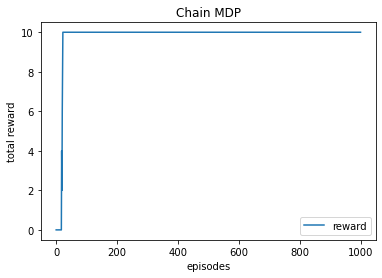

In [23]:
import matplotlib.pyplot as plt
#plt.figure(figsize=(15,15))
plt.plot(AUC, label = 'reward')

#plt.plot(np.cumsum(SCR_labels- SCR_labels_pred))
plt.legend()
plt.xlabel('episodes')
plt.ylabel('total reward')
plt.title('Chain MDP')

Text(0.5, 1.0, 'Chain MDP')

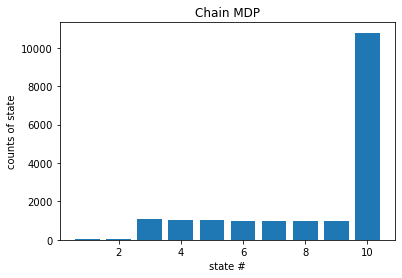

In [22]:
plt.bar(np.arange(10)+1, [   61,    67,  1061,  1039,  1016,  1003,   990,   991,   989, 10783])
#plt.legend()
plt.xlabel('state #')
plt.ylabel('counts of state')
plt.title('Chain MDP')

In [11]:
##### eval code #####
done = False
cum_reward = 0.0
# always move right left: 0, right: 1

env = ChainMDP(n)
s = env.reset()

while not done:
    action = agents.action(s)
    print("state: ", s)
    print("action: ", action)
    ns, reward, done, _ = env.step(action)
    cum_reward += reward
    s = ns
    
print(f"total reward: {cum_reward}")

state:  [1. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
action:  1
state:  [1. 1. 1. 0. 0. 0. 0. 0. 0. 0.]
action:  1
state:  [1. 1. 1. 1. 0. 0. 0. 0. 0. 0.]
action:  1
state:  [1. 1. 1. 1. 1. 0. 0. 0. 0. 0.]
action:  1
state:  [1. 1. 1. 1. 1. 1. 0. 0. 0. 0.]
action:  1
state:  [1. 1. 1. 1. 1. 1. 1. 0. 0. 0.]
action:  1
state:  [1. 1. 1. 1. 1. 1. 1. 1. 0. 0.]
action:  1
state:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
action:  1
state:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
action:  1
state:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
action:  1
state:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
action:  1
state:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
action:  1
state:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
action:  1
state:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
action:  1
state:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
action:  1
state:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
action:  1
state:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
action:  1
state:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
action:  1
total reward: 10.0
